# ***Progetto CV&DL - Alex Giacomini & Denis Bernovschi***

To Do List: 
- Provare altre Gan 
- Inserire altre metriche (https://machinelearningmastery.com/how-to-evaluate-generative-adversarial-networks/)  - ti ho inviato anche il paper su teams

Done: 
- Metriche Inserite (maximum_mean_discrepancy, FID, Inception Score) 
- Test a colori 

Prima di riprovare il codice ricontrolla tutti gli iper-parametri della gan (ho modificato il salvataggio delle foto e il numero di epoche) 


LEGGERE IMMAGINI DA CARTELLA E RICAVARE IL NOME
https://stackoverflow.com/questions/68112479/get-file-names-and-file-path-using-pytorch-dataloader

## IMPORT

In [28]:
import sys
import subprocess
if 'google.colab' in sys.modules:
  subprocess.call("pip install -U progress".split())

#---- RANDOM ------
import random
from random import randrange
random.seed( 40 )

#---- NUMPY -------
import pandas as pd
import numpy as np
import math
from pandas.compat._optional import import_optional_dependency

#----- OS ---------
import os
from os import path

#---- DRIVE --------
from google.colab import drive

#----- SCYPY -------
import scipy.ndimage

#----- MATPLOT LIB -----
import matplotlib.pyplot as plt

#------- TORCH VISION -------
from torchsummary import summary
from torchvision import transforms, datasets, utils 
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision.utils import save_image
from torch import optim 
from torch.optim import Adam, SGD, RMSprop 
import torchvision, torch 
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.transforms.transforms import CenterCrop


#----- PIL --------
from PIL import Image, ImageOps

#----- SKLEARN ----- 
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import class_weight
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import keras.backend as K #------ valutare/testare se serve ancora
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix


#----- IMPORT  PYTORCH ----------
!pip install pytorch-lightning -q 
from pytorch_lightning.callbacks import Callback, ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer


#----- IMPORT CV2 -----------
import cv2
from google.colab.patches import cv2_imshow

#----- ALTRO ------------
#LINK UTILE : https://github.com/chongwar/vgg16-pytorch/blob/master/vgg16_transfer_learning.py
#LINK UTILE : https://www.analyticsvidhya.com/blog/2019/10/how-to-master-transfer-learning-using-pytorch/ 
from functools import reduce

#----- SKIIMAGE -----------
from skimage import io
from skimage.io import imread
from skimage.color import rgb2gray, gray2rgb

#WGAN-GP APPROACH - imports
#https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py
import argparse

#---- PROGRESS BAR -------
from tqdm import tqdm


# per attuare il D.A. secondo il link di Riccardo
#!pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip --quiet --ignore-installed #--- qui va in errore, serviva per creare il batch rappresentativo
#from torchsampler import ImbalancedDatasetSampler



device = torch.device("cpu")

##WGAN-GP - APPOGGIO CODICE E PROVA

In [29]:
"""
#STO LAVORANDO QUA SE CI GUARDI - QUINDI NON TOCCARE NIENTE - CIT.ALEX

os.makedirs("images", exist_ok=True)

'''
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")

opt = parser.parse_args()
'''

opt = [["n_epochs", "batch_size", "lr", "b1", "b2", "n_cpu", "latent_dim", "img_size", "channels", "n_critic", "clip_value", "sample_interval"],
       [10,            64,      0.0002, 0.5,0.999,    8,        100,          28,          1,          5,         0.01,           400]]
#print(opt[0])
#print(opt[1])



img_shape = (opt[1][8], opt[1][7],  opt[1][7])

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block( opt[1][6], 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


# Loss weight for gradient penalty
lambda_gp = 10

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

#generator.to(device)
#discriminator.to(device)

#VALUTA SE CONFIGURARE ANCHE IL SALVATAGGIO DELLE IMMAGINI DIRETTAMENTE SU DRIVE PER QUELLE CHE CREA IL 'GENERATOR'
#PROBABILMENTE SERVIRÀ PERCHE A NOI SERVONO LE IMMAGINI COME DATA AUGMENTATION, QUINDI O LE SALVIAMO PRIMA E POI CI FACCIAMO IL LOAD, OPPURE PENSA COME COMBINARE INSIEME QUESTA FASE CON QUELLA DI ALLENAMENTO DELLA RETE VERA E PROPRIA

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize( opt[1][7]), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size= opt[1][1],
    shuffle=True,
)






# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr= opt[1][2], betas=( opt[1][3],  opt[1][4]))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr= opt[1][2], betas=( opt[1][3],  opt[1][4]))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


def compute_gradient_penalty(D, real_samples, fake_samples):
    """"""Calculates the gradient penalty loss for WGAN GP""""""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


# ----------
#  Training
# ----------

batches_done = 0
for epoch in range( opt[1][0]):
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()


        # Sample noise as generator input
        #-----FORSE QUESTO NON CI SERVE PERCHÈ NELLE NOSTRE IMMAGINI NON C'È RUMORE? OPPURE SERVE AL GENERATORE PER DISTORCERE L'IMMAGINE VERA?------
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0],  opt[1][6]))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i %  opt[1][9] == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch,  opt[1][0], i, len(dataloader), d_loss.item(), g_loss.item())
            )

            if batches_done %  opt[1][11] == 0:
                save_image(fake_imgs.data[:36], "images/%d.png" % batches_done, nrow=5, normalize=True)

            batches_done +=  opt[1][9]
"""

'\n#STO LAVORANDO QUA SE CI GUARDI - QUINDI NON TOCCARE NIENTE - CIT.ALEX\n\nos.makedirs("images", exist_ok=True)\n\n\'\'\'\nparser = argparse.ArgumentParser()\nparser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")\nparser.add_argument("--batch_size", type=int, default=64, help="size of the batches")\nparser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")\nparser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")\nparser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")\nparser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")\nparser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")\nparser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")\nparser.add_argument("--channels", type=

## Custom TO CATEGORICAL

In [30]:
#from tensorflow.keras.utils import to_categorical 
# LINK UTILE : https://pytorch.org/docs/stable/distributions.html
def custom_to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

## DRIVE 

In [31]:
drive.mount('/content/drive', force_remount=True)
path_drive = '/content/drive/My Drive/'
path_progettoDL = path_drive+'ProgettoDL/'

Mounted at /content/drive


## Parametri Immagini 

In [32]:
'''DEFINE VARIABLES AND PARAMETERS TO COLLECT THE INFORMATIONS FROM GOOGLE DRIVE'''
'''define a path for the collection of informations (CSV file) for the creation of the dataframe'''
os.chdir(path_progettoDL) 

'''to have always the same sequence of randomized values (numbers)'''
random_state = 3  

'''some useful parameters and variables'''
cnn = "vgg16" 

'''series of production & quality classes of the wood rifle butt'''
#classi = ['1','2','3','4']    
classi = ['1','2-','2','2+','3-','3','3+','4-','4','4+']          
serie = [2,4,8,10,6,9,3,11,12,13,14,15,7] 

'''size of the images & their paths (location) '''
#immg_rows = 270 
#immg_cols = 470
#immgs = '{}_{}'.format(parte,tipo)
#path_imgs = os.path.join(path_drive+'{}'.format(immgs))

#CSV loading (reading annotations/attributes/informations)
csv = pd.read_csv(('/content/drive/MyDrive/ProgettoDL/20201102_ExportDB.txt'), sep=";")

#CROP o NO CROP 
type_img = 'CROP' 
if type_img == 'CROP':
  path_images = '/content/drive/MyDrive/CALCIO_CROP_BASE/'
else:
  path_images = '/content/drive/MyDrive/CALCIO_NOPRE/'



## SPLIT DATA

In [33]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/algoritmi_custom')
import custom_split_data 
from custom_split_data import split_data

## CUSTOM DATASET + TRANSFORMS D.A. 

#### TRANSFORMS

In [34]:

#ESEMPI DI TRASFROMAZIONI (PER D.A.)
#https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

#LINK DI TRASFORMAZIONI
#https://pytorch.org/vision/stable/transforms.html


_transform_1 = transforms.Compose([
  transforms.ToPILImage(),
  #transforms.CenterCrop(0.75 * 64),
  transforms.Resize((270, 470)),            
  #T.RandomResizedCrop(image_size),
  transforms.RandomHorizontalFlip(p=1),
  transforms.ToTensor()])#,
  #transforms.Normalize([0.5], [0.5])])  #normalizza correttamente in quanto partendo da [0,1] arriva a [-1,1], guarda primo link])

_transform_2 = transforms.Compose([
  transforms.ToPILImage(),
  #transforms.CenterCrop(0.75 * 64),
  transforms.Resize((270, 470)),  
  transforms.ColorJitter(brightness=[.7,1.3]),  
  transforms.RandomPosterize(bits=2, p=1),  #ALTERNATIVA1, bit da mantenere per ogni canale RGB, (0-8 range permesso).  -- ALTERNATIVE DA TESTARE
  #transforms.RandomRotation(degrees=(-20, 20), expand=True, PIL.Image.NEAREST ),   #ALTERNATIVA2       
  #T.RandomResizedCrop(image_size),
  #transforms.RandomHorizontalFlip(),
  transforms.ToTensor()])#,
  #transforms.Normalize([0.5], [0.5])])  #normalizza correttamente in quanto partendo da [0,1] arriva a [-1,1], guarda primo link])

_transform_3 = transforms.Compose([
  transforms.ToPILImage(),
  #transforms.CenterCrop(0.75 * 64),
  transforms.Resize((270, 470)),            
  #T.RandomResizedCrop(image_size),
  transforms.RandomVerticalFlip(p=1),
  transforms.ToTensor()])#,
  #transforms.Normalize([0.5], [0.5])])  #normalizza correttamente in quanto partendo da [0,1] arriva a [-1,1], guarda primo link])

_transform_4 = transforms.Compose([
  transforms.ToPILImage(),
  #transforms.CenterCrop(0.75 * 64),
  transforms.Resize((270, 470)),            
  #T.RandomResizedCrop(image_size),
  transforms.RandomRotation((-30,+30)),
  transforms.ToTensor()])#,
  #transforms.Normalize([0.5], [0.5])])  #normalizza correttamente in quanto partendo da [0,1] arriva a [-1,1], guarda primo link])



# trasform generale per fare l'allenamento (senza GAN)
_transform_ = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((270, 470)),                                            
        transforms.ToTensor()])#,
        #transforms.Normalize([0.5], [0.5])])  #normalizza correttamente in quanto partendo da [0,1] arriva a [-1,1], guarda primo link


_transform_5 = transforms.Compose([                   #PER ESTRARRE patch di dimensione DIMEZZATA e farla in scala di grigi
        transforms.ToPILImage(),
        transforms.Resize((270, 470)), 
        transforms.CenterCrop((135,235)), 
        transforms.Grayscale(num_output_channels=1),  #VALUTA SE DIMINUIRE IL CROP A MENO PIXELS O ANCHE PER FORME RETTANGOLARI/QUADRATE
        transforms.ToTensor()])

_transform_GAN = transforms.Compose([                   #normalizzazione per GAN
        transforms.ToPILImage(),
        transforms.Resize((270, 470)), 
        #transforms.CenterCrop((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])])              #VALORI DI NORMALIZZAZIONE IN QUESTO MODO PORTANO I VALORI FINALI A DIVENTARE IN UN RANGE TRA [-1 E 1]


'''TRANSFORM PER TRAIN DOVE OGNUNO SI ATTIVA CON PROBABILITA' DEL 50% COSì DA OTTENERE PIU' COMBINAZIONI POSSIBILI'''
_transform_train = transforms.Compose(   #usato per ricavare i nomi delle nuove immagini generate con la GAN
    [transforms.ToPILImage(),
     transforms.Resize((270, 470)), 
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ColorJitter(brightness=[.7,1.3]),  
     transforms.RandomPosterize(bits=2, p=0.4),                                           
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])]
     )

NORMALIZE ------
* [Mezza spiegazione](https://discuss.pytorch.org/t/understanding-transform-normalize/21730)
* [LINK REPO](https://pytorch.org/vision/stable/generated/torchvision.transforms.Normalize.html#torchvision.transforms.Normalize)

https://deeplizard.com/learn/video/lu7TCu7HeYc



In [35]:
# Python program to normalize a tensor to
# 0 mean and 1 variance
# Step 1: Importing torch
import torch
  
# Step 2: creating a torch tensor
t = torch.tensor([1.,2.,3.,4.,5.])
print("Tensor before Normalize:\n", t)
  
# Step 3: Computing the mean, std and variance
mean, std, var = torch.mean(t), torch.std(t), torch.var(t)
print("Mean, Std and Var before Normalize:\n", 
      mean, std, var)
  
# Step 4: Normalizing the tensor
t  = (t-mean)/std


print("Tensor after Normalize:\n", t)
  
# Step 5: Again compute the mean, std and variance
# after Normalize
mean, std, var = torch.mean(t), torch.std(t), torch.var(t)
print("Mean, std and Var after normalize:\n", 
      mean, std, var)

Tensor before Normalize:
 tensor([1., 2., 3., 4., 5.])
Mean, Std and Var before Normalize:
 tensor(3.) tensor(1.5811) tensor(2.5000)
Tensor after Normalize:
 tensor([-1.2649, -0.6325,  0.0000,  0.6325,  1.2649])
Mean, std and Var after normalize:
 tensor(0.) tensor(1.) tensor(1.)


#### CUSTOM DATASET 

In [36]:
class CustomDataset(Dataset):
  def __init__ (self, dataframe, transform_0=None, transform_1 = None, transform_2 = None, transform_3 = None, transform_4 = None, weight=None, mode = None):
    self.transform_0 = transform_0
    self.transform_1 = transform_1
    self.transform_2 = transform_2
    self.transform_3 = transform_3
    self.transform_4 = transform_4
    self.mode = mode
    self.weight = weight
    self.dataframe = dataframe
  def __len__(self):
    return len(self.dataframe)
  
  #ho dovuto aggiungerlo perché l'imbalance dataset sampler lo chiedeva 
  def get_labels(self):
    print(self.dataframe['class'])
    return self.dataframe['class']

  def __getitem__(self, index):
    path = self.dataframe.iloc[index, 2]
    img_path = os.path.join(path_images+path)
    image = io.imread(img_path)
    y_label_class = torch.tensor(int(self.dataframe.iloc[index, 3]))              
    y_label_series = torch.tensor(int(self.dataframe.iloc[index, 1]))

    #da usare solo se aumentiamo il set offline, ma conviene senza troppe modifiche di creare un transform e mettere quei stessi metodi come probabilità a 0.5 così si possono anche combinare
    if self.mode == 'train':                            #questi 3 if servono solo per Augmentation Online se si usano le tecniche base di Computer Visioni di questi transform
      if self.dataframe.iloc[index, 4] == 'T0': 
        #print('transform T1')
        image = self.transform_0(image)
      if self.dataframe.iloc[index, 4] == 'T1': 
        #print('transform T1')
        image = self.transform_1(image)
      if self.dataframe.iloc[index, 4] == 'T2':
        #print('transform T2')
        image = self.transform_2(image)
      if self.dataframe.iloc[index, 4] == 'T3':
        #print('transform T3')
        image = self.transform_3(image)
      if self.dataframe.iloc[index, 4] == 'T4':
        #print('transform T3')
        image = self.transform_4(image)
    else:
      image = self.transform_0(image)

      
    
    #plt.imshow(image.numpy()[0], cmap='gray')
    
    return (image, y_label_class, y_label_series)

## NETWORK 

### Model Custom 

In [37]:
'''
import torch.nn.functional as F
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    
        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    
        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    
        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
    
        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten1 = nn.Flatten()
        self.dropOut = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57344, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.BatchNorm = nn.BatchNorm1d(4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        
        #x = x.reshape(x.shape[0], -1)
        x = self.flatten1(x)
        x = F.relu(self.dropOut(x))  
        x = F.relu(self.fc1(x))
        x = F.dropout2d(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.relu(self.BatchNorm(x))
        x = F.relu(self.fc3(x))
        return x

modelX = VGG16() #Definizione del modello Custom 

'''
#Il blocco sotto serve a freezare i pesi relativi ai layer convoluzionali 
#del modello custom - non preallenato
'''

modelX.conv1_1.weight.requires_grad = False
modelX.conv1_2.weight.requires_grad = False

modelX.conv2_1.weight.requires_grad = False
modelX.conv2_2.weight.requires_grad = False

modelX.conv3_1.weight.requires_grad = False
modelX.conv3_2.weight.requires_grad = False
modelX.conv3_3.weight.requires_grad = False

modelX.conv4_1.weight.requires_grad = False
modelX.conv4_2.weight.requires_grad = False
modelX.conv4_3.weight.requires_grad = False

modelX.conv5_1.weight.requires_grad = False
modelX.conv5_2.weight.requires_grad = False
modelX = modelX.to(device) #modelX = Model Custom Definito da NOI 

summary(modelX,input_size=(3, 270,470)) #modelX = Model Custom Definito da NOI 

model = modelX
'''
print("RETE CUSTOM CREATA")

RETE CUSTOM CREATA


### Model Pre-Trained - per classificazione

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 270, 470]           1,792
              ReLU-2         [-1, 64, 270, 470]               0
            Conv2d-3         [-1, 64, 270, 470]          36,928
              ReLU-4         [-1, 64, 270, 470]               0
         MaxPool2d-5         [-1, 64, 135, 235]               0
            Conv2d-6        [-1, 128, 135, 235]          73,856
              ReLU-7        [-1, 128, 135, 235]               0
            Conv2d-8        [-1, 128, 135, 235]         147,584
              ReLU-9        [-1, 128, 135, 235]               0
        MaxPool2d-10         [-1, 128, 67, 117]               0
           Conv2d-11         [-1, 256, 67, 117]         295,168
             ReLU-12         [-1, 256, 67, 117]               0
           Conv2d-13         [-1, 256, 67, 117]         590,080
             ReLU-14         [-1, 256, 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return forward_call(*input, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:1672: UserWarning: Dropout is a training op and should not be exported in inference mode. For inference, make sure to call eval() on the model and to export it with param training=False.
  warnings.warn("Dropout is a training op and should not be exported in inference mode. "


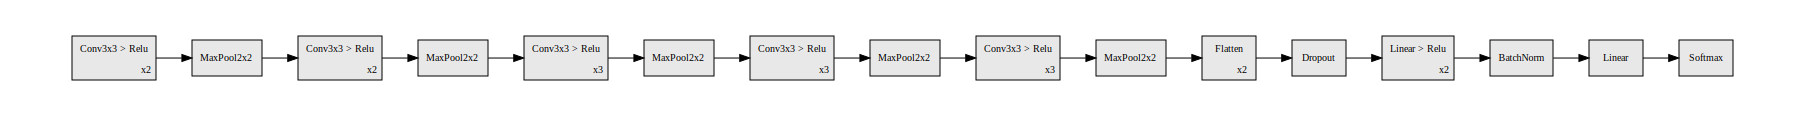

In [38]:
model = models.vgg16(pretrained=True)
#model.classifier = nn.Sequential(*[model.classifier[i] for i in range(5)])
print(model.features) # stampa tutto il modello a valle del classificatore 
#print(model)
#print(model.classifier) # stampa tutto il classificatore 
model.avgpool = nn.Identity() #sostituisco l'avg pool con un layer identità 
#print(model.avgpool) #stampo quel layer per controllo 

model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.5, inplace=False),
        nn.Linear(in_features=57344, out_features=4096,bias=True),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=4096, out_features=4096,bias=True), 
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096, affine=True),
        nn.Linear(4096, 10),
        nn.Softmax()
)
#print(model.classifier)
#model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)

#Freeze Weights Convolution Layer 
for name, layer in model.named_modules():
  #print(name)
  #conv layer 
  if name == 'features.0':
    layer.weight.requires_grad = False 
  if name == 'features.2': 
    layer.weight.requires_grad = False 
  if name == 'features.5':
    layer.weight.requires_grad = False 
  if name == 'features.7': 
    layer.weight.requires_grad = False 
  if name == 'features.10':
    layer.weight.requires_grad = False 
  if name == 'features.12': 
    layer.weight.requires_grad = False 
  if name == 'features.14':
    layer.weight.requires_grad = False 
  if name == 'features.17': 
    layer.weight.requires_grad = False 
  if name == 'features.19': 
    layer.weight.requires_grad = False
  if name == 'features.21':
    layer.weight.requires_grad = False 
  if name == 'features.24': 
    layer.weight.requires_grad = False 
  if name == 'features.26':
    layer.weight.requires_grad = False 
  if name == 'features.28':
    layer.weight.requires_grad = False 

model = model.to(device)
summary(model,input_size=(3, 270,470))

#Plot Model 
%pip install -U git+https://github.com/waleedka/hiddenlayer.git@master
import hiddenlayer as hl
hl.build_graph(model, torch.zeros([3, 3, 270, 470]))


## Metrica Balance Accuracy 

In [39]:

'''
Funzione per Balance Accuracy 
-- Link Utile : https://medium.com/@mostafa.m.ayoub/customize-your-keras-metrics-44ac2e2980bd --
-- https://medium.com/analytics-vidhya/custom-metrics-for-keras-tensorflow-ae7036654e05 --- 
-- https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score --- 
'''

'''
---- Questo caso funzione solo nel caso di classificazioni binarie ---- 
def monitor_balance_accuracy ():
	def bal_acc(y_true, y_pred):
		tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
		fn = K.sum(K.round(K.clip(y_true, 0, 1)))
		#sensitivity = tp / (fn + K.epsilon()) #--- primo test : versione trovata sul web, ma non tornano le formule
		sensitivity = tp / (fn + tp + K.epsilon()) #--OK

		tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
		fp = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
		#specificity = tn / (fp + K.epsilon()) #--- primo test : versione trovata sul web, ma non tornano le formule 
		specificity = tn / (fp + tn + K.epsilon()) #--OK 
	
		Balanced_Accuracy = (sensitivity+specificity)/2 #--OK
		return Balanced_Accuracy 
	return bal_acc
'''
		
'''
Funzione per Balance Accuracy 
'''
def monitor_balance_accuracy ():
	def bal_acc(y_true, y_pred):
		y_true = y_true.numpy().argmax(axis=1) #Returns the indices of the maximum values along an axis.
		y_pred = y_pred.numpy().argmax(axis=1) #Returns the indices of the maximum values along an axis.
		Balanced_Accuracy = balanced_accuracy_score(y_true, y_pred)
		Balanced_Accuracy = torch.tensor(Balanced_Accuracy) ##-- va trasformata in tensore (torch.tensor)
		return (Balanced_Accuracy) #--- capire se si può togliere il K. 
	return bal_acc

def _bal_acc_(y_true, y_pred):
	y_true = y_true.detach().numpy()
	y_pred = y_pred.detach().numpy()
#	print(y_pred)
#	print(len(y_pred))
#	print(type(y_pred))
#	print(y_true)
#	print(len(y_true))
#	print(type(y_true))
#	print('categorical')
	y_true = custom_to_categorical(y_true,10)
	y_true = y_true.argmax(axis=1) #Returns the indices of the maximum values along an axis.
	y_pred = y_pred.argmax(axis=1) #Returns the indices of the maximum values along an axis.
	Balanced_Accuracy = balanced_accuracy_score(y_true, y_pred)
	Balanced_Accuracy = torch.tensor(Balanced_Accuracy) ##-- va trasformata in tensore (torch.tensor)
	return (Balanced_Accuracy) 


## Early Stopping Class

In [40]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/algoritmi_custom')
import custom_early_stopping 
from custom_early_stopping import _EarlyStopping

## PREPROCESSING & DATA FRAME 

In [41]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/algoritmi_custom')
import check_for_leakage_function
from check_for_leakage_function import check_for_leakage

In [42]:
'''PREPROCESSING PHASE OF THE DATAFRAME (CREATIONS OF THE SUBSETS TRAIN/VALIDATION/TEST, CALCULATE WEIGHTS OF ELEMENTS OF THE SUBSETS, VERIFY THAT SAME IDs ARE IN THE SAME SUBSET)'''
os.chdir(path_progettoDL)
path = os.getcwd()

'''reading informations from the CSV'''
col_list_sx = ["ID", "COD_COMPONENTE", "IMG_LATOSX", "CLASSE_CALCIOSX"]
dataframe_sx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_sx, sep=";")

col_list_dx = ["ID", "COD_COMPONENTE", "IMG_LATODX", "CLASSE_CALCIODX"]
dataframe_dx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_dx, sep=";")

'''rename the dataframe columns'''
dataframe_sx.columns = ['ID','series', 'filename', 'class']
dataframe_dx.columns = ['ID','series', 'filename', 'class']

frames = [dataframe_sx, dataframe_dx] 
result = pd.concat(frames) #concatenate the two dataframes

print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("DATAFRAME COMPLETO INIZIALE")
print("result")
print(result)

#print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
#print("STAMPO ELEMENTO/I CON INDICE 1 (elemento tutto a sinistra)")
#print(result.loc[[1]])
#print(type(result.loc[[1]]))    #STAMPO IL TIPO DELL'ELEMENTO 

#print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
#print("LUNGHEZZA DATAFRAME COMPLESSIVO : {} ".format(result[result.columns[0]].count()))


'''mapping the values used for the classification into integer values'''
#version with 10 classes
result["class"] = result["class"].map({'1': int(0), '2-': int(1), '2': int(2), '2+': int(3), '3-': int(4), '3': int(5), '3+': int(6), '4-': int(7), '4': int(8), '4+': int(9)})
result["series"] = result["series"].map({2: int(0), 4: int(1), 8: int(2), 10: int(3), 6: int(4), 9: int(5), 3: int(6), 11: int(7), 12: int(8), 13: int(9), 14: int(10), 15: int(11), 7: int(12)}) 


'''identification of NULL values that would bring the execution on failing and eliminate those values'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Number of Null values in column 'quality_classes' : "+format(result['class'].isnull().sum()))
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
#print(result.loc[result['class'] == '0'])
print("mostro quegli elementi che hanno valore nullo")
print(result[result['class'].isnull()])
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")

'''Remove Null elements to avoid failures during executions (data in not useful!)'''
print("Rimuovo gli elementi nulli e verifico stampando nuovamente i valori nulli:")
result['class'] = pd.to_numeric(result['class'], errors='coerce')
result = result.dropna(subset=['class'])    #rimuovo le righe con elementi nulli

print("elementi nulli rimasti: "+format(result['class'].isnull().sum()))     #stampo per verifica se ci sono elementi nulli


'''verify if images exist in the Google Drive folder, when not present it is eliminated from the dataset aswell'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("elimino i file che non sono presenti in Google Drive anche se ci sono nel CSV")
print('CHECK FILE NON PRESENTI NELLA CARTELLA')

os.chdir(path_images)
i = 0; 
for index, row in result.iterrows():
    filename = row['filename']
    if os.path.exists(path_images+filename) == False:
      print('File Non Esiste !!!')
    
    if(os.path.exists(filename) == False):
      result = result.drop(result[(result['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))
      i = i + 1             
print('File Eliminati : {} '.format(i))

print('CHECK FILE CON NaN')
print(result[result['class'].isnull()])
print(result[result['series'].isnull()])
print(result[result['filename'].isnull()])
print(result[result['ID'].isnull()])
result = result[result['class'].notna()]
result = result[result['series'].notna()]
result = result[result['filename'].notna()]
result = result[result['ID'].notna()]



#----PER FARE LE PROVE RIDUCO LA DIMENSIONE DI RESULTS#
#result = result[:,100]

'''creation of masked images (grayscale images) and save them in Google Drive'''
'''than create a second dataframe with these new images'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
'''
mask_filenames = []
IDs = []
classes = []
for index, row in result.iterrows():
    filename = row['filename']
    mask_filenames.append(str("mask_"+filename))
    IDs.append(row['ID'])
    classes.append(row['class'])

print("DATAFRAME CON MASCHERE")
result2 = result.copy()
result2['mask_filename'] = mask_filenames
result2.drop('filename', axis='columns', inplace=True)   #rimuovo colonna con path immagini normali

column_names = ["ID","series", "mask_filename", "class"]
result2 = result2.reindex(columns=column_names)

print("result2")
print(result2)
#stampa della conta delle serie dei calci presenti nel dataframe
'''

'''performing the splitting of the dataframe into sub-sets'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("SPLIT DATA")

train_balance_df, test_balance_df, val_balance_df  = split_data(result, 0.2, 0.2, 3)  #CUSTOM SPLIT CON ID IN STESSO SET DI DATI
#train_mask, test_mask, validation_mask  = split_data(result2, 0.2, 0.2, 3)           #split per test con immagini con maschere

print("train_balance_df")
print(train_balance_df)
print("test_balance_df")
print(test_balance_df)
print("val_balance_df")
print(val_balance_df)


#------------------------version with 4 classes (togliere se si lavora con 10 classi)-----------------------------------
#train_balance_df["class"] = train_balance_df["class"].map({0: int(0), 1: int(1), 2: int(1), 3: int(1), 4: int(2), 5: int(2), 6: int(2), 7: int(3), 8: int(3), 9: int(3)})
#val_balance_df["class"] = val_balance_df["class"].map({0: int(0), 1: int(1), 2: int(1), 3: int(1), 4: int(2), 5: int(2), 6: int(2), 7: int(3), 8: int(3), 9: int(3)})
#test_balance_df["class"] = test_balance_df["class"].map({0: int(0), 1: int(1), 2: int(1), 3: int(1), 4: int(2), 5: int(2), 6: int(2), 7: int(3), 8: int(3), 9: int(3)})

"""
NOTA: versione dei metodi di tensorflow, che non divide però mantenendo stessi ID in stessi Sub-set
train_balance_df, test_balance_df = train_test_split(result, test_size=0.4, stratify=result['class'], random_state=2)
test_balance_df, val_balance_df = train_test_split(test_balance_df, test_size=0.5, stratify=test_balance_df['class'],random_state=2)
"""

'''verify distibution of classes in the sub-sets and calculate weights of the classes in each sub-set'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
vals, counts = np.unique(train_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Train")
print(len(train_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts[i]))

vals2, counts2 = np.unique(val_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Validation")
print(len(val_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts2[i]))

vals3, counts3 = np.unique(test_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Test")
print(len(test_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts3[i]))    


class_weights_train = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(train_balance_df['class']),y = train_balance_df['class'])
weight_train = {i : round(class_weights_train[i], 2) for i in range(len(classi))} 
print('Weight train_balance_df')
print(weight_train)


class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(val_balance_df['class']),y = val_balance_df['class'])
weight = {i : round(class_weights[i], 2) for i in range(len(classi))} 
print('Weight val_balance_df')
print(weight)


class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(test_balance_df['class']),y = test_balance_df['class'])
weight = {i : round(class_weights[i], 2) for i in range(len(classi))} 
print('Weight test_balance_df')
print(weight)


'''verify that same IDs are in the same sub-sets'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")

#--------verifico che stessi ID siano in stesso set--------
print("test case 1 - train VS validation")
print(f"Stessi ID in set usati?: {check_for_leakage(train_balance_df, val_balance_df, 'ID')}")
print("-------------------------------------")
print("test case 2 - train VS test")
print(f"Stessi ID in set usati ?: {check_for_leakage(train_balance_df, test_balance_df, 'ID')}")
print("-------------------------------------")
print("test case 3 - validation VS test")
print(f"Stessi ID in set usati?: {check_for_leakage(val_balance_df, test_balance_df, 'ID')}")


------------------------------------------------------------------------------------------------------------------------------------------------------------
DATAFRAME COMPLETO INIZIALE
result
        ID  series            filename class
0        3       2  20201 319 5323.png    3+
1        4       2  20201 3110125 .png    3+
2        5       2  20201 31101327.png    3+
3        6       2  20201 3110161 .png    3+
4        7       2  20201 3110177 .png    3+
...    ...     ...                 ...   ...
1059  2023       7  20201031090549.png    3+
1060  2024       7  20201031090855.png    3+
1061  2025       7  20201031091127.png    3+
1062  2026       7  20201031091720.png    3+
1063  2027       7  20201031091941.png    3+

[2128 rows x 4 columns]
------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Null values in column 'quality_classes' : 2
- - - - - - - - - - - - - - - - 

In [43]:
'''Verifica Classi Qualità per ogni Serie'''
print("Verifica Classi Qualità per ogni Serie")
result_x_ = result.groupby(['series','class']).size()
#print(result_x_)
result_class = result.groupby(['class']).size()
#print(result_class)
result_series = result.groupby(['series']).size()
#print(result_series)  
print('SOMMA IMG totali: {}'.format(np.sum(result_class)))


Verifica Classi Qualità per ogni Serie
SOMMA IMG totali: 2120


## Loss Function

In [44]:
from keras import backend as K
class weighted_categorical_crossentropy(object):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        loss = weighted_categorical_crossentropy(weights).loss
        model.compile(loss=loss,optimizer='adam')
    """
    
    def __init__(self,weights):
        self.weights = K.variable(weights)
        
    def loss(self,y_true, y_pred): 
        # scale preds so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred)
        # clip
        y_pred = K.clip(y_pred, K.epsilon(), 1)
        # calc
        
        loss = y_true*K.log(y_pred)*self.weights
        loss =-K.sum(loss,-1)
        return loss

## HYPERPARAMETERS


The **optimization algorithm** (or optimizer) is the main approach used today for training a machine learning model to minimize its error rate. There are *two metrics* to determine the efficacy of an optimizer: **speed of convergence** (the process of reaching a global optimum for gradient descent); and **generalization** (the model’s performance on new data)

***SGD*** : Stochastic Gradient Descent 

Parameters 
- Learning : learning rate is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function. ... In setting a learning rate, there is a trade-off between the rate of convergence and overshooting
- Momentum : Momentum is method which helps accelerate gradients vectors in the right directions, thus leading to faster converging.
- Decay :  We then set our decay to be the learning rate divided by the total number of epochs we are training the network for (a common rule of thumb) ... lr = (lr_iniziale - (1.0/(1-decay*iterations)))
- Nesterov: Nesterov which is set to false by default. Nesterov momentum is a different version of the momentum method which has stronger theoretical converge guarantees for convex functions.

[1° LINK](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)

[2° LINK](https://www.pyimagesearch.com/2019/07/22/keras-learning-rate-schedules-and-decay/)


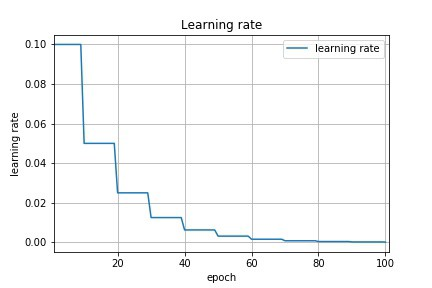

***ADAM*** :  Adaptive Moment Estimation




FONTI : Paper for ICLR 2019

In [45]:
#Definizione hyperparameters                                                                                                                        
optimizer_ = optim.SGD(model.parameters(), weight_decay=1e-5, lr=0.001, momentum=0.8)
epochs = 30 #100  
bs = 64

'''
losses = {
	"class_output": 'categorical_crossentropy'
}
lossWeights = { "class_output": 1}
'''
#hyper parametri test 

'\nlosses = {\n\t"class_output": \'categorical_crossentropy\'\n}\nlossWeights = { "class_output": 1}\n'

## CREAZIONE DATASET di TRAIN, VAL, TEST + TRANSFORM + creazione patch 

#### D.A. offline

In [46]:
'''
print(train_balance_df)
train_balance_df_copy_off = train_balance_df
n_img_for_class = np.zeros(10)
for i in range(10):
  n_img_for_class[i] = len(train_balance_df[train_balance_df['class']==i])
print(f'n° immagini per ciascuna classe ', n_img_for_class) #-- il n° di img per ciascuna classe 

classe_maggioritaria = np.max(n_img_for_class)
classe_minoritaria = np.min(n_img_for_class)
print(f'La classe maggioritaria contiene n: ',classe_maggioritaria,'immagini')
print(f'La classe minoritaria contiene n: ',classe_minoritaria,'immagini')
index_min = np.argmin(n_img_for_class)
index_max = np.argmax(n_img_for_class)
print(f'classe minima : ',index_min)
print(f'classe massima : ',index_max)


# calcolo n° immagini da creare per ciascuna classe di qualità - non lo usiamo direttamente
n_img_for_class_to_create = np.zeros(10)
for i in range(10):
  n_img_for_class_to_create[i] = classe_maggioritaria - n_img_for_class[i] 
print(f'n° immagini da creare per ciascuna classe ', n_img_for_class_to_create) #-- il n° di img per ciascuna classe 


#Data Augmentation Offline - Parto dalla prima classe di qualità e genero immagini volta per volta fino ad arrivare al numero della maggioritaria
for k in range(10): 
  #print(k)
  actual_df = train_balance_df[train_balance_df['class']==k]
  #print(actual_df)
  if n_img_for_class_to_create[k] > 0:
    print(f'devo creare immagini della classe : ',k)
    n_img_in_actual_df = len(actual_df)
    print(f'len actual df', n_img_in_actual_df)
    count = n_img_in_actual_df
    #for row in range(int(n_img_in_actual_df)):
    for i in range(int(abs(classe_maggioritaria/classe_minoritaria))): 
      for row in range(int(n_img_in_actual_df)):
        if (count < classe_maggioritaria):
          count = count + 1
          row_selected = actual_df.iloc[row]
          #--- D.A. offline  
          filename = row_selected['filename']
          
          img_path = os.path.join(path_images+filename)
          

          if i==0: 
            if os.path.exists(path_images+'T1_'+filename) == False:
              image = io.imread(img_path)
              image = _transform_1(image)
              save_image(image, path_images+'T1_'+filename)
            row_selected['filename'] = 'T1_'+filename
            #print(row_selected['filename'])
            train_balance_df_copy_off = train_balance_df_copy_off.append(row_selected, ignore_index = True)   
          if i==1: 
            if os.path.exists(path_images+'T2_'+filename) == False:
              image = io.imread(img_path)
              image = _transform_2(image)
              save_image(image, path_images+'T2_'+filename)
            row_selected['filename'] = 'T2_'+filename
            #print(row_selected['filename'])
            train_balance_df_copy_off = train_balance_df_copy_off.append(row_selected, ignore_index = True)
          if i==2: 
            if os.path.exists(path_images+'T3_'+filename) == False:
              image = io.imread(img_path)
              image = _transform_3(image)
              save_image(image, path_images+'T3_'+filename)
            row_selected['filename'] = 'T3_'+filename
            #print(row_selected['filename'])
            train_balance_df_copy_off = train_balance_df_copy_off.append(row_selected, ignore_index = True)    
        else: 
          break
  else:
    print(f'non devo creare immagini della classe : ',k)
# check di verifica 
#print(f'class_weight train_balance_df',compute_sample_weight(class_weight='balanced', y=train_balance_df['class']))
print(f'class_weight train_balance_df_copy_off',compute_sample_weight(class_weight='balanced', y=train_balance_df_copy_off['class']))
n_img_for_class_after = np.zeros(10)
for i in range(10):
  n_img_for_class_after[i] = len(train_balance_df_copy_off[train_balance_df_copy_off['class']==i])
print(f'n° immagini per ciascuna classe ', n_img_for_class_after) #-- il n° di img per ciascuna classe 


train_c_dataset = CustomDataset(train_balance_df_copy_off, transform_0=_transform_)
val_c_dataset = CustomDataset(val_balance_df, transform_0=_transform_)
test_c_dataset = CustomDataset(test_balance_df,transform_0=_transform_ )
'''

"\nprint(train_balance_df)\ntrain_balance_df_copy_off = train_balance_df\nn_img_for_class = np.zeros(10)\nfor i in range(10):\n  n_img_for_class[i] = len(train_balance_df[train_balance_df['class']==i])\nprint(f'n° immagini per ciascuna classe ', n_img_for_class) #-- il n° di img per ciascuna classe \n\nclasse_maggioritaria = np.max(n_img_for_class)\nclasse_minoritaria = np.min(n_img_for_class)\nprint(f'La classe maggioritaria contiene n: ',classe_maggioritaria,'immagini')\nprint(f'La classe minoritaria contiene n: ',classe_minoritaria,'immagini')\nindex_min = np.argmin(n_img_for_class)\nindex_max = np.argmax(n_img_for_class)\nprint(f'classe minima : ',index_min)\nprint(f'classe massima : ',index_max)\n\n\n# calcolo n° immagini da creare per ciascuna classe di qualità - non lo usiamo direttamente\nn_img_for_class_to_create = np.zeros(10)\nfor i in range(10):\n  n_img_for_class_to_create[i] = classe_maggioritaria - n_img_for_class[i] \nprint(f'n° immagini da creare per ciascuna classe ',

#### D.A. offline - GAN images load from drive - and D.A. CON GAN e TRANSFORMS

RICERCA DELLE IMMAGINI E SALVATAGGIO DEI NOMI SU UN CSV

DATA AUGMENTATION ON THE FLY - AUMENTARE LE IMMAGINI INVECE DI MODIFICARLE E BASTA
https://blog.paperspace.com/data-augmentation-for-object-detection-building-input-pipelines/ - NON SONOSICURO CHE MOLTIPLICHI LE IMMAGINI

https://discuss.pytorch.org/t/understand-data-augmentation-in-pytorch/139720

https://discuss.pytorch.org/t/increase-number-of-images/132075/6



----------------------------------------------------------------------------------------------------------------------------


DATA AUGMENTATION OFFLINE - AUGMENTING IMAGES
https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/

----------------------------------------------------------------------------------------------------------------------------

SUGGERIMENTI SU NORMALIZZAZIONE E COME FARLA, PER AIUTARE A VELOCIZZARE IL TRAINING!
https://glassboxmedicine.com/2022/01/21/building-custom-image-data-sets-in-pytorch-tutorial-with-code/

----------------------------------------------------------------------------------------------------------------------------

DATA AUGMENTATION ON THE FLY - METODI PER MODIFICARE LE IMMAGINI (TRANSFORMS)
https://github.com/gatsby2016/Augmentation-PyTorch-Transforms

In [47]:
"""
'''PARTE DOVE SI USA IL METODO ImageFolder PER LEGGERE TUTTE LE IMMAGINI IN UNA CARTELLA SENZA SAPERNE IL NOME E SALVARLE IN CSV E ALLEGARLE AL DATASET '''

# Define directory containing images-
data_dir = '/content/drive/MyDrive/CALCIO_CROP_BASE/'
data_dir_2 = '/content/drive/MyDrive/CALCIO_CROP_BASE/Data_Aug_GAN'

# Define datasets-
train_data = datasets.ImageFolder(data_dir + 'Data_Aug_GAN', 
                                  transform = transform_train)

print(train_data.imgs[785][0])  #QUESTO è IL NOME DEL FILE
print(train_data.imgs[785][1])  #QUESTO è LA CLASSE DI QUALITA' PESCATA DAL NOME DELLA CARTELLA


import os
#https://www.studytonight.com/python-howtos/how-to-get-the-last-part-of-the-path-in-python
path = os.path.basename(os.path.normpath(train_data.imgs[0][0]))  #ESTRARRE L'ULTIMA PARTE DI UN PERCORSO IN STRINGA, QUINDI IL NOME DEL FILE
print(path)

print(f"number of train images = {len(train_data)}")
print(f"number of training classes = {len(train_data.classes)}")


i = 0
os.chdir(path_progettoDL)
path = os.getcwd()


#CREO L'INTESTAZIONE DEL FILE
with open(path + '/GAN_DB.txt', 'a') as f:
    f.write('ID;COD_COMPONENTE;IMG;CLASSE_CALCIO')

#memorizzo ogni riga come il precedente file txt per le immagini vere
for i in range(len(train_data)):
  with open(path + '/GAN_DB.txt', 'a') as f:
    if train_data.imgs[i][1] > 5:
      f.write('\n{};10;Data_Aug_GAN/images_{}/{};{}'.format(i+2028,train_data.imgs[i][1]+1, os.path.basename(os.path.normpath(train_data.imgs[i][0])),train_data.imgs[i][1]+1))  #mi serve anche questo caso perchè la classe 6 non esiste, e lui scorrendo poi dalla classe 7 la considera come la 6
    else:
      f.write('\n{};10;Data_Aug_GAN/images_{}/{};{}'.format(i+2028,train_data.imgs[i][1], os.path.basename(os.path.normpath(train_data.imgs[i][0])),train_data.imgs[i][1]))

"""

'\n\'\'\'PARTE DOVE SI USA IL METODO ImageFolder PER LEGGERE TUTTE LE IMMAGINI IN UNA CARTELLA SENZA SAPERNE IL NOME E SALVARLE IN CSV E ALLEGARLE AL DATASET \'\'\'\n\n# Define directory containing images-\ndata_dir = \'/content/drive/MyDrive/CALCIO_CROP_BASE/\'\ndata_dir_2 = \'/content/drive/MyDrive/CALCIO_CROP_BASE/Data_Aug_GAN\'\n\n# Define datasets-\ntrain_data = datasets.ImageFolder(data_dir + \'Data_Aug_GAN\', \n                                  transform = transform_train)\n\nprint(train_data.imgs[785][0])  #QUESTO è IL NOME DEL FILE\nprint(train_data.imgs[785][1])  #QUESTO è LA CLASSE DI QUALITA\' PESCATA DAL NOME DELLA CARTELLA\n\n\nimport os\n#https://www.studytonight.com/python-howtos/how-to-get-the-last-part-of-the-path-in-python\npath = os.path.basename(os.path.normpath(train_data.imgs[0][0]))  #ESTRARRE L\'ULTIMA PARTE DI UN PERCORSO IN STRINGA, QUINDI IL NOME DEL FILE\nprint(path)\n\nprint(f"number of train images = {len(train_data)}")\nprint(f"number of training classes

In [48]:
#READ CSV WITH THE INFOs & CREATE THE FINAL BALANCED DATASET TO BE USED
os.chdir(path_progettoDL)
path = os.getcwd()

'''reading informations from the CSV'''
col_list = ["ID", "COD_COMPONENTE", "IMG", "CLASSE_CALCIO"]

dataframe_GAN = pd.read_csv(os.path.join(path + '/GAN_DB.txt'), usecols=col_list, sep=";")
dataframe_GAN.columns = ['ID','series', 'filename', 'class']

os.chdir(path_images)
i = 0; 
for index, row in dataframe_GAN.iterrows():
    filename = row['filename']
    if os.path.exists(path_images+filename) == False:
      print('File Non Esiste !!!')
    
    if(os.path.exists(filename) == False):
      dataframe_GAN = dataframe_GAN.drop(dataframe_GAN[(dataframe_GAN['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))
      i = i + 1             
print('File Eliminati : {} '.format(i))


data = train_balance_df
train_balance_df_copy = pd.DataFrame(data, columns=['ID', 'series', 'filename', 'class', 'transform'])
train_balance_df_copy['transform'] = 'T0'
print(train_balance_df)



data = dataframe_GAN
train_balance_df_copy_gan = pd.DataFrame(data, columns=['ID', 'series', 'filename', 'class', 'transform'])
train_balance_df_copy_gan['transform'] = 'T4'                                                                   #IN QUESTA RIGA POI PROVARE ANCHE CON ROTAZIONE PER RENDERLE UN PO DIVERSE (T4)
print(dataframe_GAN)

frames = [train_balance_df_copy, train_balance_df_copy_gan] 
result_2 = pd.concat(frames) #concatenate the two dataframes

print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("DATAFRAME COMPLETO INIZIALE")
print("result")
print(result_2)
train_balance_df_GAN = result_2

'''verify distibution of classes in the sub-sets and calculate weights of the classes in each sub-set'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
vals, counts = np.unique(train_balance_df_GAN['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Train")
print(len(train_balance_df_GAN))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts[i]))
print(result_2)


File Non Esiste !!!
File : Data_Aug_GAN/images_0/3452_1_20_2.png eliminato
File Non Esiste !!!
File : Data_Aug_GAN/images_0/3760_1_43_2.png eliminato
File Non Esiste !!!
File : Data_Aug_GAN/images_0/3773_1_28_2.png eliminato
File Non Esiste !!!
File : Data_Aug_GAN/images_0/3994_1_22_2.png eliminato
File Non Esiste !!!
File : Data_Aug_GAN/images_0/3996_1_38_2.png eliminato
File Non Esiste !!!
File : Data_Aug_GAN/images_0/3998_1_17_2.png eliminato
File Non Esiste !!!
File : Data_Aug_GAN/images_0/3999_1_12_2.png eliminato
File Non Esiste !!!
File : Data_Aug_GAN/images_0/3999_1_25_2.png eliminato
File Non Esiste !!!
File : Data_Aug_GAN/images_0/3999_1_34_2.png eliminato
File Non Esiste !!!
File : Data_Aug_GAN/images_0/3999_1_36_2.png eliminato
File Non Esiste !!!
File : Data_Aug_GAN/images_0/3999_1_3_2.png eliminato
File Non Esiste !!!
File : Data_Aug_GAN/images_0/3999_1_41_2.png eliminato
File Non Esiste !!!
File : Data_Aug_GAN/images_0/3999_1_49_2.png eliminato
File Non Esiste !!!
File :

In [49]:


#CREO SOLO IL DATASET OFFLINE, CON I NOMI DEI FILE CHE DEVE GENERARE, POI IL Custom_Dataset effettua le transform direttamente quando gli servono e quindi fa augmentation online

#NOTA IMPORTANTE SUL AUGMENTATION ONLINE! : praticamente non fa vero augmentation raddoppiando le immagini, ma applica solo le trasformazioni usate quando si attivano nel custom dataset e quelle vengono usate come immagini di train, quindi bisognerebbe cercare un modo per aumentarle
# https://stackoverflow.com/questions/51677788/data-augmentation-in-pytorch


# N° IMG per ciascuna classe
n_img_for_class = np.zeros(10)
for i in range(10):
  n_img_for_class[i] = len(train_balance_df_GAN[train_balance_df_GAN['class']==i])
print(f'n° immagini per ciascuna classe ', n_img_for_class) #-- il n° di img per ciascuna classe 

# Classe maggioritaria e minoritaria 
classe_maggioritaria = np.max(n_img_for_class)
#classe_maggioritaria = 240                              #commentarla se si vuole arrivare a al numero di immagini della classe maggioritaria

classe_minoritaria = np.min(n_img_for_class)
print(f'La classe maggioritaria contiene n: ',classe_maggioritaria,'immagini')
print(f'La classe minoritaria contiene n: ',classe_minoritaria,'immagini')

# indice classe maggioritaria e minoritaria 
index_min = np.argmin(n_img_for_class)
index_max = np.argmax(n_img_for_class)
print(f'classe minima : ',index_min)
print(f'classe massima : ',index_max)

# calcolo n° immagini da creare per ciascuna classe di qualità - non lo usiamo direttamente
n_img_for_class_to_create = np.zeros(10)
for i in range(10):
  n_img_for_class_to_create[i] = classe_maggioritaria - n_img_for_class[i] 
print(f'n° immagini da creare per ciascuna classe ', n_img_for_class_to_create) #-- il n° di img per ciascuna classe 


#Data Augmentation Online - genero nuovo dataset con colonna di trasformazioni da usare
for k in range(10): 
  #print(k)
  actual_df = train_balance_df_GAN[train_balance_df_GAN['class']==k]
  #print(actual_df)
  if n_img_for_class_to_create[k] > 0:
    print(f'devo creare immagini della classe : ',k)
    n_img_in_actual_df = len(actual_df)
    print(f'len actual df', n_img_in_actual_df)
    count = n_img_in_actual_df
    #for row in range(int(n_img_in_actual_df)):
    for i in range(int(abs(classe_maggioritaria/classe_minoritaria))): 
      for row in range(int(n_img_in_actual_df)):
        if (count < classe_maggioritaria):
          count = count + 1
          row_selected = actual_df.iloc[row]
          #parametri nuove img
          filename_ = row_selected['filename']
          class_ = row_selected['class']
          series_ = row_selected['series']
          ID_ = row_selected['ID']
          #creo un nuovo DF con l'id di transforms 
          if i==0: 
            row = {'ID': ID_, 'series': series_, 'filename': filename_, 'class': class_ , 'transform':'T1'}
            #print(row)
            train_balance_df_GAN = train_balance_df_GAN.append(row, ignore_index = True)   
          if i==1: 
            row = {'ID': ID_, 'series': series_, 'filename': filename_, 'class': class_ , 'transform':'T2'}
            #print(row)
            train_balance_df_GAN = train_balance_df_GAN.append(row, ignore_index = True)   
          if i==2: 
            row = {'ID': ID_, 'series': series_, 'filename': filename_, 'class': class_ , 'transform':'T3'}
            #print(row)
            train_balance_df_GAN = train_balance_df_GAN.append(row, ignore_index = True)    
        else: 
          break
  else:
    print(f'non devo creare immagini della classe : ',k)

#check di verifica 
#print(f'class_weight train_balance_df',compute_sample_weight(class_weight='balanced', y=train_balance_df['class']))
#print(f'class_weight train_balance_df_copy',compute_sample_weight(class_weight='balanced', y=train_balance_df_copy['class']))

n_img_for_class_after = np.zeros(10)
for i in range(10):
  n_img_for_class_after[i] = len(train_balance_df_GAN[train_balance_df_GAN['class']==i])
print(f'n° immagini per ciascuna classe ', n_img_for_class_after) #-- il n° di img per ciascuna classe 


##print DF copy (AFTER)
#print(f'train_balance_df_copy\n', train_balance_df_copy)


train_c_dataset = CustomDataset(train_balance_df_GAN, transform_0=_transform_, transform_1 = _transform_1, transform_2 = _transform_2, transform_3 = _transform_3, transform_4 = _transform_4, mode = 'train' )
val_c_dataset = CustomDataset(val_balance_df, transform_0=_transform_, transform_1 = None, transform_2 = None, transform_3 = None, mode = None)
test_c_dataset = CustomDataset(test_balance_df,transform_0=_transform_, transform_1 = None, transform_2 = None, transform_3 = None,  mode = None)



n° immagini per ciascuna classe  [117. 109. 150. 132. 138. 201. 206. 165. 197.  86.]
La classe maggioritaria contiene n:  206.0 immagini
La classe minoritaria contiene n:  86.0 immagini
classe minima :  9
classe massima :  6
n° immagini da creare per ciascuna classe  [ 89.  97.  56.  74.  68.   5.   0.  41.   9. 120.]
devo creare immagini della classe :  0
len actual df 117
devo creare immagini della classe :  1
len actual df 109
devo creare immagini della classe :  2
len actual df 150
devo creare immagini della classe :  3
len actual df 132
devo creare immagini della classe :  4
len actual df 138
devo creare immagini della classe :  5
len actual df 201
non devo creare immagini della classe :  6
devo creare immagini della classe :  7
len actual df 165
devo creare immagini della classe :  8
len actual df 197
devo creare immagini della classe :  9
len actual df 86
n° immagini per ciascuna classe  [206. 206. 206. 206. 206. 206. 206. 206. 206. 206.]


####DATA AUGMENTATION ONLINE

In [50]:
'''

#CREO SOLO IL DATASET OFFLINE, CON I NOMI DEI FILE CHE DEVE GENERARE, POI IL Custom_Dataset effettua le transform direttamente quando gli servono e quindi fa augmentation online

#NOTA IMPORTANTE SUL AUGMENTATION ONLINE! : praticamente non fa vero augmentation raddoppiando le immagini, ma applica solo le trasformazioni usate quando si attivano nel custom dataset e quelle vengono usate come immagini di train, quindi bisognerebbe cercare un modo per aumentarle
# https://stackoverflow.com/questions/51677788/data-augmentation-in-pytorch



#print train balance df 
#print(train_balance_df)

#nuovo df con le trasformazioni (DA CREARE)
data = train_balance_df
train_balance_df_copy = pd.DataFrame(data, columns=['ID', 'series', 'filename', 'class', 'transform'])
train_balance_df_copy['transform'] = 'T0'
#print DF copy (BEFORE)
#print(f'train_balance_df_copy\n', train_balance_df_copy)

# N° IMG per ciascuna classe
n_img_for_class = np.zeros(10)
for i in range(10):
  n_img_for_class[i] = len(train_balance_df[train_balance_df['class']==i])
print(f'n° immagini per ciascuna classe ', n_img_for_class) #-- il n° di img per ciascuna classe 

# Classe maggioritaria e minoritaria 
classe_maggioritaria = np.max(n_img_for_class)
classe_minoritaria = np.min(n_img_for_class)
print(f'La classe maggioritaria contiene n: ',classe_maggioritaria,'immagini')
print(f'La classe minoritaria contiene n: ',classe_minoritaria,'immagini')
# indice classe maggioritaria e minoritaria 
index_min = np.argmin(n_img_for_class)
index_max = np.argmax(n_img_for_class)
print(f'classe minima : ',index_min)
print(f'classe massima : ',index_max)

# calcolo n° immagini da creare per ciascuna classe di qualità - non lo usiamo direttamente
n_img_for_class_to_create = np.zeros(10)
for i in range(10):
  n_img_for_class_to_create[i] = classe_maggioritaria - n_img_for_class[i] 
print(f'n° immagini da creare per ciascuna classe ', n_img_for_class_to_create) #-- il n° di img per ciascuna classe 


#Data Augmentation Online - genero nuovo dataset con colonna di trasformazioni da usare
for k in range(10): 
  #print(k)
  actual_df = train_balance_df[train_balance_df['class']==k]
  #print(actual_df)
  if n_img_for_class_to_create[k] > 0:
    print(f'devo creare immagini della classe : ',k)
    n_img_in_actual_df = len(actual_df)
    print(f'len actual df', n_img_in_actual_df)
    count = n_img_in_actual_df
    #for row in range(int(n_img_in_actual_df)):
    for i in range(int(abs(classe_maggioritaria/classe_minoritaria))): 
      for row in range(int(n_img_in_actual_df)):
        if (count < classe_maggioritaria):
          count = count + 1
          row_selected = actual_df.iloc[row]
          #parametri nuove img
          filename_ = row_selected['filename']
          class_ = row_selected['class']
          series_ = row_selected['series']
          ID_ = row_selected['ID']
          #creo un nuovo DF con l'id di transforms 
          if i==0: 
            row = {'ID': ID_, 'series': series_, 'filename': filename_, 'class': class_ , 'transform':'T1'}
            #print(row)
            train_balance_df_copy = train_balance_df_copy.append(row, ignore_index = True)   
          if i==1: 
            row = {'ID': ID_, 'series': series_, 'filename': filename_, 'class': class_ , 'transform':'T2'}
            #print(row)
            train_balance_df_copy = train_balance_df_copy.append(row, ignore_index = True)   
          if i==2: 
            row = {'ID': ID_, 'series': series_, 'filename': filename_, 'class': class_ , 'transform':'T3'}
            #print(row)
            train_balance_df_copy = train_balance_df_copy.append(row, ignore_index = True)    
        else: 
          break
  else:
    print(f'non devo creare immagini della classe : ',k)

#check di verifica 
#print(f'class_weight train_balance_df',compute_sample_weight(class_weight='balanced', y=train_balance_df['class']))
#print(f'class_weight train_balance_df_copy',compute_sample_weight(class_weight='balanced', y=train_balance_df_copy['class']))

n_img_for_class_after = np.zeros(10)
for i in range(10):
  n_img_for_class_after[i] = len(train_balance_df_copy[train_balance_df_copy['class']==i])
print(f'n° immagini per ciascuna classe ', n_img_for_class_after) #-- il n° di img per ciascuna classe 


##print DF copy (AFTER)
#print(f'train_balance_df_copy\n', train_balance_df_copy)

train_c_dataset = CustomDataset(train_balance_df_copy, transform_0=_transform_, transform_1 = _transform_1, transform_2 = _transform_2, transform_3 = _transform_3, mode = 'train' )
val_c_dataset = CustomDataset(val_balance_df, transform_0=_transform_, transform_1 = None, transform_2 = None, transform_3 = None, mode = None)
test_c_dataset = CustomDataset(test_balance_df,transform_0=_transform_, transform_1 = None, transform_2 = None, transform_3 = None,  mode = None)

'''

"\n\n#CREO SOLO IL DATASET OFFLINE, CON I NOMI DEI FILE CHE DEVE GENERARE, POI IL Custom_Dataset effettua le transform direttamente quando gli servono e quindi fa augmentation online\n\n#NOTA IMPORTANTE SUL AUGMENTATION ONLINE! : praticamente non fa vero augmentation raddoppiando le immagini, ma applica solo le trasformazioni usate quando si attivano nel custom dataset e quelle vengono usate come immagini di train, quindi bisognerebbe cercare un modo per aumentarle\n# https://stackoverflow.com/questions/51677788/data-augmentation-in-pytorch\n\n\n\n#print train balance df \n#print(train_balance_df)\n\n#nuovo df con le trasformazioni (DA CREARE)\ndata = train_balance_df\ntrain_balance_df_copy = pd.DataFrame(data, columns=['ID', 'series', 'filename', 'class', 'transform'])\ntrain_balance_df_copy['transform'] = 'T0'\n#print DF copy (BEFORE)\n#print(f'train_balance_df_copy\n', train_balance_df_copy)\n\n# N° IMG per ciascuna classe\nn_img_for_class = np.zeros(10)\nfor i in range(10):\n  n_im

###PRE-PROCESSING FOR GAN USAGE

#### SETS EXTRACTION FOR DATA AUGEMNTATION WITH GANs

NOTA = per rimuovere Data Augmentation, commentare tutto il blocco e utilizzare direttamente il set 'train_balance_df'

In [51]:
#print(train_balance_df)
#print(len(train_balance_df))


#Estraggo solo le immagini di un solo lato perchè altrimenti geometrie sono opposte - SE USIAMO LE PATCH NON ABBIAMO BISOGNO DI SPEZZARE IL DATASET PERCHÈ LA GEOMETRIA NON C'È PIÙ
#-----PER IMMAGINI INTERE
#train_balance_df_lato_1 = train_balance_df[::2]

#-----PER IMMAGINI PATCH PRENDO TUTTO IL DATASET CON CLASSI DI QUALITÀ
train_balance_df_lato_1 = train_balance_df
'''
print(len(train_balance_df_lato_1))
print(train_balance_df_lato_1) #Prendo solo quelle da un lato, quindi o solo le pari o solo le dispari
'''

df_class_0 = train_balance_df_lato_1.loc[train_balance_df_lato_1['class'] == 0]
print(df_class_0)
print(len(df_class_0))

print("---------------------------------------------------")
df_class_9 = train_balance_df_lato_1.loc[train_balance_df_lato_1['class'] == 9]
print(df_class_9)
print(len(df_class_9))

print("---------------------------------------------------")
df_class_8 = train_balance_df_lato_1.loc[train_balance_df_lato_1['class'] == 8]
print(df_class_8)
print(len(df_class_8))

print("---------------------------------------------------")
df_class_7 = train_balance_df_lato_1.loc[train_balance_df_lato_1['class'] == 7]
print(df_class_7)
print(len(df_class_7))

print("---------------------------------------------------")
df_class_6 = train_balance_df_lato_1.loc[train_balance_df_lato_1['class'] == 6]
print(df_class_6)
print(len(df_class_6))

print("---------------------------------------------------")
df_class_5 = train_balance_df_lato_1.loc[train_balance_df_lato_1['class'] == 5]
print(df_class_5)
print(len(df_class_5))

print("---------------------------------------------------")
df_class_4 = train_balance_df_lato_1.loc[train_balance_df_lato_1['class'] == 4]
print(df_class_4)
print(len(df_class_4))

print("---------------------------------------------------")
df_class_3 = train_balance_df_lato_1.loc[train_balance_df_lato_1['class'] == 3]
print(df_class_3)
print(len(df_class_3))

print("---------------------------------------------------")
df_class_2 = train_balance_df_lato_1.loc[train_balance_df_lato_1['class'] == 2]
print(df_class_2)
print(len(df_class_2))

print("---------------------------------------------------")
df_class_1 = train_balance_df_lato_1.loc[train_balance_df_lato_1['class'] == 1]
print(df_class_1)
print(len(df_class_1))


       ID series            filename  class
22    309      3  20203 2 7 2249.png    0.0
23    309      3  20203 2 7 2239.png    0.0
24    320      3  20203 2 7 3533.png    0.0
25    320      3  20203 2 7 3521.png    0.0
26    366      3  20203 2 9 3946.png    0.0
...   ...    ...                 ...    ...
1058  278      3  20202 2716493 .png    0.0
1059  278      3  20202 27164849.png    0.0
1088  348      3  20203 2 8 2951.png    0.0
1089  348      3  20203 2 8 2938.png    0.0
1160  304      3  20203 2 7 195 .png    0.0

[95 rows x 4 columns]
95
---------------------------------------------------
        ID series            filename  class
66    1817      4  20200529172017.png    9.0
67    1817      4  20200529171958.png    9.0
70    1836     10  20200529194441.png    9.0
71    1836     10  20200529194427.png    9.0
106   1689      8  20200525181453.png    9.0
...    ...    ...                 ...    ...
1218   637      4  20200506131733.png    9.0
1244   473      4  20203 108 2449.

##### Custom Dataset 2

(da utilizzare solo per salvare le patch delle immagini in ciascuna cartella, eventualmente dopo aver applicato delle trasformazioni ma che al momento non si fanno)

In [52]:
#Custom dataset to SAVE PATCHES
class CustomDataset2(Dataset):
  def __init__ (self, dataframe, transform_0=None, transform_1 = None, transform_2 = None, transform_3 = None, weight=None, mode = None):
    self.transform_0 = transform_0
    self.transform_1 = transform_1
    self.transform_2 = transform_2
    self.transform_3 = transform_3
    self.mode = mode
    self.weight = weight
    self.dataframe = dataframe
  def __len__(self):
    return len(self.dataframe)
  
  #ho dovuto aggiungerlo perché l'imbalance dataset sampler lo chiedeva - per il SAMPLER di molte versioni di codice fà
  def get_labels(self):
    print(self.dataframe['class'])
    return self.dataframe['class']

  def __getitem__(self, index):
    path = self.dataframe.iloc[index, 2]
    img_path = os.path.join(path_images+path)
    image = io.imread(img_path)
    y_label_class = torch.tensor(int(self.dataframe.iloc[index, 3]))              
    y_label_series = torch.tensor(int(self.dataframe.iloc[index, 1]))

    if self.mode == 'train':
      if self.dataframe.iloc[index, 4] == 'T1': 
        #print('transform T1')
        image = self.transform_1(image)
      if self.dataframe.iloc[index, 4] == 'T2':
        #print('transform T2')
        image = self.transform_2(image)
      if self.dataframe.iloc[index, 4] == 'T3':
        #print('transform T3')
        image = self.transform_3(image)

    if self.transform_0: 
      #print('transform generale')
      image = self.transform_0(image)
      #save_image(image, "patches/class{0}.0/patch_{1}".format(y_label_class,path), normalize=True, cmap='gray')    #sbloccare quando serve di salvare le patch

      #ALTERNATIVA DI SALVATAGGIO IMMAGINE
      #torch.save(image, 'data_drive_path{}'.format(idx))
    
    return (image, y_label_class, y_label_series)


In [53]:
'''ricavare il dataset di immagini per una specifica classe di qualità'''

#SAVE PATCHES EXTRACTED FROM IMAGES
#cartelle in cui salvare i patches : /drive/CALCIO_CROP_BASE/patches/...
os.makedirs("patches/class0.0", exist_ok=True)
os.makedirs("patches/class9.0", exist_ok=True)
os.makedirs("patches/class8.0", exist_ok=True)
os.makedirs("patches/class7.0", exist_ok=True)
os.makedirs("patches/class6.0", exist_ok=True)
os.makedirs("patches/class5.0", exist_ok=True)
os.makedirs("patches/class4.0", exist_ok=True)
os.makedirs("patches/class3.0", exist_ok=True)
os.makedirs("patches/class2.0", exist_ok=True)
os.makedirs("patches/class1.0", exist_ok=True)

#------------------------------------------------------MODIFICARE SEMPRE DA QUA SOTTO---------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------

#IN QUESTA RIGA SOTTO UTILIZZARE COME PRIMO PARAMETRO IL DATASET CHE SI VUOLE USARE PER ESTRARRE IL PATCH
train_c_dataset_patches = CustomDataset2(df_class_9, transform_0=_transform_GAN)                                                  #MODIFICARE SEMPRE IL DATASET CHE SI VUOLE ITERARE DA MODIFICARE IL PERCORSO
trainloader_patches = torch.utils.data.DataLoader(dataset = train_c_dataset_patches, batch_size=bs, shuffle=True)#,num_workers=2

#ITERO GLI ELEMENTI DEL DATALOADER PER RICAVARE I PATCH
for i, (data, targets, targets2) in tqdm(enumerate(trainloader_patches)):
  print(i)


#CREO IL NUOVO DATASET DA USARE COI PATCH PER LA GAN, SENZA MODIFICARE IL PRECEDENTE
mask_filenames = []
IDs = []
classes = []
for index, row in df_class_9.iterrows():                                                                                          #MODIFICARE SEMPRE IL DATASET CHE SI VUOLE ITERARE DA MODIFICARE IL PERCORSO
    filename = row['filename']
    mask_filenames.append(str("patches/class{0}/patch_{1}".format(row['class'],filename)))

    IDs.append(row['ID'])
    classes.append(row['class'])

print("DATAFRAME CON PATCHES")
df_class_new = df_class_9.copy()                                                                                                  #MODIFICARE SEMPRE IL DATASET CHE SI VUOLE ITERARE DA MODIFICARE IL PERCORSO
df_class_new.drop('filename', axis='columns', inplace=True)   
df_class_new['filename'] = mask_filenames

column_names = ["ID","series", "filename", "class"]
df_class_new = df_class_new.reindex(columns=column_names)
print(df_class_new)


#ATTIVA SOLO SE I RISULTATI CON TROPPE IMMAGINI PORTANO A GENERAZIONI NON BUONE, COSì GLI SI DANNO MENO IMMAGINI O SVALVOLA
#df_class_new = df_class_new[40:71]
df_class_new = df_class_new.sample(n = 62, random_state = 4)                                                                      #MODIFICARE SEMPRE IL DATASET CHE SI VUOLE ITERARE DA MODIFICARE IL PERCORSO
print(df_class_new)
print(len(df_class_new))


1it [00:00,  1.33it/s]

0
DATAFRAME CON PATCHES
        ID series                                   filename  class
66    1817      4  patches/class9.0/patch_20200529172017.png    9.0
67    1817      4  patches/class9.0/patch_20200529171958.png    9.0
70    1836     10  patches/class9.0/patch_20200529194441.png    9.0
71    1836     10  patches/class9.0/patch_20200529194427.png    9.0
106   1689      8  patches/class9.0/patch_20200525181453.png    9.0
...    ...    ...                                        ...    ...
1218   637      4  patches/class9.0/patch_20200506131733.png    9.0
1244   473      4  patches/class9.0/patch_20203 108 2449.png    9.0
1245   473      4  patches/class9.0/patch_20203 108 2438.png    9.0
1246   498      4  patches/class9.0/patch_20203 109 5735.png    9.0
1247   498      4  patches/class9.0/patch_20203 109 5720.png    9.0

[62 rows x 4 columns]
        ID series                                   filename  class
106   1689      8  patches/class9.0/patch_20200525181453.png    9.0
6

### Esempio di Posterize & Normalize

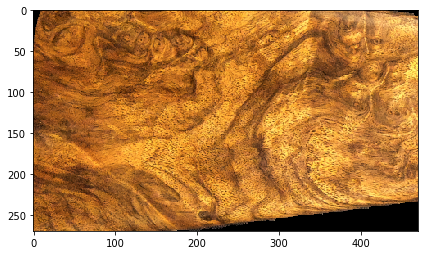

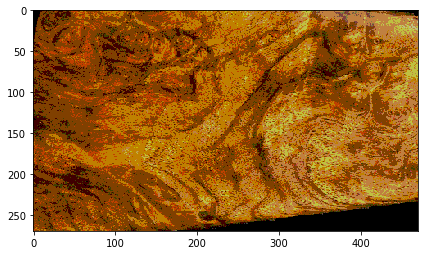

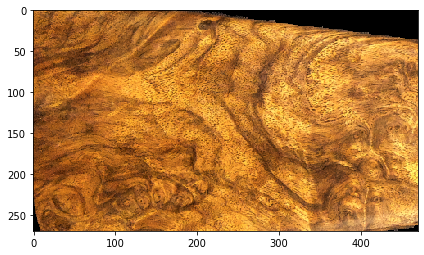

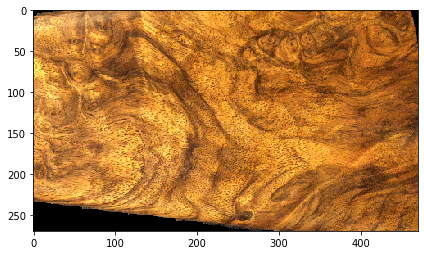

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.7529, 0.5020, 0.5020,  ..., 0.0000, 0.0000, 0.0000],
         [0.7529, 0.7529, 0.7529,  ..., 0.0000, 0.0000, 0.0000],
         [0.7529, 0.7529, 0.5020,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.5020, 0.2510, 0.2510,  ..., 0.0000, 0.0000, 0.0000],
         [0.5020, 0.2510, 0.5020,  ..., 0.0000, 0.0000, 0.0000],
         [0.5020, 0.2510, 0.2510,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [54]:
img_path = os.path.join('/content/drive/MyDrive/CALCIO_CROP_BASE/20200529171958.png') 
image = io.imread(img_path)
io.imshow(image)
plt.show()

img_path2 = os.path.join('/content/drive/MyDrive/CALCIO_CROP_BASE/T3_20200529171958.png') 
image2 = io.imread(img_path2)
io.imshow(image2)
plt.show()

img_path3 = os.path.join('/content/drive/MyDrive/CALCIO_CROP_BASE/T2_20200529171958.png') 
image3 = io.imread(img_path3)
io.imshow(image3)
plt.show()


img_path4 = os.path.join('/content/drive/MyDrive/CALCIO_CROP_BASE/T1_20200529171958.png') 
image4 = io.imread(img_path4)
io.imshow(image4)
plt.show()
#image = _transform_(image)
#plt.imshow(image.numpy()[0], cmap='rgb')


#esempio NORMALIZE
image5 = io.imread(img_path2)
image5 = _transform_(image5)
image6 = io.imread(img_path2)
image6 = _transform_(image6)

print(image5)
print(image6)
print(image6.shape)
print(torch.max(image5[0]))
print(torch.max(image6[0]))
print(torch.max(image5[1]))
print(torch.max(image6[1]))
print(torch.max(image5[2]))
print(torch.max(image6[2]))
print(image5[0])

## SAMPLER (usato attualmente)

#### Classe BalancedBatchSampler 

SERVE A CREARE IL BATCH RAPPRESENTATIVO

In [55]:
import torch
is_torchvision_installed = True
try:
    import torchvision
except:
    is_torchvision_installed = False
import torch.utils.data
import random

class BalancedBatchSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset, labels=None):
        self.labels = labels
        self.dataset = dict()
        self.balanced_max = 0

        #prova denis 
        self.number_of_samples = 0

        # Save all the indices for all the classes
        for idx in range(0, len(dataset)):
            label = self._get_label(dataset, idx)
            if label not in self.dataset:
                self.dataset[label] = list()
            self.dataset[label].append(idx)
            self.balanced_max = len(self.dataset[label]) \
                if len(self.dataset[label]) > self.balanced_max else self.balanced_max
        
        # Oversample the classes with fewer elements than the max
        for label in self.dataset:
            while len(self.dataset[label]) < self.balanced_max:
                self.dataset[label].append(random.choice(self.dataset[label]))
        self.keys = list(self.dataset.keys())
        self.currentkey = 0
        self.indices = [-1]*len(self.keys)
        self.number_of_samples = self.balanced_max * len(self.dataset)
        
    def __iter__(self):
        while self.indices[self.currentkey] < self.balanced_max - 1:
            self.indices[self.currentkey] += 1
            yield self.dataset[self.keys[self.currentkey]][self.indices[self.currentkey]]
            self.currentkey = (self.currentkey + 1) % len(self.keys)
        self.indices = [-1]*len(self.keys)
    
    def _get_label(self, dataset, idx, labels = None):
        if self.labels is not None:
            return self.labels[idx].item()
        else:
            # Trying guessing
            dataset_type = type(dataset)
            if is_torchvision_installed and dataset_type is torchvision.datasets.MNIST:
                return dataset.train_labels[idx].item()
            elif is_torchvision_installed and dataset_type is torchvision.datasets.ImageFolder:
                return dataset.imgs[idx][1]
            else:
                raise Exception("You should pass the tensor of labels to the constructor as second argument")

    def __len__(self):
        return self.balanced_max*len(self.keys)


#### WeightedRandomSampler (TEST) 

You are correct regarding the transformation. The transformation will be applied on the fly on your minority class data. You are also correct regarding the WeightedRandomSampler, if you are keeping the default replacement=True argument.

https://discuss.pytorch.org/t/how-to-augment-the-minority-class-only-in-an-unbalanced-dataset/13797/2

In [56]:
'''
class_sample_counts = train_balance_df.groupby(by="series").count()
class_sample_counts = class_sample_counts['ID'].to_numpy()
print(class_sample_counts)
class_weights = torch.tensor(compute_sample_weight(class_weight='balanced', y=train_balance_df['series'])) #--- use of compute_sample_weight from sklearn 
print(class_weights)

sampler_ = torch.utils.data.sampler.WeightedRandomSampler(
    weights=class_weights,
    num_samples=len(class_weights),
    replacement=True)
'''

'\nclass_sample_counts = train_balance_df.groupby(by="series").count()\nclass_sample_counts = class_sample_counts[\'ID\'].to_numpy()\nprint(class_sample_counts)\nclass_weights = torch.tensor(compute_sample_weight(class_weight=\'balanced\', y=train_balance_df[\'series\'])) #--- use of compute_sample_weight from sklearn \nprint(class_weights)\n\nsampler_ = torch.utils.data.sampler.WeightedRandomSampler(\n    weights=class_weights,\n    num_samples=len(class_weights),\n    replacement=True)\n'

#### Imbalanced Dataset Sampler 
(LINK: https://github.com/ufoym/imbalanced-dataset-sampler) 

In [57]:
#!pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip --quiet --ignore-installed #--- qui va in errore, serviva per creare il batch rappresentativo
!pip install torchsampler
from torchsampler import ImbalancedDatasetSampler

#sampler_imbalance = ImbalancedDatasetSampler(train_c_dataset)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Creazione DataLoader TRAIN, VAL, TEST

In [58]:
#QUA SOTTO SI TENGONO DA PARTE TUTTI I SET ESTRATTI VOLTA PER VOLTA SE DOVESSERO RISERVIRE PER TESTS

#---------NO DATA AUGMENTATION
#train_c_dataset = CustomDataset(train_balance_df, transform_0=_transform_)
 

#---------PER GAN
#train_c_dataset = CustomDataset(df_class_new, transform_0=_transform_GAN)  
#val_c_dataset = CustomDataset(val_balance_df, transform_0=_transform_)
#test_c_dataset = CustomDataset(test_balance_df,transform_0=_transform_ )

#---------PER CLASSIFICATORE CON IMMAGINI AUGMENTATION GAN OFFLINE
#train_c_dataset = CustomDataset(train_balance_df_GAN, transform_0=_transform_train) 
#val_c_dataset = CustomDataset(val_balance_df, transform_0=_transform_)
#test_c_dataset = CustomDataset(test_balance_df,transform_0=_transform_ )


In [59]:
# creating tensor from targets_df - PER BALANCED DATA SAMPLER
torch_tensor = torch.tensor(train_balance_df_GAN['class'].values)

# printing out result
print(torch_tensor)
print(torch_tensor.shape)

#HO RICAVATO LE LABELS DEGLI ELEMENTI IN TENSOREDA PASSARE AL BALANCED BATCH SAMPLER

tensor([7., 8., 6.,  ..., 9., 9., 9.], dtype=torch.float64)
torch.Size([2060])


In [60]:

#QUESTA PARTE POTREMO DOVERE USARLA SE IMPLEMENTEREMO UN SAMPLER CHE ABBIAMO SOPRA PER PESCARE DAL DATASET IMMAGINI IN MODO SPECIFICO



#BALANCED DATA SAMPLER
trainloader = torch.utils.data.DataLoader(
    train_c_dataset,
    sampler=BalancedBatchSampler(train_c_dataset, torch_tensor),
    batch_size=60
)


'''#IMBALANCED DATA SAMPLER
trainloader = torch.utils.data.DataLoader(
    train_c_dataset,
    sampler=ImbalancedDatasetSampler(train_c_dataset),
    batch_size=bs
)'''



#trainloader senza BALANCED Batch Sampler / iMBALANCED
#trainloader = torch.utils.data.DataLoader(dataset = train_c_dataset, batch_size=64, shuffle=True)#,num_workers=2

valloader = torch.utils.data.DataLoader(dataset = val_c_dataset, batch_size=bs, shuffle=True)#,num_workers=2
testloader = torch.utils.data.DataLoader(dataset = test_c_dataset, batch_size=bs, shuffle=True)#,num_workers=2

##GAN EVALUATION METRICS - IMAGE QUALITY 

Quello che si potrbbe fare per avere un valore di riferimento da controllare con le metriche è calcolare la metrica stessa solo su immagini reali così da avere un valore di qualità di riferimento, così come quando applicheremo sotto le metriche per la diversità, da avere anche un rifeirmento sul quanto vengano univoche e quindi di valore .


PYTORCH LIBRARY GAN METRICS (FID & IS)
https://pypi.org/project/pytorch-gan-metrics/

#### FID 
[GITHUB](https://github.com/hukkelas/pytorch-frechet-inception-distance)

- Il valore deve essere il PIÙ BASSO possibile
- è un miglioramento dell'IS quindi valuta se sotituire IS con un'altra metrica

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/algoritmi_custom')
from custom_FID import load_images, calculate_fid


#### IS - Inception Score 
[GITHUB](https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py)

- il valore deve essere PIÙ ALTO possibile
- serve il CLASSIFICATORE per valutare quante immagini riconosce bene, solo sul set di immagini create


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/algoritmi_custom')
import custom_IS 
from custom_IS import inception_score

####MMD - Maximum Mean Discrepancy 

maximum_mean_discrepancy
[LINK](https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy/notebook)

- il valore deve essere PIÙ BASSO possibile, perchè indica similarità dalle imaggini RAW, ma troppo basso vorrebbe anche dire che potrebbe generarle troppo simili alle originali

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/algoritmi_custom')
#import custom_MMD
#from custom_MMD import MMD
from custom_MMD import custom_MMD as MMD

##GAN EVALUATION METRICS - IMAGE DIVERSITY

(se fosse la metrica migliore con quelle generate significherebbe che la GAN genera immagini significative, e quindi limiterebbe anche overfitting in partenza)

####NDB -

- Per valautare la diversità delle immagini e se c'è MODE COLLAPSE

- per avere un risultato buono, l'andamento deve abbassarsi durante l'allenamento e comunque tendere a 0 il pià possibile

In [ ]:
'''IMPORTS NEEDED FOR THE NDB IMPLEMENTATION'''

#https://github.com/yhlleo/GAN-Metrics/blob/master/scores/ndb_jsd.py - VERSIONE CHE NON MI CONVINCE 

#https://colab.research.google.com/drive/1fGrFl5UzYc3upShr25Hv8VfqyzhZOPTM?usp=sharing

#https://wandb.ai/authors/DCGAN-ndb-test/reports/Draft--VmlldzoxNDcyMjc - INFO

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
import gc

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(999)

#Install + import Weights and Biases
!pip install --upgrade wandb
import wandb

Random Seed:  999
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.7 MB/s 
     |████████████████████████████████| 145 kB 75.6 MB/s 
     |████████████████████████████████| 181 kB 69.5 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=17c4984e4514add337e3a37fb84dd73bb14b062c2200447ad77ec174d0196b4d
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
'''CLASS DEFINITION NDB'''

import os
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import norm
from matplotlib import pyplot as plt
import pickle as pkl


'''The NDB score is one way to measure the effects of mode collapse quantitatively.

We show that logging the score during training can be a good way to detect mode collapse if we don't see a substantial decrease in the score over time. 
The key takeaway is that it's useful to have another quantitative metric to measure such an important issue such as mode collapse instead of purely relying on visual methods or IS/FID scores
'''


class NDB:
    def __init__(self, training_data=None, number_of_bins=100, significance_level=0.05, z_threshold=None,
                 whitening=False, max_dims=None, cache_folder=None):
        """
        NDB Evaluation Class
        :param training_data: Optional - the training samples - array of m x d floats (m samples of dimension d)
        :param number_of_bins: Number of bins (clusters) default=100
        :param significance_level: The statistical significance level for the two-sample test
        :param z_threshold: Allow defining a threshold in terms of difference/SE for defining a bin as statistically different
        :param whitening: Perform data whitening - subtract mean and divide by per-dimension std
        :param max_dims: Max dimensions to use in K-means. By default derived automatically from d
        :param bins_file: Optional - file to write / read-from the clusters (to avoid re-calculation)
        """
        
        #Added
        self.original_bin_centers = None
        self.count = None
        self.bin_order = None
        
        #Original
        self.number_of_bins = number_of_bins
        self.significance_level = significance_level
        self.z_threshold = z_threshold
        self.whitening = whitening
        self.ndb_eps = 1e-6
        self.training_mean = 0.0
        self.training_std = 1.0
        self.max_dims = max_dims
        self.cache_folder = cache_folder
        self.bin_centers = None
        self.bin_proportions = None
        self.ref_sample_size = None
        self.used_d_indices = None
        self.results_file = None
        self.test_name = 'ndb_{}_bins_{}'.format(self.number_of_bins, 'whiten' if self.whitening else 'orig')
        self.cached_results = {}
        if self.cache_folder:
            self.results_file = os.path.join(cache_folder, self.test_name+'_results.pkl')
            if os.path.isfile(self.results_file):
                # print('Loading previous results from', self.results_file, ':')
                self.cached_results = pkl.load(open(self.results_file, 'rb'))
                # print(self.cached_results.keys())
        if training_data is not None or cache_folder is not None:
                bins_file = None
                if cache_folder:
                    os.makedirs(cache_folder, exist_ok=True)
                    bins_file = os.path.join(cache_folder, self.test_name+'.pkl')
                self.construct_bins(training_data, bins_file)

    def construct_bins(self, training_samples, bins_file):
        """
        Performs K-means clustering of the training samples
        :param training_samples: An array of m x d floats (m samples of dimension d)
        """

        if self.__read_from_bins_file(bins_file):
            return
        n, d = training_samples.shape
        k = self.number_of_bins
        if self.whitening:
            self.training_mean = np.mean(training_samples, axis=0)
            self.training_std = np.std(training_samples, axis=0) + self.ndb_eps

        if self.max_dims is None and d > 1000:
            # To ran faster, perform binning on sampled data dimension (i.e. don't use all channels of all pixels)
            self.max_dims = d//6

        whitened_samples = (training_samples-self.training_mean)/self.training_std
        d_used = d if self.max_dims is None else min(d, self.max_dims)
        self.used_d_indices = np.random.choice(d, d_used, replace=False)

        #print('Performing K-Means clustering of {} samples in dimension {} / {} to {} clusters ...'.format(n, d_used, d, k))
        #print('Can take a couple of minutes...')
        if n//k > 1000:
            print('Training data size should be ~500 times the number of bins (for reasonable speed and accuracy)')

        clusters = KMeans(n_clusters=k, max_iter=100).fit(whitened_samples[:, self.used_d_indices])
        #clusters = KMeans(n_clusters=k, max_iter=100, n_jobs=-1).fit(whitened_samples[:, self.used_d_indices])


        bin_centers = np.zeros([k, d])
        for i in range(k):
            bin_centers[i, :] = np.mean(whitened_samples[clusters.labels_ == i, :], axis=0)
        
        self.original_bin_centers = bin_centers
        #print("Bin centers: ", bin_centers.shape)
        # Organize bins by size (largest bin -> smallest bin)
        label_vals, label_counts = np.unique(clusters.labels_, return_counts=True)
        self.count = list(zip(label_vals, label_counts))
        self.count.sort(key=lambda tup: tup[1], reverse=True)
        bin_order = np.argsort(-label_counts)
        self.bin_order = bin_order
        self.bin_proportions = label_counts[bin_order] / np.sum(label_counts)
        self.bin_centers = bin_centers[bin_order, :]
        self.ref_sample_size = n
        self.__write_to_bins_file(bins_file)
        print('Done.')

    def evaluate(self, query_samples, model_label=None):
        """
        Assign each sample to the nearest bin center (in L2). Pre-whiten if required. and calculate the NDB
        (Number of statistically Different Bins) and JS divergence scores.
        :param query_samples: An array of m x d floats (m samples of dimension d)
        :param model_label: optional label string for the evaluated model, allows plotting results of multiple models
        :return: results dictionary containing NDB and JS scores and array of labels (assigned bin for each query sample)
        """
        n = query_samples.shape[0]
        query_bin_proportions, query_bin_assignments = self.__calculate_bin_proportions(query_samples)
        # print(query_bin_proportions)
        different_bins = NDB.two_proportions_z_test(self.bin_proportions, self.ref_sample_size, query_bin_proportions,
                                                    n, significance_level=self.significance_level,
                                                    z_threshold=self.z_threshold)
        ndb = np.count_nonzero(different_bins)
        js = NDB.jensen_shannon_divergence(self.bin_proportions, query_bin_proportions)
        results = {'NDB': ndb,
                   'JS': js,
                   'Proportions': query_bin_proportions,
                   'N': n,
                   'Bin-Assignment': query_bin_assignments,
                   'Different-Bins': different_bins}

        if model_label:
            #print('Results for {} samples from {}: '.format(n, model_label), end='')
            self.cached_results[model_label] = results
            if self.results_file:
                # print('Storing result to', self.results_file)
                pkl.dump(self.cached_results, open(self.results_file, 'wb'))

        #print('NDB =', ndb, 'NDB/K =', ndb/self.number_of_bins, ', JS =', js)
        return results

    def print_results(self):
        print('NSB results (K={}{}):'.format(self.number_of_bins, ', data whitening' if self.whitening else ''))
        for model in sorted(list(self.cached_results.keys())):
            res = self.cached_results[model]
            print('%s: NDB = %d, NDB/K = %.3f, JS = %.4f' % (model, res['NDB'], res['NDB']/self.number_of_bins, res['JS']))

    def plot_results(self, models_to_plot=None):
        """
        Plot the binning proportions of different methods
        :param models_to_plot: optional list of model labels to plot
        """
        K = self.number_of_bins
        w = 1.0 / (len(self.cached_results)+1)
        assert K == self.bin_proportions.size
        assert self.cached_results

        # Used for plotting only
        def calc_se(p1, n1, p2, n2):
            p = (p1 * n1 + p2 * n2) / (n1 + n2)
            return np.sqrt(p * (1 - p) * (1/n1 + 1/n2))

        if not models_to_plot:
            models_to_plot = sorted(list(self.cached_results.keys()))

        # Visualize the standard errors using the train proportions and size and query sample size
        train_se = calc_se(self.bin_proportions, self.ref_sample_size,
                           self.bin_proportions, self.cached_results[models_to_plot[0]]['N'])
        plt.bar(np.arange(0, K)+0.5, height=train_se*2.0, bottom=self.bin_proportions-train_se,
                width=1.0, label='Train$\pm$SE', color='gray')

        ymax = 0.0
        for i, model in enumerate(models_to_plot):
            results = self.cached_results[model]
            label = '%s (%i : %.4f)' % (model, results['NDB'], results['JS'])
            ymax = max(ymax, np.max(results['Proportions']))
            if K <= 70:
                plt.bar(np.arange(0, K)+(i+1.0)*w, results['Proportions'], width=w, label=label)
            else:
                plt.plot(np.arange(0, K)+0.5, results['Proportions'], '--*', label=label)
        plt.legend(loc='best')
        plt.ylim((0.0, min(ymax, np.max(self.bin_proportions)*4.0)))
        plt.grid(True)
        plt.title('Binning Proportions Evaluation Results for {} bins (NDB : JS)'.format(K))
        plt.show()

    def __calculate_bin_proportions(self, samples):
        if self.bin_centers is None:
            print('First run construct_bins on samples from the reference training data')
        assert samples.shape[1] == self.bin_centers.shape[1]
        n, d = samples.shape
        k = self.bin_centers.shape[0]
        D = np.zeros([n, k], dtype=samples.dtype)

        #print('Calculating bin assignments for {} samples...'.format(n))
        whitened_samples = (samples-self.training_mean)/self.training_std
        for i in range(k):
            print('.', end='', flush=True)
            D[:, i] = np.linalg.norm(whitened_samples[:, self.used_d_indices] - self.bin_centers[i, self.used_d_indices],
                                     ord=2, axis=1)
        print()
        labels = np.argmin(D, axis=1)
        probs = np.zeros([k])
        label_vals, label_counts = np.unique(labels, return_counts=True)
        probs[label_vals] = label_counts / n
        return probs, labels

    def __read_from_bins_file(self, bins_file):
        if bins_file and os.path.isfile(bins_file):
            print('Loading binning results from', bins_file)
            bins_data = pkl.load(open(bins_file,'rb'))
            self.bin_proportions = bins_data['proportions']
            self.bin_centers = bins_data['centers']
            self.ref_sample_size = bins_data['n']
            self.training_mean = bins_data['mean']
            self.training_std = bins_data['std']
            self.used_d_indices = bins_data['d_indices']
            return True
        return False

    def __write_to_bins_file(self, bins_file):
        if bins_file:
            print('Caching binning results to', bins_file)
            bins_data = {'proportions': self.bin_proportions,
                         'centers': self.bin_centers,
                         'n': self.ref_sample_size,
                         'mean': self.training_mean,
                         'std': self.training_std,
                         'd_indices': self.used_d_indices}
            pkl.dump(bins_data, open(bins_file, 'wb'))

    @staticmethod
    def two_proportions_z_test(p1, n1, p2, n2, significance_level, z_threshold=None):
        # Per http://stattrek.com/hypothesis-test/difference-in-proportions.aspx
        # See also http://www.itl.nist.gov/div898/software/dataplot/refman1/auxillar/binotest.htm
        p = (p1 * n1 + p2 * n2) / (n1 + n2)
        se = np.sqrt(p * (1 - p) * (1/n1 + 1/n2))
        z = (p1 - p2) / se
        # Allow defining a threshold in terms as Z (difference relative to the SE) rather than in p-values.
        if z_threshold is not None:
            return abs(z) > z_threshold
        p_values = 2.0 * norm.cdf(-1.0 * np.abs(z))    # Two-tailed test
        return p_values < significance_level

    @staticmethod
    def jensen_shannon_divergence(p, q):
        """
        Calculates the symmetric Jensen–Shannon divergence between the two PDFs
        """
        m = (p + q) * 0.5
        return 0.5 * (NDB.kl_divergence(p, m) + NDB.kl_divergence(q, m))

    @staticmethod
    def kl_divergence(p, q):
        """
        The Kullback–Leibler divergence.
        Defined only if q != 0 whenever p != 0.
        """
        assert np.all(np.isfinite(p))
        assert np.all(np.isfinite(q))
        assert not np.any(np.logical_and(p != 0, q == 0))

        p_pos = (p > 0)
        return np.sum(p[p_pos] * np.log(p[p_pos] / q[p_pos]))



In [ ]:
'''TEST DI NDB SU MATRICI A CASO'''

'''
def test_ndb():  
    dim=100
    k=50
    n_train = k*100
    n_test = k*10

    train_samples = np.random.uniform(size=[n_train, dim])
    ndb = NDB(training_data=train_samples, number_of_bins=k, whitening=True)

    test_samples = np.random.uniform(high=1.0, size=[n_test, dim])
    results = ndb.evaluate(test_samples, model_label='Test')
    print(results['Bin-Assignment'])
    print
    print(ndb.bin_order)
    print()
    print(ndb.count)
    print()
    unique, counts = np.unique(results["Bin-Assignment"], return_counts=True)
    zipped = list(zip(unique, counts))
    zipped.sort(key=lambda tup: tup[1], reverse=True)
    print(zipped)

    
test_ndb()
'''

'\ndef test_ndb():  \n    dim=100\n    k=50\n    n_train = k*100\n    n_test = k*10\n\n    train_samples = np.random.uniform(size=[n_train, dim])\n    ndb = NDB(training_data=train_samples, number_of_bins=k, whitening=True)\n\n    test_samples = np.random.uniform(high=1.0, size=[n_test, dim])\n    results = ndb.evaluate(test_samples, model_label=\'Test\')\n    print(results[\'Bin-Assignment\'])\n    print\n    print(ndb.bin_order)\n    print()\n    print(ndb.count)\n    print()\n    unique, counts = np.unique(results["Bin-Assignment"], return_counts=True)\n    zipped = list(zip(unique, counts))\n    zipped.sort(key=lambda tup: tup[1], reverse=True)\n    print(zipped)\n\n    \ntest_ndb()\n'

In [ ]:
'''DEFINIZIONE PARAMETRI NDB'''

#wandb.init(entity="authors", project="GAN-ndb-test")

#NBD Scoring

numTrainBatches = 1 #156  

numTestBatches = 1 #39

#number of bins for NBD (number of clusters)
k = 5

#number of color channels
nc = 3 

In [ ]:
'''DEFINIZIONE METODO PER CREARE UN SET DI BATCHES DI IMMAGINI COL 'GENERATOR'  '''

def generated_fakes(numTestBatches, netG, image_size1, image_size2, batch_size, lat_space_t=None):

    generated_batches = []

    '''questo parametro serve per fare le elaborazioni con Optuna, quindi se non si esegue riportiamo lat_space a dimensione fissa'''
    if lat_space_t == None:
        lat_space_t=100

    for i in range(numTestBatches):
        '''- MEMORIZZO IL SET DI IMMAGINI GENERATE PER USARLO NELLA METRICA 'NDB' -'''
        z = Variable(Tensor(np.random.normal(0, 1, (data.shape[0], lat_space_t)))) 
        gen_imgs = netG(z)
        fake_imgs = gen_imgs.detach().cpu().numpy()
        generated_batches.append(fake_imgs)
        '''------------------------------------------------------------------------'''

    generated_batches = np.array(generated_batches)
    # (1, 62, 3, 256, 256)


    #Display a sample
    #plt.imshow(np.transpose(generated_batches[0][0], (1,2,0)))
    
    gen_combined = generated_batches.reshape(numTestBatches*batch_size, 3, image_size1, image_size2)     #62 perchè il batch non è completo
    # (62, 3, 256, 256)
  
    del generated_batches
    gc.collect()



    # gen_combined = generated_batches[0]
    # for i in range(1,len(generated_batches)):
    #     gen_combined = np.concatenate((gen_combined, generated_batches[i]))
    
    return gen_combined


def real_samples(numTrainBatches, dataloader, nc, image_size1, image_size2, batch_size):
    #Get real samples (to reduce training time take 40% of original data - 80000 samples)

    '''--------------------parametri per calcolare NDB score-----------------'''
    batches_done = 0
    real_batches = [] #to save real images to be used with NDB METRIC
    generated_batches = [] #to save real images to be used with NDB METRIC
    iters = 0
    img_list = []
    metrics = []
    ndb_scores = []
    real_batches = []


    for i, (data, targets, targets2) in tqdm(enumerate(trainloader)):

        if(i >= numTrainBatches):
            break

        '''- MEMORIZZO IL SET DI IMMAGINI REALI PER USARLO NELLA METRICA 'NDB' -'''
        real = data.numpy()
        real_batches.append(real)

    '''RIADATTAMENTO DELLE IMMAGINI REALI & GENERATE PER METRICA 'NDB' '''
    real_batches = np.array(real_batches)

    print(len(real_batches))
    #Display a sample
    #plt.imshow(np.transpose(real_batches[0][0], (1,2,0)))

    real_combined = real_batches.reshape(numTrainBatches*batch_size, nc, image_size1, image_size2)                #QUANDO NON TORNERANNO LE MISURE AL POSTO DI 62 CI VA LA DIMENSIONE DEL BATCH
    del real_batches
    gc.collect()
    
    return real_combined


####SSIM 
((SSIM) index provides a measure of the similarity by comparing two images based on luminance similarity, contrast similarity and structural similarity information)

- il valore deve essere PIÙ BASSO POSSIBILE (indicherebbe più diversità), ma allo stesso tempo, se valore è troppo basso potrebbe voler dire che le immagini non sono di qualità accettabile (rumorose)


- modeling any image distortion as a combination of three factors: (loss of correlation, loss of luminance, loss of contrast distortions)

- Serve di passargli come argomento l'insieme di immagini reali e un altro insieme di immagini generate (tendere ad avere insiemi di stessa dimensione)



In [ ]:
'''link utili alternativi'''

#https://medium.com/srm-mic/all-about-structural-similarity-index-ssim-theory-code-in-pytorch-6551b455541e

#https://cvnote.ddlee.cc/2019/09/12/psnr-ssim-python

#https://www.programcreek.com/python/?CodeExample=compute+ssim - NON MI CONVINCE




#https://torchmetrics.readthedocs.io/en/stable/image/structural_similarity.html
from torchmetrics import StructuralSimilarityIndexMeasure     
import torch

ssim = StructuralSimilarityIndexMeasure()


#### LPIPS (NON RIESCE AD INSTALLARE QUASI MAI LA LIBRERIA DA USARE UNA VOLTA HA FUNZIONATO)

- A low LPIPS score means that image patches are perceptual similar

##### Ho utilizzato il GITHUB : [GITHUB](https://github.com/richzhang/PerceptualSimilarity#a-basic-usage)

In [ ]:
#------ BASTA ESEGUIRLO SOLO UNA VOLTA PER SALVARLO, MA è GIA' STATO FATTO 
'''
os.chdir('/content/drive/MyDrive/Colab Notebooks/algoritmi_custom')
os.mkdir('GIT-LPIP') #https://github.com/richzhang/PerceptualSimilarity#a-basic-usage
!git clone https://github.com/richzhang/PerceptualSimilarity.git GIT-LPIP
'''
print('trovi tutto nella cartella /content/drive/MyDrive/Colab Notebooks/algoritmi_custom')

trovi tutto nella cartella /content/drive/MyDrive/Colab Notebooks/algoritmi_custom


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/algoritmi_custom/GIT-LPIP')
!pip install -r requirements.txt --quiet

In [ ]:
!python lpips_2imgs.py -p0 /content/drive/MyDrive/CALCIO_CROP_BASE/images/990.png -p1 /content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0/patch_20200506123315.png #--use_gpu

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100% 233M/233M [00:00<00:00, 253MB/s]
Loading model from: /content/drive/MyDrive/Colab Notebooks/algoritmi_custom/GIT-LPIP/lpips/weights/v0.1/alex.pth
Traceback (most recent call last):
  File "lpips_2imgs.py", line 19, in <module>
    img0 = lpips.im2tensor(lpips.load_image(opt.path0)) # RGB image from [-1,1]
  File "/content/drive/MyDrive/Colab Notebooks/algoritmi_custom/GIT-LPIP/lpips/__init__.py", line 74, in load_image
    return cv2.imread(path)[:,:,::-1]
TypeError: 'NoneType' object is not subscriptable


##### Ho utilizzato il GITHUB di [TORCH METRICS ](https://github.com/PyTorchLightning/metrics.git)

Continua a dare lo stesso errore 

```
LPIPS metric requires that lpips is installed. Either install as `pip install torchmetrics[image]` or `pip install lpips`.
```



In [ ]:
'''SE A VOLTE NON FUNZIONA, RIPROVA AD ESEGUIRLO, PERCHÈ SI BLOCCA IL 'PIP INSTALL' '''
#https://pypi.org/project/lpips/

#https://torchmetrics.readthedocs.io/en/stable/image/learned_perceptual_image_patch_similarity.html

#import lpips
#!pip install --ignore-installed torchmetrics[image]
#!pip install lpips==0.1.4

#from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
#lpips = LearnedPerceptualImagePatchSimilarity_(net_type='vgg')


'''ESEMPIO CALCOLO LPIPS'''
#_ = torch.manual_seed(123)

'''

img1 = torch.rand(10, 3, 100, 100)
img2 = torch.rand(10, 3, 100, 100)
#x = lpips(img1, img2)
#print(x)

loss_fn = lpips.LPIPS(net='vgg')
d = loss_fn.forward(img1,img2)
print(d)
'''


"\n\nimg1 = torch.rand(10, 3, 100, 100)\nimg2 = torch.rand(10, 3, 100, 100)\n#x = lpips(img1, img2)\n#print(x)\n\nloss_fn = lpips.LPIPS(net='vgg')\nd = loss_fn.forward(img1,img2)\nprint(d)\n"

#### GEOMETRY SCORE

- non capisco perché mi da anche questo sklearn.metrics.fowlkes_mallows_score tra i vari risultati 
- [PAPER](https://arxiv.org/pdf/1802.02664.pdf)
- [LINK](https://github.com/KhrulkovV/geometry-score)

((NON FUNZIONA))

In [ ]:
#------ BASTA ESEGUIRLO SOLO UNA VOLTA PER SALVARLO, MA è GIA' STATO FATTO 
'''
os.chdir('/content/drive/MyDrive/Colab Notebooks/algoritmi_custom')
os.mkdir('GEOM-SCORE') #https://github.com/KhrulkovV/geometry-score.git
!git clone https://github.com/KhrulkovV/geometry-score.git GEOM-SCORE
'''
print('trovi tutto nella cartella /content/drive/MyDrive/Colab Notebooks/algoritmi_custom')

trovi tutto nella cartella /content/drive/MyDrive/Colab Notebooks/algoritmi_custom


In [ ]:
!pip install gudhi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 85 kB/s 


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/algoritmi_custom/GEOM-SCORE')
!ls
import gs
from gs import geom_score
#!pip install -r requirements.txt --quiet

assets		     examples-basic.ipynb  images     setup.py
example-mnist.ipynb  gs			   README.md


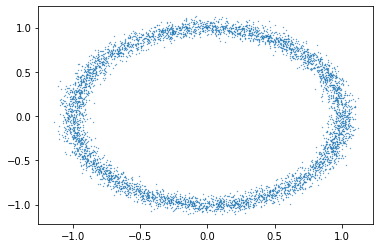

In [ ]:
x = gs.circle()
plt.scatter(x[:, 0], x[:, 1], s=0.1)

In [ ]:
rltx = gs.rlts(x, n=100, L_0=32, i_max=10, gamma=1.0/8)

Done 0/100
Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100


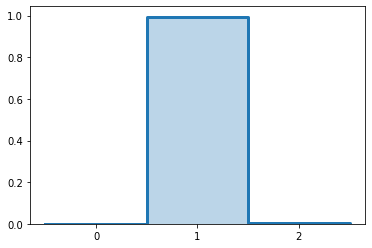

In [ ]:
mrltx = np.mean(rltx, axis=0)
gs.fancy_plot(mrltx[:3])
plt.xticks(np.arange(3));

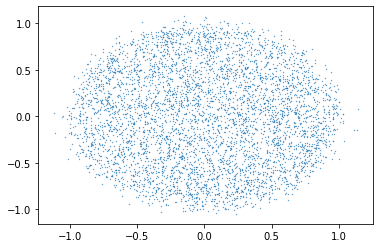

In [ ]:
# Get a second dataset for comparison...

y = gs.filled_circle()
plt.scatter(y[:, 0], y[:, 1], s=0.1)

In [ ]:
rlty = gs.rlts(y, n=100, L_0=32, i_max=10, gamma=1.0/8)

Done 0/100
Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100


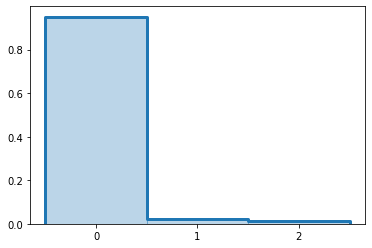

In [ ]:
mrlty = np.mean(rlty, axis=0)
gs.fancy_plot(mrlty[:3])
plt.xticks(np.arange(3));

In [ ]:
# Compute score
gs.geom_score(rltx, rlty)

1.8534918319930305

#### KLD

- non so se può essere utile ma c'è questo link che fa uso di Scipy 
[link](https://machinelearningmastery.com/divergence-between-probability-distributions/) , l'ho provato ad implementare 

In [ ]:
#https://torchmetrics.readthedocs.io/en/stable/classification/kl_divergence.html ++++

#https://machinelearningmastery.com/divergence-between-probability-distributions/

#https://stackoverflow.com/questions/49886369/kl-divergence-for-two-probability-distributions-in-pytorch  +++++++

#https://pytorch.org/docs/stable/generated/torch.nn.functional.kl_div.html



'''LOG PROBABILITIES INFOs - servono delle probabilità per calcolare il KL-DIV, quindi forse prima tocca allenare pure il classificatore, e dare le probabilità come input in formato vettoriale, altrimenti i conti non tornano'''

#https://stackoverflow.com/questions/58742766/how-to-get-log-probabilities-in-tensorflow

#https://machinelearningmastery.com/divergence-between-probability-distributions/

#https://discuss.pytorch.org/t/how-to-extract-probabilities/2720

#https://stackoverflow.com/questions/58766519/how-to-get-probability-of-each-image-belonging-to-a-class

#https://discuss.pytorch.org/t/kl-divergence-for-multi-label-classification/118884/2




import torch.nn.functional as F

'''prova calcolo KL-div - alternativa 1''' #DOVREBBE ESSERE L'ALTERNATIVA PIÙ CORRETTA
P = torch.Tensor([0.36, 0.48, 0.16])
Q = torch.Tensor([0.333, 0.333, 0.333])

(P * (P / Q).log()).sum()
# tensor(0.0863), 10.2 µs ± 508

ris1 = F.kl_div(Q.log(), P, None, None, 'sum')
# tensor(0.0863), 14.1 µs ± 408 ns
print(ris1)

'''prova calcolo KL-div - alternativa 2'''
ris2 = F.kl_div(P, Q)
print(ris2)



tensor(0.0863)
tensor(-0.4772)


In [ ]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.rel_entr.html

# example of calculating the kl divergence (relative entropy) with scipy
from scipy.special import rel_entr
# define distributions
#p = [0.10, 0.40, 0.50]
#q = [0.80, 0.15, 0.05]

p = [0.36, 0.48, 0.16]
q = [0.333, 0.333, 0.333]

# calculate (P || Q)
kl_pq = rel_entr(p, q)
print('KL(P || Q): %.3f nats' % sum(kl_pq))
# calculate (Q || P)
kl_qp = rel_entr(q, p)
print('KL(Q || P): %.3f nats' % sum(kl_qp))


KL(P || Q): 0.086 nats
KL(Q || P): 0.096 nats


In [ ]:
from math import log2
# calculate the kl divergence
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

# calculate the js divergence
def js_divergence(p, q):
	m = 0.5 * (p + q)
	return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [ ]:
print(kl_divergence(q,p))

print(kl_divergence(p,q))

0.13901528369128108
0.1245047286814874


##QUALITATIVE METRIC - NEAREST NEIGHBOR 

####NEAREST NEIGHBOR

In [ ]:
#Another popular approach for subjectively summarizing generator performance is “Nearest Neighbors.” This involves selecting examples of real images from the domain and locating one or more most similar generated images for comparison.

#Distance measures, such as Euclidean distance between the image pixel data, is often used for selecting the most similar generated images


'''cerca di implementare un Nearest neighbor e capire come applicarlo al generatore, altrimenti metriche sono sufficienti'''


'cerca di implementare un Nearest neighbor e capire come applicarlo al generatore, altrimenti metriche sono sufficienti'

## TESTING MODEL GAN - MULTIPLE GAN ARCHITECTURES

In [ ]:
os.chdir(path_images)

####APPOGGIO DI UNA VERSIONE DIVERSA DI WGAN-GP (ATTUALMENTE NON FUNZIONANTE)

In [ ]:
'''
#VERSIONE DIVERSA DI GENERATORE E DISCRIMINATORE

# qui ci sono anche altri link con diverse architteture 
# https://github.com/EmilienDupont/wgan-gp/tree/ef82364f2a2ec452a52fbf4a739f95039ae76fe3 

class Generator(nn.Module):
    def __init__(self, img_size, latent_dim, dim):
        super(Generator, self).__init__()

        self.dim = dim
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.feature_sizes = (self.img_size[0] / 1, self.img_size[1] / 1)
        
        self.latent_to_features = nn.Sequential(
            nn.Linear(latent_dim, 8 * dim * int(self.feature_sizes[0]) * int(self.feature_sizes[1])),
            nn.ReLU()
        )

        self.features_to_image = nn.Sequential(
            nn.ConvTranspose2d(8 * dim, 4 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(4 * dim),
            nn.ConvTranspose2d(4 * dim, 2 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(2 * dim),
            nn.ConvTranspose2d(2 * dim, dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(dim),
            nn.ConvTranspose2d(dim, self.img_size[2], 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        # Map latent into appropriate size for transposed convolutions
        x = self.latent_to_features(input_data)
        # Reshape
        x = x.view(-1, 8 * self.dim, int(self.feature_sizes[0]), int(self.feature_sizes[1]))
        # Return generated image
        return self.features_to_image(x)

    def sample_latent(self, num_samples):
        return torch.randn((num_samples, self.latent_dim))


class Discriminator(nn.Module):
    def __init__(self, img_size, dim):
        """
        img_size : (int, int, int)
            Height and width must be powers of 2.  E.g. (32, 32, 1) or
            (64, 128, 3). Last number indicates number of channels, e.g. 1 for
            grayscale or 3 for RGB
        """
        super(Discriminator, self).__init__()

        self.img_size = img_size

        self.image_to_features = nn.Sequential(
            nn.Conv2d(self.img_size[2], dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim, 2 * dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(2 * dim, 4 * dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(4 * dim, 8 * dim, 4, 2, 1),
            nn.Sigmoid()
        )

        # 4 convolutions of stride 2, i.e. halving of size everytime
        # So output size will be 8 * (img_size / 2 ^ 4) * (img_size / 2 ^ 4)
        output_size = 8 * dim * int(img_size[0] / 16) * int(img_size[1] / 16)
        self.features_to_prob = nn.Sequential(
            nn.Linear(output_size, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        batch_size = input_data.size()[0]
        x = self.image_to_features(input_data)
        x = x.view(batch_size, -1)
        return self.features_to_prob(x)


  img_size = (270, 470, 3)
  generator = Generator(img_size=img_size, latent_dim=100, dim=16)
  discriminator = Discriminator(img_size=img_size, dim=16)

'''

'\n#VERSIONE DIVERSA DI GENERATORE E DISCRIMINATORE\n\n# qui ci sono anche altri link con diverse architteture \n# https://github.com/EmilienDupont/wgan-gp/tree/ef82364f2a2ec452a52fbf4a739f95039ae76fe3 \n\nclass Generator(nn.Module):\n    def __init__(self, img_size, latent_dim, dim):\n        super(Generator, self).__init__()\n\n        self.dim = dim\n        self.latent_dim = latent_dim\n        self.img_size = img_size\n        self.feature_sizes = (self.img_size[0] / 1, self.img_size[1] / 1)\n        \n        self.latent_to_features = nn.Sequential(\n            nn.Linear(latent_dim, 8 * dim * int(self.feature_sizes[0]) * int(self.feature_sizes[1])),\n            nn.ReLU()\n        )\n\n        self.features_to_image = nn.Sequential(\n            nn.ConvTranspose2d(8 * dim, 4 * dim, 4, 2, 1),\n            nn.ReLU(),\n            nn.BatchNorm2d(4 * dim),\n            nn.ConvTranspose2d(4 * dim, 2 * dim, 4, 2, 1),\n            nn.ReLU(),\n            nn.BatchNorm2d(2 * dim),\n     

##### (WGAN-GP) 

In [ ]:
'''
opt = [["n_epochs - 0", "batch_size - 1", "lr - 2", "b1 - 3", "b2 - 4", "n_cpu - 5", "latent_dim - 6", "img_size - 7", "channels - 8", "n_critic - 9", "clip_value - 10", "sample_interval - 11"],
       [2000,            64,               0.0002,   0.5,      0.999,    8,           100,              135,             1,              4,              0.01,              200]]

img_shape = (opt[1][8], opt[1][7],  235)
#print(*img_shape)

cuda = True if torch.cuda.is_available() else False


os.makedirs("images", exist_ok=True)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block( opt[1][6], 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        #print(img.shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity




# Loss weight for gradient penalty
lambda_gp = 10

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()


print(generator)
print(discriminator)


if cuda:
    generator.cuda()
    discriminator.cuda()

#generator.to(device)
#discriminator.to(device)

#VALUTA SE CONFIGURARE ANCHE IL SALVATAGGIO DELLE IMMAGINI DIRETTAMENTE SU DRIVE PER QUELLE CHE CREA IL 'GENERATOR'
#PROBABILMENTE SERVIRÀ PERCHE A NOI SERVONO LE IMMAGINI COME DATA AUGMENTATION, QUINDI O LE SALVIAMO PRIMA E POI CI FACCIAMO IL LOAD, OPPURE PENSA COME COMBINARE INSIEME QUESTA FASE CON QUELLA DI ALLENAMENTO DELLA RETE VERA E PROPRIA
'''
# Configure data loader per immagini di dataset MNIST (usato per prova)
'''
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize( opt[1][7]), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size= opt[1][1],
    shuffle=True,
)
'''
'''
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr= opt[1][2], betas=( opt[1][3],  opt[1][4]))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr= opt[1][2], betas=( opt[1][3],  opt[1][4]))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
'''

'\n# Optimizers\noptimizer_G = torch.optim.Adam(generator.parameters(), lr= opt[1][2], betas=( opt[1][3],  opt[1][4]))\noptimizer_D = torch.optim.Adam(discriminator.parameters(), lr= opt[1][2], betas=( opt[1][3],  opt[1][4]))\n\nTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor\n'

In [ ]:
'''
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty
'''

'\ndef compute_gradient_penalty(D, real_samples, fake_samples):\n    """Calculates the gradient penalty loss for WGAN GP"""\n    # Random weight term for interpolation between real and fake samples\n    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))\n    # Get random interpolation between real and fake samples\n    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)\n    d_interpolates = D(interpolates)\n    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)\n    # Get gradient w.r.t. interpolates\n    gradients = autograd.grad(\n        outputs=d_interpolates,\n        inputs=interpolates,\n        grad_outputs=fake,\n        create_graph=True,\n        retain_graph=True,\n        only_inputs=True,\n    )[0]\n    gradients = gradients.view(gradients.size(0), -1)\n    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()\n    return gradient_penalty\n'

In [ ]:
'''
# ----------
#  Training
# ----------
gan_history = {}
gan_history['DLOSS'] = []
gan_history['GLOSS'] = []
gan_history['EPOCH'] = []

batches_done = 0
for epoch in range( opt[1][0]):
    #for i, (imgs, _) in enumerate(trainloader):
    for i, (data, targets, targets2) in tqdm(enumerate(trainloader)):#, desc = 'Epoch : {} train batch'.format(epoch+1)):
        data = data.to(device=device)
        targets = targets.to(device = device) #classes
        targets2 = targets2.to(device = device) #series

        # Configure input
        real_imgs = Variable(data.type(Tensor))
        ###print(real_imgs.shape)
        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()
        
        z = Variable(Tensor(np.random.normal(0, 0, (data.shape[0],  opt[1][6])))) 
        #z = Variable(Tensor(np.random.normal(0, 0.5, (data.shape[0],  opt[1][6])))) #altro prova per ridurre il rumore 

        # Generate a batch of images
        fake_imgs = generator(z)
        ###print(fake_imgs.shape)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        
        
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i %  opt[1][9] == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch,  opt[1][0], i, len(trainloader), d_loss.item(), g_loss.item())
            )

            if batches_done %  opt[1][11] == 0:

                save_image(fake_imgs.data[:1], "images/new_%d.png" % batches_done, nrow=1, normalize=True)
                ########################################################################            
        
                img_to_save =  fake_imgs.data[:1]
                print(img_to_save.shape)   

                                
                img_to_save2 = gray2rgb(img_to_save)                             #ULTIMA PROVA FATTA PER SALVARE A COLORI - bisogna trasformarlo in tensore per poi poterlo salvare !!!
                tensor = torch.from_numpy(img_to_save2)
                print(tensor.shape)

                print(img_to_save2.shape)                                                     
                
                save_image(img_to_save, "images/new1_%d.png" % batches_done, nrow=1, normalize=True)
                save_image(tensor, "images/new2_%d.png" % batches_done, nrow=1, normalize=True)

                #########################################################################

            batches_done +=  opt[1][9]

    print('------------------------------------------------------------')
    print(
        "[Epoch %d/%d][D loss: %f] [G loss: %f]"
        % (epoch,  opt[1][0], d_loss.item(), g_loss.item())
    )
    print('------------------------------------------------------------')
    gan_history['DLOSS'].append(d_loss.item())
    gan_history['GLOSS'].append(g_loss.item()) 
    gan_history['EPOCH'].append(epoch)
'''

'\n# ----------\n#  Training\n# ----------\ngan_history = {}\ngan_history[\'DLOSS\'] = []\ngan_history[\'GLOSS\'] = []\ngan_history[\'EPOCH\'] = []\n\nbatches_done = 0\nfor epoch in range( opt[1][0]):\n    #for i, (imgs, _) in enumerate(trainloader):\n    for i, (data, targets, targets2) in tqdm(enumerate(trainloader)):#, desc = \'Epoch : {} train batch\'.format(epoch+1)):\n        data = data.to(device=device)\n        targets = targets.to(device = device) #classes\n        targets2 = targets2.to(device = device) #series\n\n        # Configure input\n        real_imgs = Variable(data.type(Tensor))\n        ###print(real_imgs.shape)\n        # ---------------------\n        #  Train Discriminator\n        # ---------------------\n\n        optimizer_D.zero_grad()\n        \n        z = Variable(Tensor(np.random.normal(0, 0, (data.shape[0],  opt[1][6])))) \n        #z = Variable(Tensor(np.random.normal(0, 0.5, (data.shape[0],  opt[1][6])))) #altro prova per ridurre il rumore \n\n       

#### (SOFTMAX) - GAN 

In [ ]:
'''
opt = [["n_epochs - 0", "batch_size - 1", "lr - 2", "b1 - 3", "b2 - 4", "n_cpu - 5", "latent_dim - 6", "img_size - 7", "channels - 8", "n_critic - 9", "clip_value - 10", "sample_interval - 11"],
       [2000,            64,               0.0002,   0.5,      0.999,    8,           100,              100,             1,              4,              0.01,              200]]

import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)
'''
'''
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
opt = parser.parse_args()
print(opt)
'''
'''

img_shape = (opt[1][8], opt[1][7],  opt[1][7])

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt[1][6], 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        print(img_flat.shape)
        validity = self.model(img_flat)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()



# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt[1][2], betas=( opt[1][3],  opt[1][4]))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt[1][2], betas=( opt[1][3],  opt[1][4]))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


def log(x):
    return torch.log(x + 1e-8)

# ----------
#  Training
# ----------

gan_history = {}
gan_history['DLOSS'] = []
gan_history['GLOSS'] = []
gan_history['EPOCH'] = []

for epoch in range( opt[1][0]):
    for i, (data, targets, targets2) in tqdm(enumerate(trainloader)):

        data = data.to(device=device)
        targets = targets.to(device = device) #classes
        targets2 = targets2.to(device = device) #series

        optimizer_G.zero_grad()
        optimizer_D.zero_grad()

        batch_size = data.shape[0]

        # Adversarial ground truths
        g_target = 1 / (batch_size * 2)
        d_target = 1 / batch_size

        # Configure input
        real_imgs = Variable(data.type(Tensor))

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (data.shape[0], opt[1][6]))))
        # Generate a batch of images
        gen_imgs = generator(z)

        d_real = discriminator(real_imgs)
        d_fake = discriminator(gen_imgs)

        # Partition function
        Z = torch.sum(torch.exp(-d_real)) + torch.sum(torch.exp(-d_fake))

        # Calculate loss of discriminator and update
        d_loss = d_target * torch.sum(d_real) + log(Z)
        



        # Calculate loss of generator and update
        g_loss = g_target * (torch.sum(d_real) + torch.sum(d_fake)) + log(Z)


        d_loss.backward(retain_graph=True)
        g_loss.backward()

        optimizer_G.step()
        optimizer_D.step()


        #print(
        #    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        #    % (epoch, opt[1][0], i, len(trainloader), d_loss.item(), g_loss.item())
        #)

        batches_done = epoch * len(trainloader) + i
        if batches_done % opt[1][11] == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

    print('------------------------------------------------------------')
    print(
      "[Epoch %d/%d][D loss: %f] [G loss: %f]"
      % (epoch,  opt[1][0], d_loss.item(), g_loss.item())
    )
    print('------------------------------------------------------------')
    
    gan_history['DLOSS'].append(d_loss.item())
    gan_history['GLOSS'].append(g_loss.item()) 
    gan_history['EPOCH'].append(epoch)
'''

'\n\nimg_shape = (opt[1][8], opt[1][7],  opt[1][7])\n\ncuda = True if torch.cuda.is_available() else False\n\n\nclass Generator(nn.Module):\n    def __init__(self):\n        super(Generator, self).__init__()\n\n        def block(in_feat, out_feat, normalize=True):\n            layers = [nn.Linear(in_feat, out_feat)]\n            if normalize:\n                layers.append(nn.BatchNorm1d(out_feat, 0.8))\n            layers.append(nn.LeakyReLU(0.2, inplace=True))\n            return layers\n\n        self.model = nn.Sequential(\n            *block(opt[1][6], 128, normalize=False),\n            *block(128, 256),\n            *block(256, 512),\n            *block(512, 1024),\n            nn.Linear(1024, int(np.prod(img_shape))),\n            nn.Tanh()\n        )\n\n    def forward(self, z):\n        img = self.model(z)\n        img = img.view(img.shape[0], *img_shape)\n        return img\n\n\nclass Discriminator(nn.Module):\n    def __init__(self):\n        super(Discriminator, self).__in

#### (DC GAN)

In [ ]:
'''
opt = [["n_epochs - 0", "batch_size - 1", "lr - 2", "b1 - 3", "b2 - 4", "n_cpu - 5", "latent_dim - 6", "img_size - 7", "channels - 8", "n_critic - 9", "clip_value - 10", "sample_interval - 11"],
       [2000,            8,               0.0002,   0.5,      0.999,    8,           1,              128*2,             1,              4,              0.01,              100]]

gan_history = {}
gan_history['DLOSS'] = []
gan_history['GLOSS'] = []
gan_history['EPOCH'] = []

import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

cuda = True if torch.cuda.is_available() else False

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt[1][7] // 4
        self.l1 = nn.Sequential(nn.Linear(opt[1][6], 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            #nn.LeakyReLU(0.2, inplace=True),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            #nn.LeakyReLU(0.2, inplace=True),
            nn.ReLU(),
            nn.Conv2d(64, opt[1][8], 3, stride=1, padding=1),
            #nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), 
                     #nn.LeakyReLU(0.2, inplace=True),
                     nn.ReLU(),
                     nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt[1][8], 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt[1][7] // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity
 




# Loss function
adversarial_loss = torch.nn.MSELoss() #era BCELoss()



generator = Generator() #
discriminator = Discriminator()
print(generator)
print(discriminator)

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
#generator.apply(weights_init_normal)
#discriminator.apply(weights_init_normal)

# Optimizers
#optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt[1][2], betas=( opt[1][3],  opt[1][4]))
optimizer_G = optim.SGD(model.parameters(), weight_decay=1e-5, lr=0.001, momentum=0.8)
#optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt[1][2], betas=( opt[1][3],  opt[1][4]))
optimizer_D = optim.SGD(model.parameters(), weight_decay=1e-5, lr=0.001, momentum=0.8)
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------


for epoch in range( opt[1][0]):
    for i, (data, targets, targets2) in tqdm(enumerate(trainloader)):

        data = data.to(device=device)
        targets = targets.to(device = device) #classes
        targets2 = targets2.to(device = device) #series

        # Adversarial ground truths
        valid = Variable(Tensor(data.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(data.shape[0], 1).fill_(0.0), requires_grad=False)


        # Configure input
        real_imgs = Variable(data.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 0.5, (data.shape[0], opt[1][6]))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    print(
        "[Epoch %d/%d][D loss: %f] [G loss: %f]"
        % (epoch, opt[1][0], d_loss.item(), g_loss.item())
    )

    batches_done = epoch * len(trainloader) + i
    if batches_done % opt[1][11] == 0:
        save_image(gen_imgs.data[:1], "images/%d.png" % batches_done, nrow=5, normalize=True)    

    gan_history['DLOSS'].append(d_loss.item())
    gan_history['GLOSS'].append(g_loss.item()) 
    gan_history['EPOCH'].append(epoch)
'''

'\nopt = [["n_epochs - 0", "batch_size - 1", "lr - 2", "b1 - 3", "b2 - 4", "n_cpu - 5", "latent_dim - 6", "img_size - 7", "channels - 8", "n_critic - 9", "clip_value - 10", "sample_interval - 11"],\n       [2000,            8,               0.0002,   0.5,      0.999,    8,           1,              128*2,             1,              4,              0.01,              100]]\n\ngan_history = {}\ngan_history[\'DLOSS\'] = []\ngan_history[\'GLOSS\'] = []\ngan_history[\'EPOCH\'] = []\n\nimport argparse\nimport os\nimport numpy as np\nimport math\n\nimport torchvision.transforms as transforms\nfrom torchvision.utils import save_image\n\nfrom torch.utils.data import DataLoader\nfrom torchvision import datasets\nfrom torch.autograd import Variable\n\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport torch\n\nos.makedirs("images", exist_ok=True)\n\ncuda = True if torch.cuda.is_available() else False\n\ndef weights_init_normal(m):\n    classname = m.__class__.__name__\n    if classna

#### (WPGAN - DIV) 

In [ ]:
'''
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch


opt = [["n_epochs - 0", "batch_size - 1", "lr - 2", "b1 - 3", "b2 - 4", "n_cpu - 5", "latent_dim - 6", "img_size - 7", "channels - 8", "n_critic - 9", "clip_value - 10", "sample_interval - 11"],
       [2000,            8,               0.0002,   0.5,      0.999,    8,           1,              128*2,             1,              4,              0.01,              100]]

gan_history = {}
gan_history['DLOSS'] = []
gan_history['GLOSS'] = []
gan_history['EPOCH'] = []


os.makedirs("images", exist_ok=True)

img_shape = (opt[1][8], opt[1][7], opt[1][7])

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt[1][6], 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


k = 2
p = 6


# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()


# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt[1][2], betas=( opt[1][3],  opt[1][4]))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt[1][2], betas=( opt[1][3],  opt[1][4]))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

batches_done = 0
for epoch in range( opt[1][0]):
    for i, (data, targets, targets2) in tqdm(enumerate(trainloader)):

        data = data.to(device=device)
        targets = targets.to(device = device) #classes
        targets2 = targets2.to(device = device) #series


        # Configure input
        real_imgs = Variable(data.type(Tensor), requires_grad=True)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (data.shape[0], opt[1][6]))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)

        # Compute W-div gradient penalty
        real_grad_out = Variable(Tensor(real_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        real_grad = autograd.grad(
            real_validity, real_imgs, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        fake_grad_out = Variable(Tensor(fake_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_grad = autograd.grad(
            fake_validity, fake_imgs, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2

        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + div_gp

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % opt[1][9] == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

    print(
        "[Epoch %d/%d][D loss: %f] [G loss: %f]"
        % (epoch, opt[1][0], d_loss.item(), g_loss.item())
    )

    batches_done = epoch * len(trainloader) + i
    if batches_done % opt[1][11] == 0:
        save_image(fake_imgs.data[:1], "images/%d.png" % batches_done, nrow=5, normalize=True)    

    gan_history['DLOSS'].append(d_loss.item())
    gan_history['GLOSS'].append(g_loss.item()) 
    gan_history['EPOCH'].append(epoch)

'''

'\nimport argparse\nimport os\nimport numpy as np\nimport math\nimport sys\n\nimport torchvision.transforms as transforms\nfrom torchvision.utils import save_image\n\nfrom torch.utils.data import DataLoader\nfrom torchvision import datasets\nfrom torch.autograd import Variable\n\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport torch.autograd as autograd\nimport torch\n\n\nopt = [["n_epochs - 0", "batch_size - 1", "lr - 2", "b1 - 3", "b2 - 4", "n_cpu - 5", "latent_dim - 6", "img_size - 7", "channels - 8", "n_critic - 9", "clip_value - 10", "sample_interval - 11"],\n       [2000,            8,               0.0002,   0.5,      0.999,    8,           1,              128*2,             1,              4,              0.01,              100]]\n\ngan_history = {}\ngan_history[\'DLOSS\'] = []\ngan_history[\'GLOSS\'] = []\ngan_history[\'EPOCH\'] = []\n\n\nos.makedirs("images", exist_ok=True)\n\nimg_shape = (opt[1][8], opt[1][7], opt[1][7])\n\ncuda = True if torch.cuda.is_availab

#### GAN - QUELLO FUNZIONANTE 
(https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py)

##### GAN ORIGINALE (SENZA OPTUNA)

In [ ]:
"""
'''stampa degli istogrammi delle immagini reali'''

cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


dataloader = trainloader
for i, (data, targets, targets2) in tqdm(enumerate(dataloader)):

        data = data.to(device=device)
        targets = targets.to(device = device) #classes
        targets2 = targets2.to(device = device) #series


        # Adversarial ground truths
        valid = Variable(Tensor(data.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(data.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(data.type(Tensor))
        for counter in range(len(real_imgs)):
          x = torch.histc(real_imgs.data[counter], bins=4)
          #print(x[1])
          print(torch.histc(real_imgs.data[counter], bins=4))




'''------------------------------------------------------------DA FARE-----------------------------------------------------------------------------------------------------------------------------------------------'''
  #PROVA A CALCOLARE LA METRICA MMD TRA BATCH INTERO DI REALI E SINGOLA IMMAGINE GENERATA CICLANDO.

  #OPPURE CALCOLA L'ISTOGRAMMA PER TUTTE LE IMMAGINI REALI E VEDI I VALORI DI RIFERIMENTO CHE DEVONO AVERE PER FARE LE CONDIZIONI DI SALVATAGGIO DI IMMAGINE SOPRA
'''-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
"""

"\n'''stampa degli istogrammi delle immagini reali'''\n\ncuda = True if torch.cuda.is_available() else False\n\nTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor\n\n\ndataloader = trainloader\nfor i, (data, targets, targets2) in tqdm(enumerate(dataloader)):\n\n        data = data.to(device=device)\n        targets = targets.to(device = device) #classes\n        targets2 = targets2.to(device = device) #series\n\n\n        # Adversarial ground truths\n        valid = Variable(Tensor(data.size(0), 1).fill_(1.0), requires_grad=False)\n        fake = Variable(Tensor(data.size(0), 1).fill_(0.0), requires_grad=False)\n\n        # Configure input\n        real_imgs = Variable(data.type(Tensor))\n        for counter in range(len(real_imgs)):\n          x = torch.histc(real_imgs.data[counter], bins=4)\n          #print(x[1])\n          print(torch.histc(real_imgs.data[counter], bins=4))\n\n\n\n\n'''------------------------------------------------------------DA FARE------------------

In [ ]:
"""


'''ADDESTRAMENTO GAN



NOTE PER LE MODIFICHE DEGLI  HYPERPARAMETRI DURANTE LA FASE DI TEST DELLA GAN PER MIGLIOR SETTAGGIO


########################
MODE COLLAPSE = il generatore produce solo pochi dettagli, quindi DIVERSITÀ BASSA (SE METRICHE DIVERSITÀ AVRANNO VALORE BASSO) = C'È OSCILLAZIONE NELLA LOSS DEL GENERATORE TIPICAMENTE (DISCRIMINATOR RICONOSCE CHE SONO FINTE)

- LEARNING RATE: modificare il learning rate solo abbassandolo (se immagini non hanno molti dettagli)

- LATENT SPACE : come per il caso precedente, (abbassandolo diminuiamo l'insieme dei possibili output che genera ogni iterazione e quindi non si allena molto in diversità)

########################



########################
CONVERGENCE FAILURE = quando la loss non fa al caso del modello utilizzato di generatore, e che con le immagini che si stanno usando la LOSS GENERATORE OSCILLA/HA VALORI ALTI/CONTINUA A CRESCERE e/o LOSS DISCIMINATORE TENDE A 0

- LOSS TYPE: modificarla potrebbe migliorare la generazione 

- MODIFICARE LA CAPACITÀ DEI LAYERS DEL MODELLO: aumentare la dimensione dei layers potrebbe aumentare la QUALITÀ del risultato
########################
'''


import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch




os.makedirs("images", exist_ok=True)
os.makedirs("images_to_check", exist_ok=True)

gan_history = {}
gan_history['DLOSS'] = []
gan_history['GLOSS'] = []
gan_history['MMD'] = []
gan_history['SSIM'] = []
gan_history['EPOCH'] = []

opt = [["n_epochs - 0", "batch_size - 1", "lr - 2", "b1 - 3", "b2 - 4", "n_cpu - 5", "latent_dim - 6", "img_size - 7", "channels - 8", "n_critic - 9", "clip_value - 10", "sample_interval - 11"],
      [2500,              32,                0.0002,   0.5,      0.999,    8,           100,                128*2,             3,              4,              0.01,              20]]

'''
opt = [["n_epochs - 0", "batch_size - 1", "lr - 2", "b1 - 3", "b2 - 4", "n_cpu - 5", "latent_dim - 6", "img_size - 7", "channels - 8", "n_critic - 9", "clip_value - 10", "sample_interval - 11"],
      [2000,              64,                0.0002,   0.5,      0.999,    8,           100,                128*2,             3,              4,              0.01,              20]]
'''


#inutile cambiare il batch_size, perchè tanto prende quello dato al DataLoader!!!!!!
#print("ok {} ".format(config))


img_shape = (opt[1][8], 270, 470)


cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


#print(opt[1][7])

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt[1][6], 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod([img_shape]))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()

#hl.build_graph(generator, torch.zeros([3, 3, 270, 470]))

discriminator = Discriminator()

#hl.build_graph(discriminator, torch.zeros([3, 3, 270, 470]))

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
dataloader = trainloader

# ---------Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt[1][2], betas=( opt[1][3],  opt[1][4]))
#optimizer_G = torch.optim.Adam(generator.parameters(), lr=config['lr_'], betas=(config["b1_"],  config["b2_"]))

optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt[1][2], betas=( opt[1][3],  opt[1][4]))
#optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=config['lr_'], betas=(config["b1_"],  config["b2_"]))

#---------
#optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=0.00002) #VA MA NON CREA IMMAGINI MOLTO BUONE

#optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=0.00002) #VA MA NON CREA IMMAGINI MOLTO BUONE






# ----------
#  Training
# ----------


#--------------------parametri per calcolare NDB score-----------------

batches_done = 0
contatore_stabilita = 0
real_batches = [] #to save real images to be used with NDB METRIC
generated_batches = [] #to save real images to be used with NDB METRIC
iters = 0
img_list = []
metrics = []
ndb_scores = []
real_batches2 = []
real_batches_np = 0
real_batches2_np = 0
real_concatenate = 0

#per metrica FID
BatchSize = 8 
UseMultiprocessing = False 


'''estrazione batch di immagini reali per NDB'''


for i, (data, targets, targets2) in tqdm(enumerate(trainloader)):

    #- MEMORIZZO IL SET DI IMMAGINI REALI PER USARLO NELLA METRICA 'NDB' -
    real = data.numpy()
    if len(trainloader)==1:
      real_batches.append(real)
      real_concatenate = np.array(real_batches)
    else:
      if i==0:
        real_batches.append(real)
        real_batches_np = np.array(real_batches)
        print(real_batches_np.shape)
        real_batches = []
      if i==1:
        real_batches.append(real)
        real_batches2_np = np.array(real_batches)
        print(real_batches2_np.shape)
        real_batches = []
        real_concatenate = np.concatenate((real_batches_np,real_batches2_np), axis=1)
      if i>1:
        real_batches.append(real)
        real_batches2_np = np.array(real_batches)
        print(real_batches2_np.shape)
        real_batches = []
        real_concatenate = np.concatenate((real_concatenate,real_batches2_np), axis=1)
    

#RIADATTAMENTO DELLE IMMAGINI REALI & GENERATE PER METRICA 'NDB'
#real_batches = np.array(real_batches)
real_batches = real_concatenate

#print(real_batches)
#print(real_batches.shape)
#print(len(real_batches))

#Display a sample
#plt.imshow(np.transpose(real_batches[0][0], (1,2,0)))

real_combined = real_batches.reshape(numTrainBatches*len(df_class_new), 3, img_shape[1], img_shape[2])  #IL PRIMO PARAMETRO SARÀ DA CAMBIARE FORSE QUANDO AVREMO PIÙ IMMAGINI SE NON TORNA IL CONTO
#real_combined = real_batches.reshape(numTrainBatches*len(df_class_new), 3, opt[1][7], opt[1][7])  #IL PRIMO PARAMETRO SARÀ DA CAMBIARE FORSE QUANDO AVREMO PIÙ IMMAGINI SE NON TORNA IL CONTO


del real_batches
gc.collect()
real_batches = []
real_batches_np = []

'''alternativa'''
#real_combined = real_samples(numTrainBatches, trainloader, nc, opt[1][7])
'''----------------------------------------------------------------------'''   


#il KERNEL_TYPE = "rbf" serve per il MMD 
KERNEL_TYPE = "rbf"

for epoch in range( opt[1][0]):
    for i, (data, targets, targets2) in tqdm(enumerate(dataloader)):

        data = data.to(device=device)
        targets = targets.to(device = device) #classes
        targets2 = targets2.to(device = device) #series


        # Adversarial ground truths
        valid = Variable(Tensor(data.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(data.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(data.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(5, 10, (data.shape[0], opt[1][6]))))         #PRIMA INVECE DI -5,10- C'ERA -0,1- MA ERA MENO EFFICACE NEL COMPLESSO DEL BATCH

        # Generate a batch of images
        gen_imgs = generator(z)



        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt[1][0], i+1, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        
        #questo per vedere ogni 10 epoche come sono le immagini che genera
        #if batches_done % 100 == 0 : 
          #save_image(gen_imgs.data[:30], "images_batch/{}_{}.png".format(epoch, i+1), nrow=6, normalize=True)

        if d_loss.item() < 1 and d_loss.item() > 0.3 and epoch>=1750 and g_loss.item() < 1.5:
          for counter in range(len(gen_imgs)):
            x = torch.histc(gen_imgs.data[counter], bins=4)
            #if epoch % 10 == 0:
              #print(torch.histc(gen_imgs.data[counter], bins=4))
            
            if x[0]>110000 and x[0]<210000 and x[1]>70000 and x[1]<120000 and x[2]>40000 and x[2]<85000 and x[3]>20000 and x[3]<100000:     #ANALIZZA GLI ISTOGRAMMI SOPRA OTTENUTI DALLE IMMAGINI REALI E VEDI COME CAMBIARE QUA - classe 9 - AUMENTARE RANGE DI ISTOGRAMMA di 20 ogni parte
              save_image(gen_imgs.data[counter], "images9/_{}_{}_{}.png".format(epoch, i+1, counter), nrow=1, normalize=True)                    #---------------------------MODIFICARE SEMPRE IL DATASET CHE SI VUOLE ITERARE DA MODIFICARE IL PERCORSO
              

            '''PARTE DI CALCOLO DELL' MMD'''
            '''
            real_imgs2 =  real_imgs.reshape(real_imgs.shape[0], real_imgs.shape[1]*real_imgs.shape[2]*real_imgs.shape[3])
            #print(real_imgs2.shape)
            #print(type(real_imgs2))

            gen_imgs2 =  gen_imgs.reshape(gen_imgs.shape[0], gen_imgs.shape[1]*gen_imgs.shape[2]*gen_imgs.shape[3])
            #print(gen_imgs2.shape)
            #print(type(gen_imgs2))

            mmd_average = MMD(real_imgs2, gen_imgs2, KERNEL_TYPE, device) #---- aggiungere device nella funzione all'interno dell'file 
            '''

        #------------------------------------------stampo i batch in cartelle e salvo i modelli nei punti di stabilità
        '''
        if epoch >2000  and g_loss<1.5:  #epoch>1750 quasi sempre con batch da 64, anche con batch da 96 (32*3)
          
          if contatore_stabilita >=5 and d_loss>0.30:
            torch.save(generator.state_dict(),'/content/drive/MyDrive/CALCIO_CROP_BASE/models/model_generator_4_{}.pth'.format(epoch))                      #---------------------------MODIFICARE SEMPRE IL DATASET CHE SI VUOLE ITERARE DA MODIFICARE IL PERCORSO
            #torch.save(discriminator.state_dict(),'/content/drive/MyDrive/CALCIO_CROP_BASE/models/model_discriminator_2__{}.pth'.format(epoch))                          #---------------------------MODIFICARE SEMPRE IL DATASET CHE SI VUOLE ITERARE DA MODIFICAR
            contatore_stabilita = 0
            save_image(gen_imgs.data[:30], "images_batch_4/_{}_{}_{}.png".format(epoch, i+1, d_loss.item()), nrow=6, normalize=True)

          if d_loss > 0.25:
            contatore_stabilita = contatore_stabilita + 1
          
          if contatore_stabilita>0 and d_loss<0.25:
            contatore_stabilita = 0
          
        
        if epoch % 25 == 0:
          save_image(gen_imgs.data[:30], "images_batch_2/_{}_{}_{}.png".format(epoch, i+1, d_loss.item()), nrow=6, normalize=True)                        #---------------------------MODIFICARE SEMPRE IL DATASET CHE SI VUOLE ITERARE DA MODIFICARE IL PERCORSO
        '''
        #------------------------------------------

        #SUCCESSIVAMENTE IMPLEMENTARE UN VETTORE CHE MEMORIZZA I VALORI DI LOSS DEL GENERATOR E MEMORIZZARE MODELLO QUANDO LA VARIANZA è BASSA COSì COME QUANDO è IL SUO VALORE BASSO, SOTTO 1.5 (ALMENO)
        #siamo sempre in situazione di mode collapse, ovvero il generator oscilla troppo e non riesce a generare troppa diversità tra le immagini, con qualsiasi dimensione di batch, questo perchè forse ha pochi elementi, ma comunque usando un batch superiore a 64 collassa dopo un pò.
        #provare comunque a verificare in futuro usando le immagini Flippate e Brightness ad usare un batch più grande e capire se riese a generare le immagini con meno epoche e quando più o meno collassa se ha già generato cose di sufficiente qualità

        '''
        #PARTE DI CALCOLO DELL' NDB
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 10 == 0) or ((epoch == opt[1][0]-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            

            #genero fake batches images per calcolare metrica NDB
            gen_combined = generated_fakes(numTestBatches, generator, img_shape[1], img_shape[2], opt[1][6])
      
            #Calculate NDB
            train_size = numTrainBatches*62     #perchè il set ha 62 immagini e non riempe neanche il batch
            test_size = numTestBatches*62
            dim = 270*470*3
            #dim = img_shape[1]*img_shape[2]*3

            train_samples = real_combined.reshape(train_size, dim)
            test_samples = gen_combined.reshape(test_size, dim)
            
            ndb = NDB(training_data=train_samples, number_of_bins=k, whitening=True)
            results = ndb.evaluate(test_samples)
                
            ndb_k = float(results["NDB"])/ndb.number_of_bins
            #wandb.log({"ndb_k" : ndb_k, "JS": results["JS"]})   

        iters += 1


    #memorizzo info su NDB
    #specifically track NDB
    metrics.append(results)
    ndb_scores.append(ndb_k)
    
    #print("NDB_K: ", ndb_k)
    '''

    #--------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------
    

    
    '''
    #PARTE DI CALCOLO DELL' MMD
    #---- Maximum Mean Discrepancy (MMD) (non capisco come farlo funzionare anche con le img a colori, se ti da qualche errore, prova prima a rieseguire il blocco subito sopra -----
    
    real_imgs2 =  real_imgs.reshape(real_imgs.shape[0], real_imgs.shape[1]*real_imgs.shape[2]*real_imgs.shape[3])
    #print(real_imgs2.shape)
    #print(type(real_imgs2))

    gen_imgs2 =  gen_imgs.reshape(gen_imgs.shape[0], gen_imgs.shape[1]*gen_imgs.shape[2]*gen_imgs.shape[3])
    #print(gen_imgs2.shape)
    #print(type(gen_imgs2))

    
    #mmd_average = MMD(real_imgs2, gen_imgs2, KERNEL_TYPE, device) #---- aggiungere device nella funzione all'interno dell'file 
    #if epoch > 1000 and epoch % 10 == 0 and mmd_average<2:
    #  print('MMD AVERAGE : {}'.format(mmd_average))
    '''


    '''
    #CALCOLO SSIM DA MONITORARE
    if epoch > 1000 and epoch % 10 == 0:
      #real_combined_ssim = torch.from_numpy(real_combined)
      real = data.numpy()
      real_batches.append(real)
      real_batches_np = np.array(real_batches)
      #print(real_batches_np.shape)
      real_combined_ssim = real_batches_np.reshape(len(data), 3, img_shape[1], img_shape[2])  #IL PRIMO PARAMETRO SARÀ DA CAMBIARE FORSE QUANDO AVREMO PIÙ IMMAGINI SE NON TORNA IL CONTO
      real_combined_ssim = torch.from_numpy(real_combined_ssim)
      #print(real_combined_ssim.shape)

      #gen_combined_ssim = torch.from_numpy(gen_combined)
      #print(gen_combined_ssim.shape)
    
      #calcolo metrica
      ris_ssim = ssim(real_combined_ssim,gen_imgs)
      real_batches = []

      #print('MMD AVERAGE : {}'.format(mmd_average))
      print("ssim :{}".format(ris_ssim))
      gan_history['SSIM'].append(ris_ssim.item())
      '''
    
    

    


    '''memorizzo info su addestramento GAN'''
    gan_history['DLOSS'].append(d_loss.item())
    gan_history['GLOSS'].append(g_loss.item()) 
    gan_history['EPOCH'].append(epoch)
    #gan_history['MMD'].append(mmd_average.item())
    


        



'''As such, the practice of systematically generating images and saving models during training can and should continue to be used to allow post-hoc model selection'''

'''CONVIENE SALVARE I MODELLI GENERATORE E DISCRIMINATORE, PERCHÈ POTREBBE AVERE I SUOI MASSIMI DI RISULTATI ANCHE IN MEZZO ALL'ALLENAMENTO'''

'''
classe 0 - ok - if  x[0]>40000 and x[0]<180000 and x[1]>60000 and x[1]<130000 and x[2]>55000 and x[2]<100000 and x[3]>10000 and x[3]<2000000:     #ANALIZZA GLI ISTOGRAMMI SOPRA OTTENUTI DALLE IMMAGINI REALI E VEDI COME CAMBIARE QUA - classe 0 - AUMENTARE RANGE DI ISTOGRAMMA di 20 ogni parte
classe 1 - ok - if x[0]>80000 and x[0]<200000 and x[1]>50000 and x[1]<150000 and x[2]>50000 and x[2]<100000 and x[3]>10000 and x[3]<150000:     #ANALIZZA GLI ISTOGRAMMI SOPRA OTTENUTI DALLE IMMAGINI REALI E VEDI COME CAMBIARE QUA - classe 1 - AUMENTARE RANGE DI ISTOGRAMMA di 20 ogni parte
classe 2 - ok - if x[0]>50000 and x[0]<220000 and x[1]>60000 and x[1]<130000 and x[2]>45000 and x[2]<100000 and x[3]>10000 and x[3]<130000:     #ANALIZZA GLI ISTOGRAMMI SOPRA OTTENUTI DALLE IMMAGINI REALI E VEDI COME CAMBIARE QUA - classe 2 - AUMENTARE RANGE DI ISTOGRAMMA di 20 ogni parte
classe 3 - ok - if x[0]>70000 and x[0]<200000 and x[1]>50000 and x[1]<150000 and x[2]>45000 and x[2]<100000 and x[3]>10000 and x[3]<130000:     #ANALIZZA GLI ISTOGRAMMI SOPRA OTTENUTI DALLE IMMAGINI REALI E VEDI COME CAMBIARE QUA - classe 3 - AUMENTARE RANGE DI ISTOGRAMMA di 20 ogni parte
classe 4 - ok - if x[0]>70000 and x[0]<200000 and x[1]>40000 and x[1]<130000 and x[2]>50000 and x[2]<100000 and x[3]>10000 and x[3]<170000:     #ANALIZZA GLI ISTOGRAMMI SOPRA OTTENUTI DALLE IMMAGINI REALI E VEDI COME CAMBIARE QUA - classe 4 - AUMENTARE RANGE DI ISTOGRAMMA di 20 ogni parte
classe 5 - ok - if x[0]>90000 and x[0]<200000 and x[1]>50000 and x[1]<130000 and x[2]>45000 and x[2]<100000 and x[3]>10000 and x[3]<160000:     #ANALIZZA GLI ISTOGRAMMI SOPRA OTTENUTI DALLE IMMAGINI REALI E VEDI COME CAMBIARE QUA - classe 5 - AUMENTARE RANGE DI ISTOGRAMMA di 20 ogni parte
classe 7 - if x[0]>100000 and x[0]<200000 and x[1]>70000 and x[1]<120000 and x[2]>50000 and x[2]<90000 and x[3]>20000 and x[3]<150000:     #ANALIZZA GLI ISTOGRAMMI SOPRA OTTENUTI DALLE IMMAGINI REALI E VEDI COME CAMBIARE QUA - classe 7 - AUMENTARE RANGE DI ISTOGRAMMA di 20 ogni parte 
classe 8 - ok - if x[0]>100000 and x[0]<200000 and x[1]>80000 and x[1]<140000 and x[2]>40000 and x[2]<85000 and x[3]>20000 and x[3]<120000:     #ANALIZZA GLI ISTOGRAMMI SOPRA OTTENUTI DALLE IMMAGINI REALI E VEDI COME CAMBIARE QUA - classe 8 - AUMENTARE RANGE DI ISTOGRAMMA di 20 ogni parte
classe 9 - ok - if x[0]>110000 and x[0]<210000 and x[1]>70000 and x[1]<120000 and x[2]>40000 and x[2]<85000 and x[3]>20000 and x[3]<100000:     #ANALIZZA GLI ISTOGRAMMI SOPRA OTTENUTI DALLE IMMAGINI REALI E VEDI COME CAMBIARE QUA - classe 9 - AUMENTARE RANGE DI ISTOGRAMMA di 20 ogni parte

'''

"""

'\n\n\n\'\'\'ADDESTRAMENTO GAN\n\n\n\nNOTE PER LE MODIFICHE DEGLI  HYPERPARAMETRI DURANTE LA FASE DI TEST DELLA GAN PER MIGLIOR SETTAGGIO\n\n\n########################\nMODE COLLAPSE = il generatore produce solo pochi dettagli, quindi DIVERSITÀ BASSA (SE METRICHE DIVERSITÀ AVRANNO VALORE BASSO) = C\'È OSCILLAZIONE NELLA LOSS DEL GENERATORE TIPICAMENTE (DISCRIMINATOR RICONOSCE CHE SONO FINTE)\n\n- LEARNING RATE: modificare il learning rate solo abbassandolo (se immagini non hanno molti dettagli)\n\n- LATENT SPACE : come per il caso precedente, (abbassandolo diminuiamo l\'insieme dei possibili output che genera ogni iterazione e quindi non si allena molto in diversità)\n\n########################\n\n\n\n########################\nCONVERGENCE FAILURE = quando la loss non fa al caso del modello utilizzato di generatore, e che con le immagini che si stanno usando la LOSS GENERATORE OSCILLA/HA VALORI ALTI/CONTINUA A CRESCERE e/o LOSS DISCIMINATORE TENDE A 0\n\n- LOSS TYPE: modificarla potrebb

In [ ]:
"""
'''#-----------------Generate images out of training--------------------'''

print(#da cancellare quando vuoi usarlo
generator_off = Generator()
generator_off.load_state_dict(torch.load("/content/drive/MyDrive/CALCIO_CROP_BASE/models/model_generator_7_3200.pth"))

for i in range(20):
  z = Variable(Tensor(np.random.normal(0, i, (data.shape[0], opt[1][6]))))
  imgs_off = generator_off(z)
  save_image(imgs_off.data[:30], "images_batch_7/{}_{}.png".format(i,i), nrow=6, normalize=True)
"""

'\n\'\'\'#-----------------Generate images out of training--------------------\'\'\'\n\nprint(#da cancellare quando vuoi usarlo\ngenerator_off = Generator()\ngenerator_off.load_state_dict(torch.load("/content/drive/MyDrive/CALCIO_CROP_BASE/models/model_generator_7_3200.pth"))\n\nfor i in range(20):\n  z = Variable(Tensor(np.random.normal(0, i, (data.shape[0], opt[1][6]))))\n  imgs_off = generator_off(z)\n  save_image(imgs_off.data[:30], "images_batch_7/{}_{}.png".format(i,i), nrow=6, normalize=True)\n'

##### GAN with OPTUNA

In [ ]:
!pip install optuna -q

     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 209 kB 77.0 MB/s 
     |████████████████████████████████| 81 kB 6.6 MB/s 
     |████████████████████████████████| 78 kB 5.3 MB/s 
     |████████████████████████████████| 146 kB 80.6 MB/s 
     |████████████████████████████████| 49 kB 3.7 MB/s 
     |████████████████████████████████| 112 kB 78.5 MB/s 


In [ ]:
"""
import os
import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms

os.makedirs("images", exist_ok=True)
os.makedirs("images_to_check", exist_ok=True)




KERNEL_TYPE = "rbf"

gan_history = {}
gan_history['DLOSS'] = []
gan_history['GLOSS'] = []
gan_history['MMD'] = []
gan_history['SSIM'] = []
gan_history['EPOCH'] = []

opt = [["n_epochs - 0", "batch_size - 1", "lr - 2", "b1 - 3", "b2 - 4", "n_cpu - 5", "latent_dim - 6", "img_size - 7", "channels - 8", "n_critic - 9", "clip_value - 10", "sample_interval - 11"],
      [400,              64,                0.0002,   0.5,      0.999,    8,           100,                128*2,             3,              4,              0.01,              20]]

img_shape = (opt[1][8], 270, 470)
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

def objective2(trial):
    #--------------------------------------------------------------------------------------------------------------------------------------------
    # Loss function
    adversarial_loss = torch.nn.BCELoss()


    class GeneratorXXX(nn.Module):
        def __init__(self, trial_):
          super(GeneratorXXX, self).__init__()
          self.xxx=trial_#
          
          def block(in_feat, out_feat, normalize=True):     #forse aggiungi self come parametro
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
          
          self.model = nn.Sequential(
            *block(self.xxx, 128, normalize=False), #.suggest_int("lat_dim_", 1, 100)
            #*block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod([img_shape]))),
            nn.Tanh())
        
        def forward(self, zy):
          img = self.model(zy)
          img = img.view(img.size(0), *img_shape)
          return img

    '''----------------------------------------------'''


    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()

            self.model = nn.Sequential(
                nn.Linear(int(np.prod(img_shape)), 512),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(512, 256),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(256, 1),
                nn.Sigmoid(),
            )

        def forward(self, img):
            img_flat = img.view(img.size(0), -1)
            validity = self.model(img_flat)

            return validity

    '''----------------------------------------------'''
    # Initialize generator and discriminator  
    #generator2 = define_model_Gen1(trial) 
    trial_lat_space = trial.suggest_int("lat_dim_", 50, 500) #di solito viene impostato tra 1 e 100
    #print(trial_lat_space)
    #print('trial_lat_space {}'.format(trial_lat_space))
    #print('trial_lat_space {}'.format(type(trial_lat_space)))
    generator2 =  GeneratorXXX(trial_lat_space)
    #generator2 = Generator()
    discriminator2 = Discriminator()

    if cuda:
        generator2.cuda()
        discriminator2.cuda()
        adversarial_loss.cuda()

    # Configure data loader
    dataloader = trainloader

    # Optimizers

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr_trial = trial.suggest_float("lr_", 1e-6, 1e-4, log=True)                                     #di solito andare sopra a lr=0.0001 non porta buoni addestramenti
    optimizer_gg = getattr(optim, optimizer_name)(generator2.parameters(), lr=lr_trial)
    optimizer_dd = getattr(optim, optimizer_name)(discriminator2.parameters(), lr=lr_trial)


    if optimizer_name == "Adam":
        optimizer_G2 = torch.optim.Adam(generator2.parameters(), lr=lr_trial, betas=(trial.suggest_float("b1_", 0.4, 0.6, log=True),  trial.suggest_float("b2_", 0.8, 0.999, log=True)))
        optimizer_D2 = torch.optim.Adam(discriminator2.parameters(), lr=lr_trial, betas=(trial.suggest_float("b1_", 0.4, 0.6, log=True),  trial.suggest_float("b2_", 0.8, 0.999, log=True)))
    else:
        optimizer_G2=optimizer_gg
        optimizer_D2=optimizer_dd

    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    # ----------
    #  Training
    # ----------


    '''--------------------parametri per calcolare NDB score-----------------'''
    batches_done = 0
    real_batches = [] #to save real images to be used with NDB METRIC
    generated_batches = [] #to save real images to be used with NDB METRIC
    iters = 0
    img_list = []
    metrics = []
    ndb_scores = []
    jj = 0 #contatore per salvare tutte le immagini del batch da usare poi con metrica FID

    gen_loss_tensor = torch.tensor([])


    '''estrazione batch di immagini reali per NDB'''
    
    real_combined = real_samples(numTrainBatches, dataloader, nc, img_shape[1],img_shape[2])      # bs x 3 x width x height
    '''----------------------------------------------------------------------'''  

    #il KERNEL_TYPE = "rbf" serve per il MMD 
    KERNEL_TYPE = "rbf"

    for epoch in range(opt[1][0]):
        for i, (data, targets, targets2) in tqdm(enumerate(dataloader)):

            data = data.to(device=device)
            targets = targets.to(device = device) #classes
            targets2 = targets2.to(device = device) #series


            # Adversarial ground truths
            valid = Variable(Tensor(data.size(0), 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(data.size(0), 1).fill_(0.0), requires_grad=False)

            # Configure input
            real_imgs = Variable(data.type(Tensor))

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G2.zero_grad()

            # Sample noise as generator input
            zy = Variable(Tensor(np.random.normal(0, 1, (data.shape[0],  trial_lat_space)))) 
           

            # Generate a batch of images
            gen_imgs = generator2(zy)


            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(discriminator2(gen_imgs), valid)

            g_loss.backward()
            optimizer_G2.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D2.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator2(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator2(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D2.step()

            

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, opt[1][0], i, len(dataloader), d_loss.item(), g_loss.item())
            )

            batches_done = epoch * len(dataloader) + i
            if batches_done % opt[1][11] == 0: 
              #save_image(gen_imgs.data[:1], "images/%d.png" % batches_done, nrow=1, normalize=True)
              
              '''QUESTO SOTTO PER FARE DEI CONFRONTI SU IMMAGINI SALVATE PIÙ DI UNA INSIEME'''
              #save_image(gen_imgs.data[:5], "images_to_check_tuning_hyperp/%d.png" % batches_done, nrow=5, normalize=True)   #nrow = numero immagini per ciascuna riga



        #--------------------------------------------------------------------------------------------
        #--------------------------------------------------------------------------------------------

        '''PARTE DI CALCOLO DELL' MMD'''
        #---- Maximum Mean Discrepancy (MMD) (non capisco come farlo funzionare anche con le img a colori, se ti da qualche errore, prova prima a rieseguire il blocco subito sopra -----
        
        
        real_imgs2 =  real_imgs.reshape(real_imgs.shape[0], real_imgs.shape[1]*real_imgs.shape[2]*real_imgs.shape[3])
        #print(real_imgs2.shape)
        #print(type(real_imgs2))

        gen_imgs2 =  gen_imgs.reshape(gen_imgs.shape[0], gen_imgs.shape[1]*gen_imgs.shape[2]*gen_imgs.shape[3])
        #print(gen_imgs2.shape)
        #print(type(gen_imgs2))

        mmd_average = MMD(real_imgs2, gen_imgs2, KERNEL_TYPE, device) #---- aggiungere device nella funzione all'interno dell'file 
        #print('MMD AVERAGE : {}'.format(mmd_average))

        #--------------------------------------------------------------------------------------------
        #--------------------------------------------------------------------------------------------

        '''PARTE DI CALCOLO DELLA FID'''
        '''SALVO TUTTE LE IMMAGINI GENERATE DAL BATCH COSÌ DA USARLE CON LA METRICA 'FID' '''
        '''
        for jj in range(len(gen_imgs)):
          save_image(gen_imgs.data[jj], "images/%d.png" % jj, nrow=1, normalize=True)   #nrow = numero immagini per ciascuna riga
        
        images1 = load_images('/content/drive/MyDrive/CALCIO_CROP_BASE/images/')
        images2 = load_images('/content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0')
        BatchSize = 8 
        UseMultiprocessing = False 
        
        #con queste 2 sotto non mi va
        #reals_ = np.transpose(real_combined, (0,2,3,1))     #la metrica FID vuole le immagini in ordine (bs x width x height x 3)
        #fakes_ = np.transpose(gen_combined, (0,2,3,1))     #la metrica FID vuole le immagini in ordine (bs x width x height x 3)

        fid_value = calculate_fid(images1, images2, UseMultiprocessing, BatchSize)
        #print("fid_value :{}".format(fid_value))
        '''


        '''AVERAGE LOSS DA MONITORARE'''
        average_loss = (d_loss + g_loss)/2
        b = torch.tensor([g_loss])

        gen_loss_tensor = torch.cat((gen_loss_tensor, b), 



        '''memorizzo info su addestramento GAN'''
        gan_history['DLOSS'].append(d_loss.item())
        gan_history['GLOSS'].append(g_loss.item()) 
        gan_history['EPOCH'].append(epoch)
        gan_history['MMD'].append(mmd_average.item())
        #gan_history['SSIM'].append(ris_ssim.item())
        
        
        '''queste 4 righe sotto non vanno se si monitorano più metriche insieme'''
        #trial.report(mmd_average, epoch)

        # Handle pruning based on the intermediate value.
        #if trial.should_prune():
            #raise optuna.exceptions.TrialPruned()



    #print("tensore di generator loss")
    #print(gen_loss_tensor)
    var_gen_loss = torch.var(gen_loss_tensor, unbiased=False)
    diff_loss = abs(g_loss - d_loss)
    return var_gen_loss, g_loss, diff_loss        #fid_value (ci mette troppo, per usarlo togliere i load delle immagini se riesci ad adattare i tensori)



'''MONITORARE MOLTEPLICI METRICHE PER VALUTARE LA GAN'''
#https://stackoverflow.com/questions/69071684/how-to-optimize-for-multiple-metrics-in-optuna


study = optuna.create_study(directions=["maximize", "minimize", "minimize"])   #aggiungere un'altra metrica della loss, e anche altre 2 tipo LPIPS e SSIM/KL-Div
'''NOTE'''
#forse la varianza da massimizzare perchè altrimenti significa che non si sta allendando per niente
#aggiungi al posto della loss da minimizzare perchè prenderebbe l'ulitmo valore (la media della loss G)




study.optimize(objective2, n_trials=10)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

'''#per singolo parametro monitorato
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))
'''
"""

'\nimport os\nimport optuna\nfrom optuna.trial import TrialState\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport torch.optim as optim\nimport torch.utils.data\nfrom torchvision import datasets\nfrom torchvision import transforms\n\nos.makedirs("images", exist_ok=True)\nos.makedirs("images_to_check", exist_ok=True)\n\n\n\n\nKERNEL_TYPE = "rbf"\n\ngan_history = {}\ngan_history[\'DLOSS\'] = []\ngan_history[\'GLOSS\'] = []\ngan_history[\'MMD\'] = []\ngan_history[\'SSIM\'] = []\ngan_history[\'EPOCH\'] = []\n\nopt = [["n_epochs - 0", "batch_size - 1", "lr - 2", "b1 - 3", "b2 - 4", "n_cpu - 5", "latent_dim - 6", "img_size - 7", "channels - 8", "n_critic - 9", "clip_value - 10", "sample_interval - 11"],\n      [400,              64,                0.0002,   0.5,      0.999,    8,           100,                128*2,             3,              4,              0.01,              20]]\n\nimg_shape = (opt[1][8], 270, 470)\ncuda = True if torch.cuda.is_available() els

In [ ]:
"""
#PARTE DI RICERCA EFFETTIVA DELLA COMBINAZIONE MIGLIORE DEGLI IPERPARAMETRI
trial = study.best_trials

for count_trial in range(len(trial)):
  print("G_VARIANCE - G_MIN_LOSS - G-D LOSS")
  print("  Values: {}".format(trial[count_trial].values))

  print("  Params: ")
  for key, value in trial[count_trial].params.items():
    print("    {}: {}".format(key, value))
    print("")
  print("-------------------------------------------")

print(trial)
print("")
print("")
print(trial[0].values)
"""

'\n#PARTE DI RICERCA EFFETTIVA DELLA COMBINAZIONE MIGLIORE DEGLI IPERPARAMETRI\ntrial = study.best_trials\n\nfor count_trial in range(len(trial)):\n  print("G_VARIANCE - G_MIN_LOSS - G-D LOSS")\n  print("  Values: {}".format(trial[count_trial].values))\n\n  print("  Params: ")\n  for key, value in trial[count_trial].params.items():\n    print("    {}: {}".format(key, value))\n    print("")\n  print("-------------------------------------------")\n\nprint(trial)\nprint("")\nprint("")\nprint(trial[0].values)\n'

#####ESEMPIO OPTUNA 

In [ ]:
#https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py

#https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.GridSampler.html?highlight=grid

"""
Optuna example that optimizes multi-layer perceptrons using PyTorch.

In this example, we optimize the validation accuracy of fashion product recognition using
PyTorch and FashionMNIST. We optimize the neural network architecture as well as the optimizer
configuration. As it is too time consuming to use the whole FashionMNIST dataset,
we here use a small subset of it.

"""

"""
import os

import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms


DEVICE = torch.device("cpu")
BATCHSIZE = 128
CLASSES = 10
DIR = os.getcwd()
EPOCHS = 10
LOG_INTERVAL = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10


def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)


def get_mnist():
    # Load FashionMNIST dataset.
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(DIR, train=True, download=True, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(DIR, train=False, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )

    return train_loader, valid_loader




def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Get the FashionMNIST dataset.
    train_loader, valid_loader = get_mnist()
    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy



study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

"""

'\nimport os\n\nimport optuna\nfrom optuna.trial import TrialState\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport torch.optim as optim\nimport torch.utils.data\nfrom torchvision import datasets\nfrom torchvision import transforms\n\n\nDEVICE = torch.device("cpu")\nBATCHSIZE = 128\nCLASSES = 10\nDIR = os.getcwd()\nEPOCHS = 10\nLOG_INTERVAL = 10\nN_TRAIN_EXAMPLES = BATCHSIZE * 30\nN_VALID_EXAMPLES = BATCHSIZE * 10\n\n\ndef define_model(trial):\n    # We optimize the number of layers, hidden units and dropout ratio in each layer.\n    n_layers = trial.suggest_int("n_layers", 1, 3)\n    layers = []\n\n    in_features = 28 * 28\n    for i in range(n_layers):\n        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)\n        layers.append(nn.Linear(in_features, out_features))\n        layers.append(nn.ReLU())\n        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)\n        layers.append(nn.Dropout(p))\n\n        in_features = out_fe

##### PLOT GAN LOSS

In [ ]:
"""
DLOSS = gan_history['DLOSS']
GLOSS = gan_history['GLOSS']
EPOCH = gan_history['EPOCH']

plt.figure(figsize=(50, 4), dpi=100)              #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html
plt.plot(EPOCH, DLOSS, 'b', label='DLOSS')
plt.plot(EPOCH, GLOSS, 'r', label='GLOSS ')
#plt.plot(EPOCH, ndb_scores, 'g', label='NDB_SCORES ')
plt.title('Training and validation accuracy (IMG)')
plt.legend()
plt.savefig(os.path.join(path_progettoDL+'weights/GANLOSS.pdf')) 
"""

"\nDLOSS = gan_history['DLOSS']\nGLOSS = gan_history['GLOSS']\nEPOCH = gan_history['EPOCH']\n\nplt.figure(figsize=(50, 4), dpi=100)              #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html\nplt.plot(EPOCH, DLOSS, 'b', label='DLOSS')\nplt.plot(EPOCH, GLOSS, 'r', label='GLOSS ')\n#plt.plot(EPOCH, ndb_scores, 'g', label='NDB_SCORES ')\nplt.title('Training and validation accuracy (IMG)')\nplt.legend()\nplt.savefig(os.path.join(path_progettoDL+'weights/GANLOSS.pdf')) \n"

###GAN METRICS DA CALCOLARE OFFLINE

####PLOT FID METRIC

In [ ]:
'''ALTERNATIVA SCARICANDO LA VERSIONE IN GITHUB DI UN UTENTE'''
os.chdir('/content/drive/MyDrive/')
#!git clone https://github.com/hukkelas/pytorch-frechet-inception-distance.git fid_metric 

#!python /content/drive/MyDrive/fid_metric/fid.py --path1 /content/drive/MyDrive/CALCIO_CROP_BASE/patches/class0.0 --path2 /content/drive/MyDrive/CALCIO_CROP_BASE/Data_Aug_GAN --batch-size 8




'''CALCOLO METRICA ATTRAVERSO CLASSE IMPLEMENTATA'''
images1 = load_images('/content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0')     #QUA CAMBIA
images1 = images1[1:(int(len(images1)/2)-1)]
print(images1.shape)

images2 = load_images('/content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0')     #QUA CAMBIA
images2 = images2[(int(len(images2)/2)+1):len(images2)]
print(images2.shape)

images4 = load_images('/content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0')     #QUA CAMBIA
images4 = images4[(int(len(images4)/4)+1):int(len(images4)/4*3)]
print(images2.shape)

images3 = load_images('/content/drive/MyDrive/CALCIO_CROP_BASE/Data_Aug_GAN/images_9')  #QUA CAMBIA
BatchSize = 8 
UseMultiprocessing = False 
fid_value = calculate_fid(images1, images2, UseMultiprocessing, BatchSize)
fid_value2 = calculate_fid(images1, images3, UseMultiprocessing, BatchSize)
fid_value3 = calculate_fid(images2, images3, UseMultiprocessing, BatchSize)
fid_value4 = calculate_fid(images2, images3, UseMultiprocessing, BatchSize)
print(fid_value)
print(fid_value2)
print(fid_value3)
print(fid_value4)
print((fid_value2+fid_value3+fid_value4)/3)

(29, 270, 470, 3)
(30, 270, 470, 3)
(30, 270, 470, 3)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

135.58481259668577
112.13097059054073
115.40922215963286
115.40922215963286
114.31647163660216


####PLOT IS METRIC

In [ ]:
print ("Calculating Inception Score...")

#estraggo le immagini vere
df_class_ = train_balance_df_lato_1.loc[train_balance_df_lato_1['class'] == 9]    #QUA CAMBIA
print(df_class_)
print(len(df_class_))

#estraggo le immagini dgenerate
df_class_GAN_ = dataframe_GAN.loc[dataframe_GAN['class'] == 9]                     #QUA CAMBIA
print(df_class_GAN_)
print(len(df_class_GAN_))

os.chdir(path_images)
i = 0; 
for index, row in df_class_GAN_.iterrows():
    filename = row['filename']
    if os.path.exists(path_images+filename) == False:
      print('File Non Esiste !!!')
    
    if(os.path.exists(filename) == False):
      df_class_GAN_ = df_class_GAN_.drop(df_class_GAN_[(df_class_GAN_['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))
      i = i + 1             
print('File Eliminati : {} '.format(i))
#print(df_class_GAN_0)

'''
train_c_dataset_2 = CustomDataset(df_class_new, transform_0=_transform_GAN) 
trainloader_2 = torch.utils.data.DataLoader(dataset = train_c_dataset, batch_size=bs, shuffle=True)

print(trainloader_2.dataset.dataframe)
'''

train_c_dataset_IS = CustomDataset(df_class_, transform_0=_transform_)       #modofica qua
trainloader_IS = torch.utils.data.DataLoader(dataset = train_c_dataset_IS, batch_size=32, shuffle=True)#,num_workers=2

train_c_dataset_IS_GAN = CustomDataset(df_class_GAN_, transform_0=_transform_)       #modifica qua
trainloader_IS_GAN = torch.utils.data.DataLoader(dataset = train_c_dataset_IS_GAN, batch_size=16, shuffle=True)#,num_workers=2

inception_score_ = (inception_score(trainloader_IS, cuda=False, batch_size=32, resize=False, splits=1))
inception_score_GAN = (inception_score(trainloader_IS_GAN, cuda=False, batch_size=16, resize=False, splits=1))

print(f'Inception Score : {inception_score_[0]:.5f}')
print(f'Inception Score : {inception_score_GAN[0]:.5f}')

Calculating Inception Score...
        ID series            filename  class
66    1817      4  20200529172017.png    9.0
67    1817      4  20200529171958.png    9.0
70    1836     10  20200529194441.png    9.0
71    1836     10  20200529194427.png    9.0
106   1689      8  20200525181453.png    9.0
...    ...    ...                 ...    ...
1218   637      4  20200506131733.png    9.0
1244   473      4  20203 108 2449.png    9.0
1245   473      4  20203 108 2438.png    9.0
1246   498      4  20203 109 5735.png    9.0
1247   498      4  20203 109 5720.png    9.0

[62 rows x 4 columns]
62
       ID  series                               filename  class
648  2676      10  Data_Aug_GAN/images_9/2523_1_30_2.png      9
661  2689      10  Data_Aug_GAN/images_9/2796_1_31_2.png      9
662  2690      10    Data_Aug_GAN/images_9/2868_1_30.png      9
664  2692      10  Data_Aug_GAN/images_9/3029_1_15_2.png      9
666  2694      10  Data_Aug_GAN/images_9/3083_1_12_2.png      9
675  2703      10  

#### PLOT SSIM

In [ ]:
'''CALCOLO SSIM'''

#gen_combined = generated_fakes(numTestBatches, generator, img_shape[1], img_shape[2], bs, opt[1][6])

#---------------------------preparazione tensori------------------------------
#--------------------------------------preparazione immagini reali
real_concatenate= []
real_batches = []
real_batches_np = []
trainloader_SSIM = torch.utils.data.DataLoader(dataset = train_c_dataset_IS, batch_size=32, shuffle=True)#,num_workers=2

trainloader_SSIM_GAN = torch.utils.data.DataLoader(dataset = train_c_dataset_IS_GAN, batch_size=32, shuffle=True)#,num_workers=2
for i, (data, targets, targets2) in tqdm(enumerate(trainloader_SSIM)):

    #- MEMORIZZO IL SET DI IMMAGINI REALI PER USARLO NELLA METRICA 'NDB' -
    real = data.numpy()
    if len(trainloader_SSIM)==1:
      real_batches.append(real)
      real_concatenate = np.array(real_batches)
    else:
      if i==0:
        real_batches.append(real)
        real_batches_np = np.array(real_batches)
        print(real_batches_np.shape)
        real_batches = []
      if i==1:
        real_batches.append(real)
        real_batches2_np = np.array(real_batches)
        print(real_batches2_np.shape)
        real_batches = []
        real_concatenate = np.concatenate((real_batches_np,real_batches2_np), axis=1)
      if i>1:
        real_batches.append(real)
        real_batches2_np = np.array(real_batches)
        print(real_batches2_np.shape)
        real_batches = []
        real_concatenate = np.concatenate((real_concatenate,real_batches2_np), axis=1)

real_batches = real_concatenate
real_combined = real_batches.reshape(len(df_class_), 3, 270, 470)  #IL PRIMO PARAMETRO SARÀ DA CAMBIARE FORSE QUANDO AVREMO PIÙ IMMAGINI SE NON TORNA IL CONTO
print(real_combined.shape)

real_combined_ssim = torch.from_numpy(real_combined)
real_combined_ssim_1 = real_combined_ssim[1:30]
real_combined_ssim_2 = real_combined_ssim[31:+60]
real_combined_ssim_3 = real_combined_ssim[1:len(df_class_GAN_)+1]
print(real_combined_ssim.shape)

#--------------------------------------------------preparazione tensore immagini finte
real_concatenate_= []
real_batches_ = []
real_batches_np_ = []
for i, (data, targets, targets2) in tqdm(enumerate(trainloader_SSIM_GAN)):

    #- MEMORIZZO IL SET DI IMMAGINI REALI PER USARLO NELLA METRICA 'NDB' -
    real = data.numpy()
    if len(trainloader_SSIM_GAN)==1:
      real_batches_.append(real)
      real_concatenate_ = np.array(real_batches_)
    else:
      if i==0:
        real_batches_.append(real)
        real_batches_np_ = np.array(real_batches_)
        print(real_batches_np_.shape)
        real_batches_ = []
      if i==1:
        real_batches_.append(real)
        real_batches2_np_ = np.array(real_batches_)
        print(real_batches2_np_.shape)
        real_batches_ = []
        real_concatenate_ = np.concatenate((real_batches_np_,real_batches2_np_), axis=1)
      if i>1:
        real_batches_.append(real)
        real_batches2_np_ = np.array(real_batches_)
        print(real_batches2_np_.shape)
        real_batches_ = []
        real_concatenate_ = np.concatenate((real_concatenate,real_batches2_np), axis=1)

real_batches_ = real_concatenate_
real_combined_ = real_batches_.reshape(len(df_class_GAN_), 3, 270, 470)  #IL PRIMO PARAMETRO SARÀ DA CAMBIARE FORSE QUANDO AVREMO PIÙ IMMAGINI SE NON TORNA IL CONTO
print(real_combined_.shape)

real_combined_ssim_4 = torch.from_numpy(real_combined_)



#real_combined_ssim = real_batches_np.reshape(len(data)+(i*64), 3, 270, 470)  #IL PRIMO PARAMETRO SARÀ DA CAMBIARE FORSE QUANDO AVREMO PIÙ IMMAGINI SE NON TORNA IL CONTO
#real_combined_ssim = torch.from_numpy(real_combined_ssim)
#print(real_combined_ssim.shape)


#---SOTTO SONO LE RIGHE ORIGINALI---
#real_combined2 = torch.from_numpy(real_combined)
#gen_combined2 = torch.from_numpy(gen_combined)

'''
#qua sempre con un genloader, vedi di creare il tensore come è stato fatto per real_combined
'''

#calcolo metrica
ris_ssim = ssim(real_combined_ssim_1,real_combined_ssim_2)
print(ris_ssim)

ris_ssim2 = ssim(real_combined_ssim_3,real_combined_ssim_4)
print(ris_ssim2)

1it [00:00,  3.11it/s]

(1, 32, 3, 270, 470)


2it [00:00,  3.07it/s]


(1, 30, 3, 270, 470)
(62, 3, 270, 470)
torch.Size([62, 3, 270, 470])


1it [00:00,  3.94it/s]


(24, 3, 270, 470)
tensor(0.1763)
tensor(0.1413)


####PLOT LPIPS

In [ ]:
'''
nel blocco di definizione delle metriche ci dovrebbe essere anche questo caso 
ris_lpips = lpips(real_combined2, gen_combined2)
print(ris_lpips)
'''



os.chdir('/content/drive/MyDrive/Colab Notebooks/algoritmi_custom/GIT-LPIP')
!pip install -r requirements.txt --quiet

!python lpips_2dirs.py -d0 /content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0/ -d1 /content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0 -o /content/drive/MyDrive/CALCIO_CROP_BASE/LPIPS_RESULTS.txt      #QUA

!python lpips_2dirs.py -d0 /content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0/ -d1 /content/drive/MyDrive/CALCIO_CROP_BASE/Data_Aug_GAN/images_9 -o /content/drive/MyDrive/CALCIO_CROP_BASE/LPIPS_RESULTS.txt       #QUA

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /content/drive/MyDrive/Colab Notebooks/algoritmi_custom/GIT-LPIP/lpips/weights/v0.1/alex.pth
Traceback (most recent call last):
  File "lpips_2dirs.py", line 44, in <module>
    dist01 = loss_fn.forward(img0,img1)
  File "/content/drive/MyDrive/Colab Notebooks/algoritmi_custom/GIT-LPIP/lpips/lpips.py", line 119, in forward
    outs0, outs1 = self.net.forward(in0_input), self.net.forward(in1_input)
  File "/content/drive/MyDrive/Colab Notebooks/algoritmi_custom/GIT-LPIP/lpips/pretrained_networks.py", line 87, in forward
    h = self.slice4(h)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py", line 141, in forward
    input = module(input)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1110, in _

#### PLOT MMD METRIC - da sistemare il calcolo test post-allenamento

In [ ]:
'''
MMD_history = gan_history['MMD']
EPOCH = gan_history['EPOCH']


#plt.plot(EPOCH, ndb_scores, 'b', label='NDB_SCORES ')
plt.plot(EPOCH, MMD_history, 'g', label='MMD')
plt.title('Maximum Mean Discrepancy')
plt.legend()
plt.savefig(os.path.join(path_progettoDL+'weights/GANLOSS_2.pdf')) 
'''

"\nMMD_history = gan_history['MMD']\nEPOCH = gan_history['EPOCH']\n\n\n#plt.plot(EPOCH, ndb_scores, 'b', label='NDB_SCORES ')\nplt.plot(EPOCH, MMD_history, 'g', label='MMD')\nplt.title('Maximum Mean Discrepancy')\nplt.legend()\nplt.savefig(os.path.join(path_progettoDL+'weights/GANLOSS_2.pdf')) \n"

In [ ]:

'''
#----------------------------------------------------------------------------------Qui non ho avuto tempo di rivedere ....




#g1 = generator(z)

#g2 =  g1.reshape(g1.shape[0], g1.shape[1]*g1.shape[2]*g1.shape[3])


#immagini reali
for i2, (data2, targets3, targets4) in tqdm(enumerate(trainloader)):
        data2 = data2.to(device=device)
        
        real1 = Variable(data2.type(Tensor))

real2 =  real1.reshape(real1.shape[0], real1.shape[1]*real1.shape[2]*real1.shape[3])


#immagini generate - serve fare un csv delle sole immagini generate così da caricare solo quelle e darlo al genloader
for i2, (data2, targets3, targets4) in tqdm(enumerate(genloader)):
        data2 = data2.to(device=device)
        
        real1 = Variable(data2.type(Tensor))

generated2 =  real1.reshape(real1.shape[0], real1.shape[1]*real1.shape[2]*real1.shape[3])


ris = MMD(real2, generated2, KERNEL_TYPE, device)  #COPIA DI SOPRA, CHE NON VA COMUNQUE!!!

print("")
print("MMD - post training")
print(ris)
'''

'\n#----------------------------------------------------------------------------------Qui non ho avuto tempo di rivedere ....\n\n\n\n\n#g1 = generator(z)\n\n#g2 =  g1.reshape(g1.shape[0], g1.shape[1]*g1.shape[2]*g1.shape[3])\n\n\n#immagini reali\nfor i2, (data2, targets3, targets4) in tqdm(enumerate(trainloader)):\n        data2 = data2.to(device=device)\n        \n        real1 = Variable(data2.type(Tensor))\n\nreal2 =  real1.reshape(real1.shape[0], real1.shape[1]*real1.shape[2]*real1.shape[3])\n\n\n#immagini generate - serve fare un csv delle sole immagini generate così da caricare solo quelle e darlo al genloader\nfor i2, (data2, targets3, targets4) in tqdm(enumerate(genloader)):\n        data2 = data2.to(device=device)\n        \n        real1 = Variable(data2.type(Tensor))\n\ngenerated2 =  real1.reshape(real1.shape[0], real1.shape[1]*real1.shape[2]*real1.shape[3])\n\n\nris = MMD(real2, generated2, KERNEL_TYPE, device)  #COPIA DI SOPRA, CHE NON VA COMUNQUE!!!\n\nprint("")\nprint("M

####PLOT NDB METRIC


In [ ]:
'''RIADATTO TENSORI PER AVERLI IN UNA SPECIFICA FORMA/DIMENSIONE'''

bs = 64         #DA MODIFICARE POI CON LUNGHEZZA VARIABILE


gen_combined = generated_fakes(numTestBatches, generator, img_shape[1], img_shape[2], bs, opt[1][6])
#gen_combined = generated_fakes(numTestBatches, generator2, img_shape[1], img_shape[2], trial_lat_space)
print(real_combined.shape)
print(gen_combined.shape)
train_size = numTrainBatches*bs     #perchè il set ha 62 immagini e non riempe neanche il batch
test_size = numTestBatches*bs
dim = img_shape[1]*img_shape[2]*nc
image_size = opt[1][7]

train_samples = real_combined.reshape(train_size, dim)
test_samples = gen_combined.reshape(test_size, dim)

print(train_samples.shape)
print(test_samples.shape)





'''CALCOLO EFFETTIVO DELL'NDB E PLOT IN GRAFICO CON BINS'''

ndb = NDB(training_data=train_samples, number_of_bins=k, whitening=True)
results = ndb.evaluate(test_samples, model_label='Test')
ndb.plot_results(models_to_plot=['Test'])


def get_generated(bin_id, results, num_imgs):
    indices = [i for i, x in enumerate(results["Bin-Assignment"]) if x == bin_id]
    for i in range(len(indices[:num_imgs])):
        img = test_samples[indices[i]]
        img = img.reshape((nc, image_size, image_size))
        img = np.transpose(img,(1,2,0)).astype(np.float64)

        plt.imshow(img)
        plt.show()




'''QUA SOTTO FA TUTTI DEI CONTI PER STAMPARE DELLE IMMAGINI DI ESEMPIO, MA NON SERVE PER IL 'NDB', MA SOLO PER VALUTARLO ANCORA MEGLIO'''
small_center = ndb.original_bin_centers[ndb.bin_order[-1]]
small_center = small_center.reshape((nc, img_shape[1], img_shape[2]))
small_center = np.transpose(small_center,(1,2,0)).astype(np.float64)
small_center = ((small_center * 0.5) + 0.5)
wdb_img = wandb.Image(small_center)
#wandb.log({"smallest_bin_center": wdb_img})
plt.imshow(small_center)
plt.show()

#print out generated images in smallest bin
print("Smallest Bin Generated Images:")
get_generated(ndb.bin_order[-1], results, 10)


#print out largest bin centroid
#center
large_center = ndb.original_bin_centers[ndb.bin_order[0]]
large_center = large_center.reshape((nc, img_shape[1], img_shape[2]))
large_center = np.transpose(large_center,(1,2,0)).astype(np.float64)
large_center = ((large_center * 0.5) + 0.5)
wdb_img = wandb.Image(large_center)
#wandb.log({"largest_bin_center": wdb_img})
plt.imshow(large_center)
plt.show()

#print out generated images in largest bin
print("Largest Bin Generated Images:")
get_generated(ndb.bin_order[0], results, 10)

NameError: ignored

####PLOT GS METRIC

In [ ]:
'''
ris = gs.geom_score(real_combined, gen_combined)

rlts = gs.rlts(real_combined, gamma=1.0/128, n=100)
mrlt = np.mean(rlts, axis=0)

gs.fancy_plot(mrlt, label='MRLT of 1')
plt.xlim([0, 30])
plt.legend()
'''

####PLOT KL-DIV METRIC

In [ ]:
m = nn.Softmax(dim=3)
output = m(real_combined2)

print(output)
print(output.shape)

print(output[0][0][0][:].sum())
ris = torch.sum(output[0][0][0][:])
print(ris)

output2 = m(gen_combined2)
print(output2)

In [ ]:
'''
P = torch.Tensor([0.36, 0.48, 0.16])
Q = torch.Tensor([0.333, 0.333, 0.333])

(P * (P / Q).log()).sum()
# tensor(0.0863), 10.2 µs ± 508

ris1 = F.kl_div(Q.log(), P, None, None, 'sum')
'''
'''
real_combined3 = torch.Tensor(real_combined2)
gen_combined3 = torch.Tensor(gen_combined2)

#(real_combined3 * (real_combined3 / gen_combined3.log()).sum()
'''

ris1 = F.kl_div(output2.log(), output, None, None, 'sum')

# tensor(0.0863), 14.1 µs ± 408 ns
print(ris1)



print('controlla bene la metrica, è stata implementata con diverse alternative sopra')

In [ ]:
'''
# calculate (P || Q)
kl_pq = rel_entr(real_combined3, gen_combined3)
print(kl_pq.shape)
print('KL(P || Q): %.3f nats' % sum(kl_pq))
# calculate (Q || P)
kl_qp = rel_entr(gen_combined3, real_combined3)
print('KL(Q || P): %.3f nats' % sum(kl_qp))
'''


from math import log2
# calculate the kl divergence
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

# calculate the js divergence
def js_divergence(p, q):
	m = 0.5 * (p + q)
	return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)
 
print(kl_divergence(real_combined3,gen_combined3))

print(kl_divergence(p,q))

####----------------------------------------------------------------------------------------------------------------
##RIEPILOGO RISULTATI DI TUTTE LE METRICHE per GAN

In [ ]:
#QUA STAMPIAMO I VALORI CHE MEMORIZZIAMO IN UN VETTORE E GLIELI STAMPIAMO PER RIEPILOGO

"""
AGGIUNGERE IL VETTORE DALLA PRIMA METRICA CHE MEMORIZZA I VALORI E POI CREA UNA STAMPA QUA 
"""

## TESTS CONVERT GRAYSCALE TO RGB 

##### import vari 

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
from PIL import ImageMath

##### prove varie 

In [ ]:
#ESPERIMENTI CONVERSIONE COLORI NON FUNZIONANTE
#https://machinelearningknowledge.ai/ways-to-convert-image-to-grayscale-in-python-using-skimage-pillow-and-opencv/
'''
img_path = os.path.join(path_images+"images/new_652.png")
image = io.imread(img_path)
io.imshow(image)
plt.show()
print(image.shape)

imgGray = io.color.gray2rgb(image)
'''
####################
'''
img_path = os.path.join('/content/drive/MyDrive/CALCIO_CROP_BASE/20200506124834.png') 
image = io.imread(img_path)
io.imshow(image)
plt.show()
'''
####################
'''
from PIL import Image
with Image.open('/content/drive/MyDrive/CALCIO_CROP_BASE/images/new_600.png') as im:
  print(im.getchannel)
  im.convert('RGB').save('/content/drive/MyDrive/CALCIO_CROP_BASE/images/den.png')
'''
####################
'''
trans = transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)
transform = T.ToPILImage()

x = torch.randn(3, 224, 224)
out = trans(x)
print(out.shape)
img = transform(out)
img.show()
img #per stampare l'immagine, img.show() non fa !!!!
'''
####################
''' 
#COSi FUNZIONA -- fa solo il load e lo stampa 
from PIL import Image
img = Image.open('/content/drive/MyDrive/CALCIO_CROP_BASE/images/new_600.png')
img
'''
####################
''' cose utili '''
'''
# define a transform to convert a tensor to PIL image
transform = T.ToPILImage()
# convert the tensor to PIL image using above transform
img = transform(tensor)
'''
####################
'''
#usando OPENCV 
#import cv2_imshow
print('USANDO OPEN CV ')
import cv2
img = cv2.imread('/content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0/patch_20200506123315.png', 0) # il 0 serve per leggerla in grayscale, se non lo metti fa direttamente RGB
print(img.shape)
cv2_imshow(img)
backtorgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
print(backtorgb.shape)
cv2_imshow(backtorgb)
print('--------------------------------------')

#altre prove .... ma nada

# Open and ensure in RGB mode - in case image is palettised
im = Image.open('/content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0/patch_20200506123315.png')
print(im.size)
print('canali {} '.format(im.getchannel(1)))
print('canali R {} '.format(im.getchannel('R')))
print('canali G {} '.format(im.getchannel('G')))
print('canali B {} '.format(im.getchannel('B')))

#matrix = (0.2, 0.5, 0.3, 0.0, 0.2, 0.5, 0.3, 0.0, 0.2, 0.5, 0.3, 0.0)
#im = im.convert('RGB',matrix)
#print(im.size)


img = Image.open('/content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0/patch_20200506123315.png').convert('RGB')
rgbimg = Image.new("RGBA", img.size)
rgbimg.paste(img)
rgbimg.save('foo.png')
'''

##### metodo 1 

In [ ]:
'''
il blocco sotto sembra funzionare ... ma le img non sono come quelle reali, la matrix non ho ben capito come funziona, ma cambiano i numeri si aggiungono i colori 
'''

from PIL import Image
# Open and ensure in RGB mode - in case image is palettised
im = Image.open('/content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0/patch_20200506123315.png').convert('RGB')
# Crude conversion to black and white using 20% red, 50% green and 30% blue
matrix = (1.0, 0.8, 0.5, 0.0,
          0.5, 1.0, 0.0, 0.0,
          0.0, 0.4, 1.0, 0.3) #cambiando i numeri, escono fuori dei colori ... quindi forse si può fare !!!! 
result = im.convert('RGB',matrix)
result.save('result.png')
result

##### metodo 2 

In [ ]:
'''
il blocco sotto sembra funzionare ... ma le img non sono come quelle reali, il CMAP le crea in base alla mappa scelta 
'''

#LINK : https://matplotlib.org/stable/tutorials/colors/colormaps.html 
import numpy as np
from PIL import Image
from matplotlib import cm

# Get 256 entries from "viridis" or any other Matplotlib colormap
colmap = cm.get_cmap('inferno', 256) 

# Make a Numpy array of the 256 RGB values
# Each line corresponds to an RGB colour for a greyscale level
np.savetxt('cmap.csv', (colmap.colors[...,0:3]*255).astype(np.uint8), fmt='%d', delimiter=',')

# Load image as greyscale and make into Numpy array
grey = np.array(Image.open('/content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0/patch_20200506123315.png').convert('L'))
Image.fromarray(grey).save('before_result.png')

# Load RGB LUT from CSV file
lut = np.loadtxt('/content/drive/MyDrive/CALCIO_CROP_BASE/cmap.csv', dtype=np.uint8, delimiter=',')

# Make output image, same height and width as grey image, but 3-channel RGB
result = np.zeros((*grey.shape,3), dtype=np.uint8)

# Take entries from RGB LUT according to greyscale values in image
np.take(lut, grey, axis=0, out=result)
# Save result
Image.fromarray(result).save('result.png')

## TRAIN VGG - CLASSIFICATORE 

In [61]:
from sklearn.preprocessing import LabelBinarizer
import time

#per progress bar
from tqdm import tqdm

#LINK UTILE : https://stackoverflow.com/questions/59584457/pytorch-is-there-a-definitive-training-loop-similar-to-keras-fit
'''
LINK UTILE PER CREARE UN OGGETO DI CLASSE Trainer, CHE OTTIMIZZA IL PROCESSO DI TRAINING INCORPORANDO ANCHE LE CALLBACKS
https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.html#pytorch_lightning.trainer.trainer.Trainer
'''

#per ignorare i vari warnings
import warnings
warnings.filterwarnings("ignore")

model.to(device)

criterion = nn.CrossEntropyLoss() #sarebbere la nostra loss function 
optimizer = optimizer_ #opt definito all'interno del blocco Hyper-Parameters 


history = {} # Collects per-epoch loss and acc like Keras' fit().
history['loss'] = []
history['val_loss'] = []
history['acc'] = []
history['val_acc'] = []
history['bal_acc'] = []
history['val_bal_acc'] = []

start_time_sec = time.time()
losses = [] 

early_stopping = _EarlyStopping(patience=10, verbose=True, path = path_drive+'ProgettoDL/pytorch_model')

print('train() called: model={}, opt={}, epochs={}, device={}\n'.
      format(type(model).__name__,type(optimizer).__name__, epochs, device))

for epoch in range(0, epochs):
    print('-----------------------------------------------------------------')
    print('Inizio Epoch : {}'.format(epoch+1))
    #alleno il modello 
    model.train()
    train_loss         = 0.0
    num_train_correct  = 0
    num_train_examples = 0
    
    for batch_idx, (data, targets, targets2) in tqdm(enumerate(trainloader), desc = 'Epoch : {} train batch'.format(epoch+1)):
      data = data.to(device=device)
      targets = targets.to(device = device) #classes
      targets2 = targets2.to(device = device) #series

      # Clear the gradients
      optimizer.zero_grad()
      # Forward Pass
      scores = model(data)
      # Find the Loss
      loss = criterion(scores,targets)
      # Calculate gradients 
      loss.backward()
      # Update Weights
      optimizer.step()
      # Calculate Loss
      train_loss += loss.item()  * data.size(0)
      num_train_correct  += (torch.max(scores, 1)[1] == targets).sum().item()
      num_train_examples += data.shape[0]   
   

    #print('num_train_correct {}'.format(num_train_correct))
    #print('num_train_examples {}'.format(num_train_examples))

    train_acc   = num_train_correct / num_train_examples
    train_loss  = train_loss / len(trainloader.dataset.dataframe)
    #train_loss  = train_loss / sampler_.number_of_samples

    bal_acc = _bal_acc_(targets,scores)

    model.eval()
    val_loss       = 0.0
    num_val_correct  = 0
    num_val_examples = 0

    for batch_idx, (data, targets, targets2) in tqdm(enumerate(valloader), desc = 'Epoch : {} val batch'.format(epoch+1)):
      data = data.to(device=device)
      targets = targets.to(device = device) #classes
      targets2 = targets2.to(device = device) #series

      scores = model(data)
      loss = criterion(scores,targets)

      val_loss         += loss.data.item()  * data.size(0)
      num_val_correct  += (torch.max(scores, 1)[1] == targets).sum().item()
      num_val_examples += scores.shape[0]
    
    #print('num_val_correct {}'.format(num_val_correct))
    #print('num_val_examples {}'.format(num_val_examples))
    val_acc  = num_val_correct / num_val_examples
    val_loss = val_loss / len(valloader.dataset.dataframe)
    val_bal_acc = _bal_acc_(targets,scores)
    

    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['bal_acc'].append(bal_acc)
    history['val_bal_acc'].append(val_bal_acc)


    print('Epoch : {} di {}, train loss : {} , train acc : {}, val loss : {}, val acc : {}, bal acc : {} , val bal acc : {} ' 
          . format(epoch+1,epochs, train_loss, train_acc, val_loss, val_acc, bal_acc, val_bal_acc))
   
    
    #early_stopping(val_loss, model)
    early_stopping(val_bal_acc, model)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break

    if epoch%10 == 0 and epoch>5:
      #salvataggio modello pesi finali
      path = path_progettoDL+'pytorch_model_GAN_4_{}'.format(epoch)
      torch.save(model.state_dict(), os.path.join(path))
      print("Saved model to disk")


end_time_sec = time.time()
total_time_sec = end_time_sec - start_time_sec
time_per_epoch_sec = total_time_sec / epochs
print('Time total:     %5.2f sec' % (total_time_sec))
print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))


train() called: model=VGG, opt=SGD, epochs=30, device=cpu

-----------------------------------------------------------------
Inizio Epoch : 1


Epoch : 1 train batch: 35it [17:24, 29.83s/it]
Epoch : 1 val batch: 7it [00:54,  7.85s/it]


Epoch : 1 di 30, train loss : 2.2568426896067497 , train acc : 0.21650485436893205, val loss : 2.24098214944957, val acc : 0.43601895734597157, bal acc : 0.25 , val bal acc : 0.2746031746031746 
Val Balance Accuracy Increase (inf --> 0.274603).  Saving model ...
-----------------------------------------------------------------
Inizio Epoch : 2


Epoch : 2 train batch: 35it [13:20, 22.87s/it]
Epoch : 2 val batch: 7it [00:48,  6.93s/it]


Epoch : 2 di 30, train loss : 2.0681377174784834 , train acc : 0.46893203883495144, val loss : 2.042852644671761, val acc : 0.476303317535545, bal acc : 0.6 , val bal acc : 0.35 
Val Balance Accuracy Increase (0.274603 --> 0.350000).  Saving model ...
-----------------------------------------------------------------
Inizio Epoch : 3


Epoch : 3 train batch: 35it [12:09, 20.84s/it]
Epoch : 3 val batch: 7it [00:47,  6.78s/it]


Epoch : 3 di 30, train loss : 1.9628520879930662 , train acc : 0.5752427184466019, val loss : 1.998456028965412, val acc : 0.495260663507109, bal acc : 0.8 , val bal acc : 0.5312169312169313 
Val Balance Accuracy Increase (0.350000 --> 0.531217).  Saving model ...
-----------------------------------------------------------------
Inizio Epoch : 4


Epoch : 4 train batch: 35it [12:13, 20.96s/it]
Epoch : 4 val batch: 7it [00:44,  6.36s/it]


Epoch : 4 di 30, train loss : 1.8886408412340776 , train acc : 0.6446601941747573, val loss : 1.9726136838090362, val acc : 0.5260663507109005, bal acc : 0.8 , val bal acc : 0.5025000000000001 
EarlyStopping counter: 1 out of 10
-----------------------------------------------------------------
Inizio Epoch : 5


Epoch : 5 train batch: 35it [12:10, 20.87s/it]
Epoch : 5 val batch: 7it [00:43,  6.26s/it]


Epoch : 5 di 30, train loss : 1.8376647546453384 , train acc : 0.691747572815534, val loss : 1.9615710821196932, val acc : 0.5284360189573459, bal acc : 0.8 , val bal acc : 0.48738095238095236 
EarlyStopping counter: 2 out of 10
-----------------------------------------------------------------
Inizio Epoch : 6


Epoch : 6 train batch: 35it [12:02, 20.64s/it]
Epoch : 6 val batch: 7it [00:45,  6.46s/it]


Epoch : 6 di 30, train loss : 1.791277261613642 , train acc : 0.7490291262135922, val loss : 1.9476054793850506, val acc : 0.5450236966824644, bal acc : 0.95 , val bal acc : 0.44510582010582017 
EarlyStopping counter: 3 out of 10
-----------------------------------------------------------------
Inizio Epoch : 7


Epoch : 7 train batch: 35it [12:03, 20.67s/it]
Epoch : 7 val batch: 7it [00:44,  6.32s/it]


Epoch : 7 di 30, train loss : 1.760378893139293 , train acc : 0.7640776699029126, val loss : 1.9454613816681632, val acc : 0.5545023696682464, bal acc : 0.95 , val bal acc : 0.6407407407407406 
Val Balance Accuracy Increase (0.531217 --> 0.640741).  Saving model ...
-----------------------------------------------------------------
Inizio Epoch : 8


Epoch : 8 train batch: 35it [10:58, 18.83s/it]
Epoch : 8 val batch: 7it [00:41,  5.93s/it]


Epoch : 8 di 30, train loss : 1.7337458423040446 , train acc : 0.7932038834951456, val loss : 1.937284461694871, val acc : 0.5450236966824644, bal acc : 0.95 , val bal acc : 0.43571428571428567 
EarlyStopping counter: 1 out of 10
-----------------------------------------------------------------
Inizio Epoch : 9


Epoch : 9 train batch: 35it [11:23, 19.54s/it]
Epoch : 9 val batch: 7it [00:41,  5.99s/it]


Epoch : 9 di 30, train loss : 1.7062063159294498 , train acc : 0.8131067961165048, val loss : 1.933907655178088, val acc : 0.54739336492891, bal acc : 0.95 , val bal acc : 0.45666666666666667 
EarlyStopping counter: 2 out of 10
-----------------------------------------------------------------
Inizio Epoch : 10


Epoch : 10 train batch: 35it [11:34, 19.83s/it]
Epoch : 10 val batch: 7it [00:43,  6.20s/it]


Epoch : 10 di 30, train loss : 1.6856093464545834 , train acc : 0.8305825242718446, val loss : 1.931838266092454, val acc : 0.5450236966824644, bal acc : 1.0 , val bal acc : 0.5614285714285714 
EarlyStopping counter: 3 out of 10
-----------------------------------------------------------------
Inizio Epoch : 11


Epoch : 11 train batch: 35it [11:12, 19.21s/it]
Epoch : 11 val batch: 7it [00:43,  6.16s/it]


Epoch : 11 di 30, train loss : 1.6705954260039098 , train acc : 0.8466019417475729, val loss : 1.9348107084843784, val acc : 0.533175355450237, bal acc : 1.0 , val bal acc : 0.546875 
EarlyStopping counter: 4 out of 10
Saved model to disk
-----------------------------------------------------------------
Inizio Epoch : 12


Epoch : 12 train batch: 35it [11:15, 19.29s/it]
Epoch : 12 val batch: 7it [00:44,  6.34s/it]


Epoch : 12 di 30, train loss : 1.650413628920768 , train acc : 0.8635922330097088, val loss : 1.9263251454909265, val acc : 0.5402843601895735, bal acc : 1.0 , val bal acc : 0.5091666666666665 
EarlyStopping counter: 5 out of 10
-----------------------------------------------------------------
Inizio Epoch : 13


Epoch : 13 train batch: 35it [11:14, 19.26s/it]
Epoch : 13 val batch: 7it [00:43,  6.18s/it]


Epoch : 13 di 30, train loss : 1.6372124384907842 , train acc : 0.874757281553398, val loss : 1.9337562136175508, val acc : 0.5450236966824644, bal acc : 1.0 , val bal acc : 0.5046296296296295 
EarlyStopping counter: 6 out of 10
-----------------------------------------------------------------
Inizio Epoch : 14


Epoch : 14 train batch: 35it [11:23, 19.53s/it]
Epoch : 14 val batch: 7it [00:45,  6.43s/it]


Epoch : 14 di 30, train loss : 1.6212897983569543 , train acc : 0.8868932038834951, val loss : 1.926988596599814, val acc : 0.5687203791469194, bal acc : 1.0 , val bal acc : 0.3772619047619048 
EarlyStopping counter: 7 out of 10
-----------------------------------------------------------------
Inizio Epoch : 15


Epoch : 15 train batch: 35it [11:28, 19.68s/it]
Epoch : 15 val batch: 7it [00:45,  6.45s/it]


Epoch : 15 di 30, train loss : 1.609342580860101 , train acc : 0.8946601941747573, val loss : 1.9324286430367927, val acc : 0.5284360189573459, bal acc : 1.0 , val bal acc : 0.46690476190476193 
EarlyStopping counter: 8 out of 10
-----------------------------------------------------------------
Inizio Epoch : 16


Epoch : 16 train batch: 35it [11:21, 19.48s/it]
Epoch : 16 val batch: 7it [00:44,  6.33s/it]


Epoch : 16 di 30, train loss : 1.6041347760598637 , train acc : 0.8951456310679612, val loss : 1.9279646297201727, val acc : 0.5450236966824644, bal acc : 1.0 , val bal acc : 0.4133333333333333 
EarlyStopping counter: 9 out of 10
-----------------------------------------------------------------
Inizio Epoch : 17


Epoch : 17 train batch: 35it [11:21, 19.48s/it]
Epoch : 17 val batch: 7it [00:44,  6.36s/it]

Epoch : 17 di 30, train loss : 1.5956627778636598 , train acc : 0.9024271844660194, val loss : 1.9247619314781297, val acc : 0.5521327014218009, bal acc : 1.0 , val bal acc : 0.5627777777777778 
EarlyStopping counter: 10 out of 10
Early stopping
Time total:     13090.75 sec
Time per epoch: 436.36 sec


## PLOT 

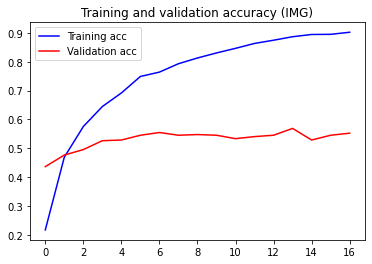

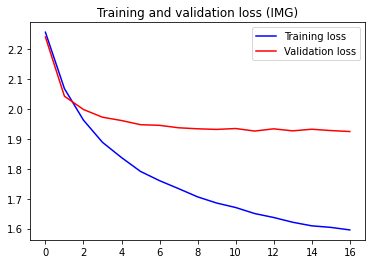

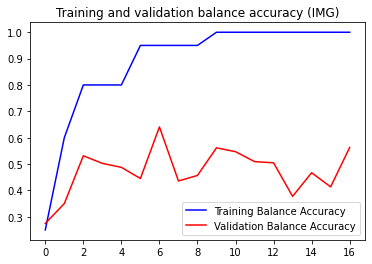

In [62]:
'''PLOT CURVES'''
import datetime
path = path_progettoDL


data_ora = datetime.datetime.now()

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
bal_acc = history['bal_acc']
val_bal_acc = history['val_bal_acc']
lista = [acc,val_acc,loss,val_loss, bal_acc, val_bal_acc]

import csv
os.chdir(path_progettoDL+'weights/')
with open("VGG16.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(lista)
     
len_epochs = range(len(acc))

plt.plot(len_epochs, acc, 'b', label='Training acc')
plt.plot(len_epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (IMG)')
plt.legend()
plt.savefig(os.path.join(path_progettoDL+'weights/PlotAcc_{}_{}.pdf'.format(type_img,data_ora))) 

plt.figure()
 
plt.plot(len_epochs, loss, 'b', label='Training loss')
plt.plot(len_epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (IMG)')
plt.legend()
plt.savefig(os.path.join(path_progettoDL+'weights/PlotLoss_{}_{}.pdf'.format(type_img,data_ora)))

#plt.figure(figsize=(20, 6), dpi=80)
plt.figure()

plt.plot(len_epochs, bal_acc, 'b', label='Training Balance Accuracy')
plt.plot(len_epochs, val_bal_acc, 'r', label='Validation Balance Accuracy')
plt.title('Training and validation balance accuracy (IMG)')
plt.legend()
plt.savefig(os.path.join(path_progettoDL+'weights/PlotBalAcc_{}_{}.pdf'.format(type_img,data_ora)))

## SAVE MODEL 

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [63]:
#salvataggio modello pesi finali
path = path_progettoDL+'pytorch_model_GAN_BAL_DAT_SAM_FIN'
torch.save(model.state_dict(), os.path.join(path))
print("Saved model to disk")

Saved model to disk


## LOAD MODEL 

In [64]:
path = path_progettoDL+'pytorch_model_GAN_BAL_DAT_SAM_FIN'
model.load_state_dict(torch.load(path))
model.eval()
print('Model IMG Loaded')

Model IMG Loaded


## PREDICTION 

In [65]:
num_test_correct  = 0
num_test_examples = 0
#da rimuovere dopo 
#criterion = nn.CrossEntropyLoss()

scores_, targets_ = list(), list()

for (data, targets, targets2) in (testloader):
  data = data.to(device=device)
  targets = targets.to(device = device) #classes
  targets2 = targets2.to(device = device) #series

  scores = model(data)
  
  num_test_correct  += (torch.max(scores, 1)[1] == targets).sum().item()
  num_test_examples += scores.shape[0]

  #scores_.append(torch.max(scores, 1)[1])
  scores_ = np.append(scores_, torch.max(scores, 1)[1].detach().numpy())
  targets_ = np.append(targets_, targets.detach().numpy())

#print('num_val_correct {}'.format(num_val_correct))
#print('num_val_examples {}'.format(num_val_examples))

test_acc  = num_test_correct / num_test_examples
test_bal_acc = balanced_accuracy_score(targets_, scores_)

print('Accuracy : {:.4f}, balance accuracy : {:.4f}'. format(test_acc, test_bal_acc))

Accuracy : 0.4953, balance accuracy : 0.4550


In [66]:
# qui ho cercato di capire quanti scores_ e targets_ sono uguali tra loro
K=0
K += (scores_ == targets_).sum().item()
print(f'predizione corrette : {K}')

predizione corrette : 210


## IDEA ALEX 

**IDEA**:
PER MIGLIORARE L'ALGORITMO POTREMMO METTERE UNA LOGICA AGGIUNTIVA:

***IPOTESI*** SE VETTORE DELLE PROBABILITÀ DELLE PREDICTION IN FASE DI TRAINING HA COME VALORE MAGGIORE (DOVE VALE argmax) UN VALORE INFERIORE A 0.25-0.3 ALLORA PROBABILMENTE LE PROBABILITÀ SONO MOLTE DISTRIBUITE PERCHÈ LA RETE NEURALE LA STA PREDICENDO MALE, QUINDI POSSIAMO FORSE SUPPORRE CHE QUELL'IMMAGINE PUÒ TROVARSI FORSE (COME CLASSE DI QUALITÀ IN ZONA INTERMEDIA), QUANDO INVECE POTREBBE AVER DECISO MALE DI TROVARSI NEGLI ESTREMI (I.E. 1,2-, 3+,4).
**AZIONE** IO PROVEREI QUINDI A STAMPARE TUTTI I VETTORI OGNI QUAL VOLTA IL VALORE DI ARGMAX SIA INFERIRORE A 0.25-0.3 E AIUTARLO IN MODO SUPERVISIONATO, METTENDO MAGARI DELLE CONDIZIONI PER FARGLI CAMBIARE IDEA POSTO DECISIONE DELLA RETE NEURALE, O ADDIRITTURA CERCANDO UN MODO PER AGGIORNARE I PESI.
ALTRIMENTI SEMPRE LATO UTENTE SI PUÒ PROVARE A MODIFICARE L'OUTPUT DELLA PREDIZIONE
**NOTA:** OVVIAMENTE PRIMA DI PROCEDERE SU QUESTA STRADA STAMPARE TUTTI I POSSIBILI VETTORI CON LA RELATIVA LABEL REALE E LABEL PREDETTA, COSÌ DA VEDERE SE QUESTA COSA FOSSE MOLTO RICORRENTE


##SEARCH UNIVOQUE SERIES TO BALANCE SETS (DA CONTROLLARE SERVE PER LE CM) 

In [67]:
#SEARCHING UNIVOQUE SERIES
test_array_s0, test_array_s1, test_array_s2, test_array_s3, test_array_s4, test_array_s5, test_array_s6, test_array_s7, test_array_s8, test_array_s9, test_array_s10, test_array_s11, test_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
pred_array_s0, pred_array_s1, pred_array_s2, pred_array_s3, pred_array_s4, pred_array_s5, pred_array_s6, pred_array_s7, pred_array_s8, pred_array_s9, pred_array_s10, pred_array_s11, pred_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
i=0
for index, row in test_balance_df.iterrows():
    
    series_ = int(row['series'])
    if series_ == 0:
      test_array_s0.append(targets_[i])
      pred_array_s0.append(scores_[i])
    if series_ == 1:
      test_array_s1.append(targets_[i])
      pred_array_s1.append(scores_[i])
    if series_ == 2:
      test_array_s2.append(targets_[i])
      pred_array_s2.append(scores_[i])
    if series_ == 3:
      test_array_s3.append(targets_[i])
      pred_array_s3.append(scores_[i])
    if series_ == 4:
      test_array_s4.append(targets_[i])
      pred_array_s4.append(scores_[i])
    if series_ == 5:
      test_array_s5.append(targets_[i])
      pred_array_s5.append(scores_[i])
    if series_ == 6:
      test_array_s6.append(targets_[i])
      pred_array_s6.append(scores_[i])
    if series_ == 7:
      test_array_s7.append(targets_[i])
      pred_array_s7.append(scores_[i])
    if series_ == 8:
      test_array_s8.append(targets_[i])
      pred_array_s8.append(scores_[i])
    if series_ == 9:
      test_array_s9.append(targets_[i])
      pred_array_s9.append(scores_[i])
    if series_ == 10:
      test_array_s10.append(targets_[i])
      pred_array_s10.append(scores_[i])
    if series_ == 11:
      test_array_s11.append(targets_[i])
      pred_array_s11.append(scores_[i])
    if series_ == 12:
      test_array_s12.append(targets_[i])
      pred_array_s12.append(scores_[i])

    i=i+1

print(test_array_s0)
print(pred_array_s0)

from functools import reduce
reduced = reduce(np.union1d, (pred_array_s0, test_array_s0))
print(reduced)

[5.0, 9.0, 8.0, 0.0, 1.0, 6.0, 3.0, 7.0, 6.0, 8.0, 2.0, 7.0, 8.0, 3.0, 7.0, 8.0, 4.0, 8.0, 6.0, 1.0, 3.0, 0.0, 0.0, 5.0, 5.0, 5.0]
[5.0, 8.0, 8.0, 0.0, 1.0, 6.0, 3.0, 7.0, 8.0, 8.0, 2.0, 8.0, 8.0, 3.0, 6.0, 6.0, 6.0, 8.0, 6.0, 3.0, 4.0, 3.0, 0.0, 2.0, 5.0, 6.0]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


## METRICHE MASK & IMG 

In [68]:
'''METRICHE'''
print('--------------Metrice IMG----------------')
#print(y_test)
#print(y_pred)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html                                  
print("test accuracy  : {:.4f}".format(accuracy_score(targets_, scores_) ))
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html?highlight=precision_score#sklearn.metrics.precision_score
print("precision  : {:.4f}".format(precision_score(targets_, scores_, average="macro")))
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score#sklearn.metrics.recall_score         
print("recall : {:.4f}".format(recall_score(targets_, scores_ , average="macro")))
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1_score#sklearn.metrics.f1_score             
print("f1_score : {:.4f}".format(f1_score(targets_, scores_, average="macro")))        
print('classification report')
print(classification_report(targets_, scores_))  


--------------Metrice IMG----------------
test accuracy  : 0.4953
precision  : 0.5839
recall : 0.4550
f1_score : 0.4386
classification report
              precision    recall  f1-score   support

         0.0       0.69      0.78      0.73        37
         1.0       0.83      0.13      0.22        39
         2.0       0.37      0.50      0.43        38
         3.0       0.29      0.43      0.35        28
         4.0       0.47      0.26      0.33        35
         5.0       0.49      0.70      0.58        64
         6.0       0.51      0.55      0.53        69
         7.0       0.69      0.26      0.37        43
         8.0       0.49      0.81      0.61        48
         9.0       1.00      0.13      0.23        23

    accuracy                           0.50       424
   macro avg       0.58      0.46      0.44       424
weighted avg       0.56      0.50      0.47       424



Per quanto riguarda la funzione np_quadratic_weighted_kappa abbiamo avuto alcune difficoltà implementative e quindi abbiamo cercato un codice online che ci calcolasse la stessa metrica 

[Link Utilizzato](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps)

## METRICHE SECONDARIE QWK, MS, MAE 


In [69]:

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=1 # era None abbiamo messo 0
    max_rating=9 # era None abbiamo messo 9
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [70]:
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

os.chdir(path)

from metrics import np_quadratic_weighted_kappa, minimum_sensitivity
from sklearn.metrics import mean_absolute_error

#Alternativa al MS di metrics 
from imblearn.metrics import sensitivity_score

def compute_metrics(y_true, y_pred, num_classes):
  # Calculate metric
  qwk = quadratic_weighted_kappa(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  #ms = minimum_sensitivity(y_true, y_pred) #---> DA RIVEDERE PERCHE' NON C'é PIU' y_pred_no_argmax
  
  ms = sensitivity_score(y_true, y_pred, average='macro')


  metrics = {
		'QWK': qwk,
		'MS': ms,
		'MAE': mae
  }
  
  return metrics

def print_metrics(metrics):
	print('QWK: {:.4f}'.format(metrics['QWK']))
	print('MS: {:.4f}'.format(metrics['MS']))
	print('MAE: {:.4f}'.format(metrics['MAE']))    


#-----codice------

num_classi = 10

print('Metrics')
metrics = compute_metrics(targets_, scores_,num_classi)
print_metrics(metrics)


with open("metrics.txt", "w") as text_file:
    print(print_metrics, file=text_file)


Metrics
QWK: 0.6829
MS: 0.4550
MAE: 0.7547


***Metrice Ottenute***

**K Cohen**   https://it.vvikipedla.com/wiki/Cohen%27s_kappa
Il Kappa di Cohen è un coefficiente statistico che rappresenta il grado di accuratezza e affidabilità in una classificazione statistica; è un indice di concordanza che tiene conto della probabilità di concordanza casuale; l'indice calcolato in base al rapporto tra l'accordo in eccesso rispetto alla probabilità di concordanza casuale e l'eccesso massimo ottenibile. Attraverso la matrice di confusione è possibile valutare questo parametro. In particolare ... Esistono diversi "gradi di concordanza", in base ai quali possiamo definire se Kappa di Cohen è scarso o ottimo:

- se k assume valori inferiori a 0, allora non c'è concordanza;
- se k assume valori compresi tra 0-0,4, allora la concordanza è scarsa;
- se k assume valori compresi tra 0,4-0,6, allora la concordanza è discreta;
- se k assume valori compresi tra 0,6-0,8, la concordanza è buona;
- se k assume valori compresi tra 0,8-1, la concordanza è ottima.

**QWK**: 0.7849

BLA BLA BLA 

**MS**: 1.0000


In statistics, **mean absolute error (MAE)** is a measure of errors between paired observations expressing the same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time versus initial time, and one technique of measurement versus an alternative technique of measurement. 

**MAE**: 0.0000

## CONFUSION MATRIX FUNCTION - DA RIMUOVERE

In [71]:
#Confusion Matrix - CROP
import sklearn.metrics as metrics

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    axes = plt.gca()
    bottom, top = axes.get_ylim()
    axes.set_ylim(bottom + 0.5, top - 0.5)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    return fig




## PLOT CONFUSION MATRIX

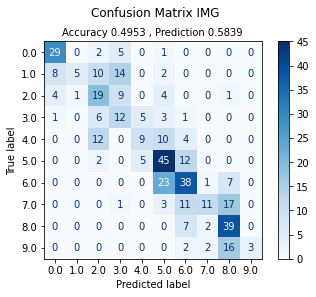

In [72]:
import sklearn.metrics as metrics
data_ora = datetime.datetime.now()


fig, axs = plt.subplots(1)
fig0 = ConfusionMatrixDisplay.from_predictions(y_true=targets_, y_pred=scores_, cmap='Blues', ax = axs)
plt.suptitle('Confusion Matrix IMG', y=1.0, fontsize=12)
plt.title('Accuracy {:.4f} , Prediction {:.4f}'.format(accuracy_score(targets_, scores_),precision_score(targets_, scores_, average="macro") ), fontsize=10)
plt.show()
fig.savefig(os.path.join(path+'weights/CM_{}_{}.pdf'.format(type_img,data_ora))) 


##PLOT CONFUSION MATRIX PER CIASCUNA SERIE DEL CALCIO 

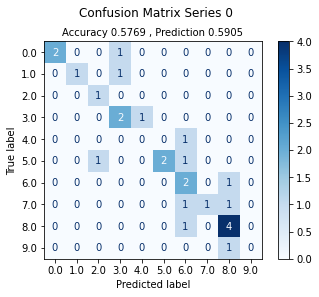

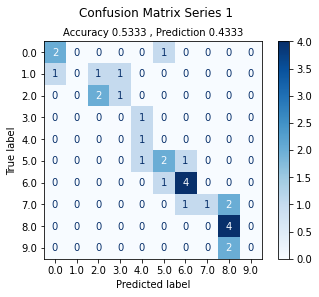

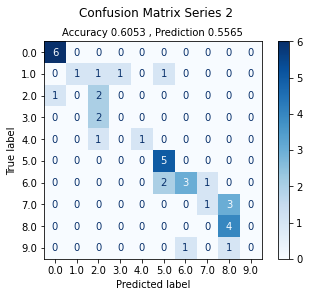

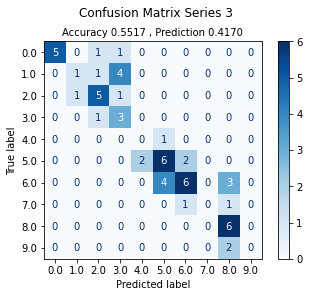

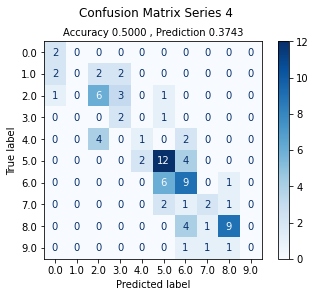

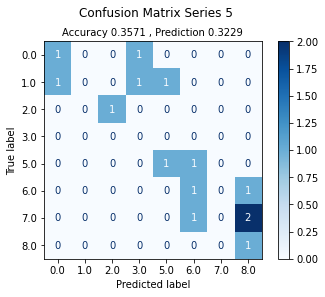

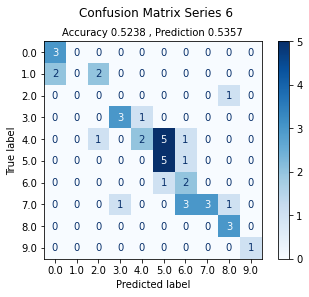

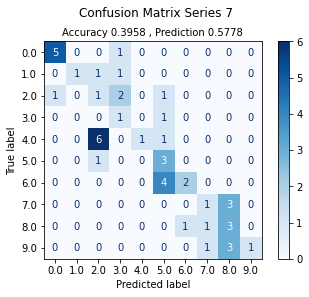

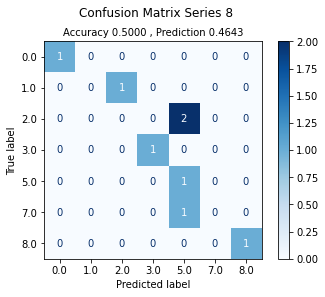

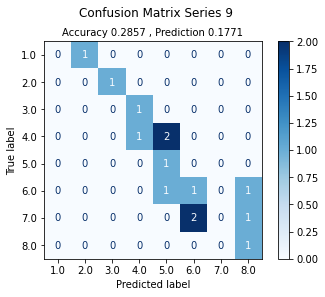

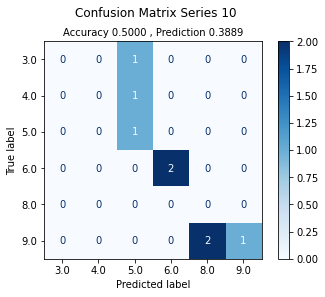

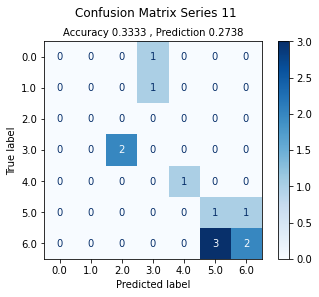

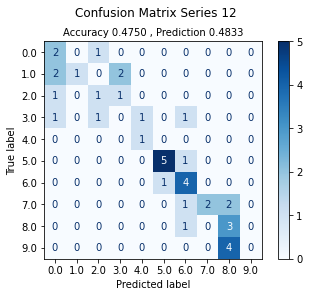

In [73]:
path = path_progettoDL
data_ora = datetime.datetime.now()

test_array_series_complete = [
        test_array_s0, test_array_s1, test_array_s2, test_array_s3, test_array_s4,
        test_array_s5, test_array_s6, test_array_s7, test_array_s8, test_array_s9,
        test_array_s10, test_array_s11, test_array_s12             
]

pred_array_series_complete = [
        pred_array_s0, pred_array_s1, pred_array_s2, pred_array_s3, pred_array_s4,
        pred_array_s5, pred_array_s6, pred_array_s7, pred_array_s8, pred_array_s9,
        pred_array_s10, pred_array_s11, pred_array_s12             
]

for series in range(13):
  fig, axs = plt.subplots(1)
  fig0 = ConfusionMatrixDisplay.from_predictions(y_true=test_array_series_complete[series], y_pred=pred_array_series_complete[series], cmap='Blues', ax = axs)
  plt.suptitle('Confusion Matrix Series {}'.format(series), y=1.0, fontsize=12)
  plt.title('Accuracy {:.4f} , Prediction {:.4f}'.format(accuracy_score(test_array_series_complete[series], pred_array_series_complete[series]),precision_score(test_array_series_complete[series], pred_array_series_complete[series], average="macro") ), fontsize=10)
  plt.show()
  fig.savefig(os.path.join(path+'weights/CM_serie{}_{}_{}.pdf'.format(series, type_img,data_ora))) 

## CRAMER V CORRELATION

In [74]:

#PRIMA VERSIONE
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

confusion_matrix = pd.crosstab(scores_, targets_)
print("cramer correlation tra predizioni delle classi, e le classi effettive")
cramer1 = cramers_v(confusion_matrix.values)
print('CRAMER : {:.5f} '.format(cramer1))


'''
#------ prove denis ----------
test_array_series = np.array(test_balance_df['series']) 
y_test_series = test_array_series #custom_to_categorical(np.unique(test_array_series, return_inverse=True)[1], num_classes=13)  
#print(y_test_series)
#------ fine prove denis ----------

confusion_matrix2 = pd.crosstab(y_test_series, scores_)
print("cramer correlation tra predizioni delle classi e le ground thruth di shotgun series")
cramer2 = cramers_v(confusion_matrix2.values)
print(cramer2)
'''
print('-------------')

cramer correlation tra predizioni delle classi, e le classi effettive
CRAMER : 0.49509 
-------------


In [75]:
print('Seconda versione Cramer')
'''
#SECONDA VERSIONE.        https://www.youtube.com/watch?v=eTnLTJer_Oo
contTable = pd.crosstab(y_test_series, scores_)
print(contTable)

!pip install researchpy

import researchpy

crosstab, res = researchpy.crosstab(pd.Series(y_test_series), pd.Series(scores_), test='chi-square')
print("\n{}".format(res))

df = min(contTable.shape[0], contTable.shape[1]) - 1
print("\ndf = {}".format(df))

V = res.iloc[2,1]
print("V = {}".format(V))

if df == 1:
    if V < 0.10:
        qual = 'negligible'
    elif V < 0.30:
        qual = 'small'
    elif V < 0.50:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 2:
    if V < 0.07:
        qual = 'negligible'
    elif V < 0.21:
        qual = 'small'
    elif V < 0.35:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 3:
    if V < 0.06:
        qual = 'negligible'
    elif V < 0.17:
        qual = 'small'
    elif V < 0.29:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 4:
    if V < 0.05:
        qual = 'negligible'
    elif V < 0.15:
        qual = 'small'
    elif V < 0.25:
        qual = 'medium'
    else:
        qual = 'large'
else:
    if V < 0.05:
        qual = 'negligible'
    elif V < 0.13:
        qual = 'small'
    elif V < 0.22:
        qual = 'medium'
    else:
        qual = 'large'

print("\nquality classification of the correlation is:   {}".format(qual))
'''
print('------')

Seconda versione Cramer
------


To indicate the strength of the association between two nominal variables, Cramér's V (Cramér, 1946) is often used.

As for the interpretation for Cramér's V various rules of thumb exist but one of them is from Cohen (1988, pp. 222, 224, 225) who let's the interpretation depend on the degrees of freedom, shown in the table below.

|df*|negligible|small|medium|large|
|-------|---|---|---|---|
|1|0 < .10|.10 < .30|.30 < .50|.50 or more|
|2|0 < .07|.07 < .21|.21 < .35|.35 or more|
|3|0 < .06|.06 < .17|.17 < .29|.29 or more|
|4|0 < .05|.05 < .15|.15 < .25|.25 or more|
|5|0 < .05|.05 < .13|.13 < .22|.22 or more|

The degrees of freedom (df*) is for Cramér's V the minimum of the number of rows, or number of columns, then minus one.

Lets see how to obtain Cramér's V with Python, using an example.




**A SECONDA DEI RISULTATI E CONFRONTANDOLI CON LA TABELLA RIUSCIAMO A CAPIRE L'INTENSITA' DEL BIAS TRA DIVERSE VARIABILI**

## **T-SNE  & PCA**


### Spiegazioni, Link Utili e Implementazione 

***(t-SNE)*** t-Distributed Stochastic Neighbor Embedding is a non-linear dimensionality reduction algorithm used for exploring high-dimensional data. It maps multi-dimensional data to two or more dimensions suitable for human observation. With help of the t-SNE algorithms, you may have to plot fewer exploratory data analysis plots next time you work with high dimensional data.

[Link utile ](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)

***(PCA) Principal Component Analysis***
Lʹanalisi delle componenti principali (detta pure PCA oppure CPA) è una tecnica utilizzata nell’ambito della statistica multivariata per la semplificazione dei dati d’origine.
Lo scopo primario di questa tecnica è la riduzione di un numero più o meno elevato di variabili (rappresentanti altrettante caratteristiche del fenomeno analizzato) in alcune variabili latenti. Ciò avviene tramite una trasformazione lineare delle variabili che proietta quelle originarie in un nuovo sistema cartesiano nel quale le variabili vengono ordinate in ordine decrescente di varianza: pertanto, la variabile con maggiore varianza viene proiettata sul primo asse, la seconda sul secondo asse e così via. La riduzione della complessità avviene limitandosi ad analizzare le principali (per varianza) tra le nuove variabili.
Diversamente da altre trasformazioni (lineari) di variabili praticate nellʹambito della statistica, in questa tecnica sono gli stessi dati che determinano i vettori di trasformazione.
[Step By Step](https://www.youtube.com/watch?v=FgakZw6K1QQ)

[Link Utile](https://www.analyticsvidhya.com/blog/2020/12/an-end-to-end-comprehensive-guide-for-pca/) 

***Parametri del TSNE***
1. **n_components** int, default=2 - Dimension of the embedded space.

2. **perplexityfloat, default=30.0** - The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results.

3. **early_exaggeration float, default=12.0**
Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space. Again, the choice of this parameter is not very critical. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high.

4. **learning_ratefloat, default=200.0** The learning rate for t-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help.

5. **n_iterint, default=1000**
Maximum number of iterations for the optimization. Should be at least 250.

6. **n_iter_without_progressint, default=300**
Maximum number of iterations without progress before we abort the optimization, used after 250 initial iterations with early exaggeration. Note that progress is only checked every 50 iterations so this value is rounded to the next multiple of 50.

7. **metricstr or callable, default=’euclidean’**
The metric to use when calculating distance between instances in a feature array. If metric is a string, it must be one of the options allowed by scipy.spatial.distance.pdist for its metric parameter, or a metric listed in pairwise.PAIRWISE_DISTANCE_FUNCTIONS. If metric is “precomputed”, X is assumed to be a distance matrix. Alternatively, if metric is a callable function, it is called on each pair of instances (rows) and the resulting value recorded. The callable should take two arrays from X as input and return a value indicating the distance between them. The default is “euclidean” which is interpreted as squared euclidean distance.

8. **init{‘random’, ‘pca’} or ndarray of shape(n_samples, n_components), default=’random’**
Initialization of embedding. Possible options are ‘random’, ‘pca’, and a numpy array of shape (n_samples, n_components). PCA initialization cannot be used with precomputed distances and is usually more globally stable than random initialization.

9. **verboseint, default=0** Verbosity level.

10. **random_stateint, RandomState instance or None, default=None** Determines the random number generator. Pass an int for reproducible results across multiple function calls. Note that different initializations might result in different local minima of the cost function. See :term: Glossary <random_state>.

11. **methodstr, default=’barnes_hut’**
By default the gradient calculation algorithm uses Barnes-Hut approximation running in O(NlogN) time. method=’exact’ will run on the slower, but exact, algorithm in O(N^2) time. The exact algorithm should be used when nearest-neighbor errors need to be better than 3%. However, the exact method cannot scale to millions of examples.

12. **n_jobsint, default=None**
The number of parallel jobs to run for neighbors search. This parameter has no impact when metric="precomputed" or (metric="euclidean" and method="exact"). None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.


[scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

[misread-tsne](https://distill.pub/2016/misread-tsne/)

[altro modo spiegato anche meglio](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)


#### Dataset 

In [76]:
'''
import numpy as np
from keras.models import Sequential
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd

os.chdir('/content/drive/MyDrive/ProgettoDL')
path = os.getcwd()

col_list_sx = ["ID", "COD_COMPONENTE", "IMG_LATOSX", "CLASSE_CALCIOSX"]
dataframe_sx_complessivo = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_sx, sep=";")


col_list_dx = ["ID", "COD_COMPONENTE", "IMG_LATODX", "CLASSE_CALCIODX"]
dataframe_dx_complessivo = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_dx, sep=";")


dataframe_sx_complessivo.columns = ['ID','series', 'filename', 'class']
dataframe_dx_complessivo.columns = ['ID','series', 'filename', 'class']

#print(dataframe_sx.columns)                 #stampo i due elementi con stesso ID (lato dx e sx di stesso CALCIO)
frames = [dataframe_sx_complessivo, dataframe_dx_complessivo]
result_complessivo = pd.concat(frames)
#print(result_complessivo)
#print(result_complessivo.loc[[1]])
#print(type(result_complessivo.loc[[1]]))

result_complessivo["class"] = result_complessivo["class"].map({'1': int(0), '2-': int(1), '2': int(2), '2+': int(3), '3-': int(4), '3': int(5), '3+': int(6), '4-': int(7), '4': int(8), '4+': int(9)})
result_complessivo["series"] = result_complessivo["series"].map({2: int(0), 4: int(1), 8: int(2), 10: int(3), 6: int(4), 9: int(5), 3: int(6), 11: int(7), 12: int(8), 13: int(9), 14: int(10), 15: int(11), 7: int(12)})

#IDENTIFICAZIONE VALORI NULL 
print("Null VALUE di class : "+format(result_complessivo['class'].isnull().sum()))
print(result_complessivo.loc[result_complessivo['class'] == '0'])
print(result_complessivo[result_complessivo['class'].isnull()])
result_complessivo['class'] = pd.to_numeric(result_complessivo['class'], errors='coerce')
print(result_complessivo[result_complessivo['class'].isnull()])
result_complessivo = result_complessivo.dropna(subset=['class'])    #rimuovo le righe con elementi nulli
print(result_complessivo[result_complessivo['class'].isnull()])

print("Null VALUE di class : "+format(result_complessivo['class'].isnull().sum()))

#IMMG EXIST ?  (cerco se qualche path non esiste e lo elimino dal dataframe) e se esiste ne faccio la MASCHERA
import os.path
from os import path
os.chdir('/content/drive/MyDrive/CALCIO_NOPRE')
for index, row in result_complessivo.iterrows():
    filename = row['filename']
    if(os.path.exists(filename) == False):
      result_complessivo = result_complessivo.drop(result_complessivo[(result_complessivo['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))

print('------------------- DATASET BASE ---------------')
print(type(result_complessivo))  
print(len(result_complessivo))
print(result_complessivo)

result_complessivo_totale = pd.DataFrame()

for index, row in result_complessivo.iterrows():
  filename_mask = 'mask_{}'.format(row['filename'])
  #filename_gray = 'gray_{}'.format(row['filename'])
  class_ = row['class']
  series_ = row['series']
  #print('{}_{}_{}_{}'.format(filename_gray,filename_mask, class_, series_)) "ID": row['ID']
  row_df_1 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename_mask, "class" : class_},index=[0])
  #row_df_2 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename_gray, "class" : class_},index=[0])
  #row_df_3 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename, "class" : class_},index=[0])
  #print(row_df_1)
  #print(row_df_2)
  result_complessivo_totale = result_complessivo_totale.append(row_df_1)
  #result_complessivo_totale = result_complessivo_totale.append(row_df_2)
  #result_complessivo_totale = result_complessivo_totale.append(row_df_3)


print('------------------- DATASET COMPLESSIVO ---------------') 
print(type(result_complessivo_totale))  
print(len(result_complessivo_totale))
#print(result_complessivo_totale)

from sklearn.utils import shuffle
result_complessivo_totale = shuffle(result_complessivo_totale)
print(type(result_complessivo_totale))  
print(len(result_complessivo_totale))
print(result_complessivo_totale)
'''

'\nimport numpy as np\nfrom keras.models import Sequential\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\nimport os\nimport pandas as pd\n\nos.chdir(\'/content/drive/MyDrive/ProgettoDL\')\npath = os.getcwd()\n\ncol_list_sx = ["ID", "COD_COMPONENTE", "IMG_LATOSX", "CLASSE_CALCIOSX"]\ndataframe_sx_complessivo = pd.read_csv(os.path.join(path + \'/20201102_ExportDB.txt\'), usecols=col_list_sx, sep=";")\n\n\ncol_list_dx = ["ID", "COD_COMPONENTE", "IMG_LATODX", "CLASSE_CALCIODX"]\ndataframe_dx_complessivo = pd.read_csv(os.path.join(path + \'/20201102_ExportDB.txt\'), usecols=col_list_dx, sep=";")\n\n\ndataframe_sx_complessivo.columns = [\'ID\',\'series\', \'filename\', \'class\']\ndataframe_dx_complessivo.columns = [\'ID\',\'series\', \'filename\', \'class\']\n\n#print(dataframe_sx.columns)                 #stampo i due elementi con stesso ID (lato dx e sx di stesso CALCIO)\nframes = [dataframe_sx_complessivo, dataframe_dx_complessivo]\nresult_complessivo = pd.con

#### import utili per il TSNE e PCA

In [77]:
'''
%matplotlib inline
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd    
from sklearn.preprocessing import StandardScaler
'''

'\n%matplotlib inline\nfrom __future__ import print_function\nimport time\nimport numpy as np\nimport pandas as pd\nfrom sklearn.decomposition import PCA\nfrom sklearn.manifold import TSNE\nfrom sklearn import datasets\nimport matplotlib.pyplot as plt\nimport matplotlib.pyplot as plt\nfrom mpl_toolkits.mplot3d import Axes3D\nimport seaborn as sns\nfrom sklearn.manifold import TSNE\nimport pandas as pd    \nfrom sklearn.preprocessing import StandardScaler\n'

#### IMG to ARRAY per il calcolo del PCA e TSNE & Reduction delle immagini

##### IMG to ARRAY per il calcolo del PCA e TSNE & Reduction delle immagini - QUALITY CLASS

In [78]:
'''
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
from tqdm import tqdm
immg_rows = 270 
immg_cols = 470
X = [] 
imgs_array_tot = []

data_X = result_complessivo_totale['filename'][:1000] #---versione originale 
result_complessivo_totale_min = result_complessivo_totale[:1000] #--deve essere uguale a y_dim ---versione originale 
y = result_complessivo_totale['class'][:1000] #--- deve essere uguale ... ---versione originale 

for index, row in tqdm(result_complessivo_totale_min.iterrows()):
    filename = row['filename']
    if(filename[0] == 'm'):
      image = load_img('/content/drive/My Drive/MASK_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    elif(filename[0] == 'g'): 
      image = load_img('/content/drive/My Drive/GRAY_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    else:
      image = load_img('/content/drive/My Drive/CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    
    #print('Originale : {} x {} x {}'.format(image.size[0], image.size[1], len(image.size)-1))
    #plt.imshow(image)
    scale_percent = 90 # percent of original size
    width, height = image.size
    #print('channel : {}'.format(len(image.size)))
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    dim = (width, height)
    # resize image
    x = img_to_array(image)
    resized = cv2.resize(x, dim, interpolation = cv2.INTER_AREA)
    #print('Ridimensionata : {}'.format((resized.shape)))
    #print('Resized Dimensions : ',resized.shape)
    imgs_array_tot.append(resized)
    X = np.asarray(imgs_array_tot)
print(X.shape)
'''

'\n# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b\nfrom tqdm import tqdm\nimmg_rows = 270 \nimmg_cols = 470\nX = [] \nimgs_array_tot = []\n\ndata_X = result_complessivo_totale[\'filename\'][:1000] #---versione originale \nresult_complessivo_totale_min = result_complessivo_totale[:1000] #--deve essere uguale a y_dim ---versione originale \ny = result_complessivo_totale[\'class\'][:1000] #--- deve essere uguale ... ---versione originale \n\nfor index, row in tqdm(result_complessivo_totale_min.iterrows()):\n    filename = row[\'filename\']\n    if(filename[0] == \'m\'):\n      image = load_img(\'/content/drive/My Drive/MASK_CALCIO_CROP/{}\'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")\n    elif(filename[0] == \'g\'): \n      image = load_img(\'/content/drive/My Drive/GRAY_CALCIO_CROP/{}\'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")\n    else:\n    

##### IMG to ARRAY per il calcolo del PCA e TSNE & Reduction delle immagini - SHOTGUN SERIES

In [79]:
'''
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
from tqdm import tqdm

immg_rows = 270 
immg_cols = 470
X = [] 
imgs_array_tot = []
data_X = result_complessivo_totale['filename'][:1000]

result_complessivo_totale_min = result_complessivo_totale[:1000] #--deve essere uguale a y_dim

y = result_complessivo_totale['class'][:1000] #--- deve essere uguale ... 

y_series = result_complessivo_totale['series'][:1000] #--- deve essere uguale ...

for index, row in tqdm(result_complessivo_totale_min.iterrows()):
    filename = row['filename']
    if(filename[0] == 'm'):
      image = load_img('/content/drive/My Drive/MASK_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    elif(filename[0] == 'g'): 
      image = load_img('/content/drive/My Drive/GRAY_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    else:
      image = load_img('/content/drive/My Drive/CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")

    scale_percent = 90 # percent of original size
    width, height = image.size
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    dim = (width, height)
    # resize image
    x = img_to_array(image)
    resized = cv2.resize(x, dim, interpolation = cv2.INTER_AREA)
    #print('Ridimensionata : {}'.format((resized.shape)))
    #print('Resized Dimensions : ',resized.shape)
    imgs_array_tot.append(resized)
    X2 = np.asarray(imgs_array_tot)
print(X2.shape) 
'''

'\n# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b\nfrom tqdm import tqdm\n\nimmg_rows = 270 \nimmg_cols = 470\nX = [] \nimgs_array_tot = []\ndata_X = result_complessivo_totale[\'filename\'][:1000]\n\nresult_complessivo_totale_min = result_complessivo_totale[:1000] #--deve essere uguale a y_dim\n\ny = result_complessivo_totale[\'class\'][:1000] #--- deve essere uguale ... \n\ny_series = result_complessivo_totale[\'series\'][:1000] #--- deve essere uguale ...\n\nfor index, row in tqdm(result_complessivo_totale_min.iterrows()):\n    filename = row[\'filename\']\n    if(filename[0] == \'m\'):\n      image = load_img(\'/content/drive/My Drive/MASK_CALCIO_CROP/{}\'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")\n    elif(filename[0] == \'g\'): \n      image = load_img(\'/content/drive/My Drive/GRAY_CALCIO_CROP/{}\'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="graysc

#### Check & Create Dataframe for PCA (Principal Analysis Component) & T-SNE (t-distributed stochastic neighbor embedding)

##### classi di qualità 

In [80]:
'''
print('X SHAPE : {}'.format(X.shape))

nsamples = X.shape[0]
rows = X.shape[1]
cols = X.shape[2]
channel = 1

print('n_samples : {} , rows : {} , cols : {} , channel : {} '.format(nsamples, rows, cols, channel))
print(type(X))
X_1 = np.reshape(X, (X.shape[0],rows*cols*channel)) #-- serve per modificare la dimensione, per il fit_transform          FORSE QUI BISOGNA SOLO USARE I PRIMI 2 VALORI E IL 3 DEI CANALI NO!

print('X MODIFICATO : {}'.format(X_1.shape)) #--- controllo se ho fatto tutto correttamente 

feat_cols = [ 'pixel'+str(i) for i in range(X_1.shape[1]) ]
print('Feat Cols : {} '.format(len(feat_cols)))
#print(feat_cols)
df = pd.DataFrame(X_1,columns=feat_cols)
#df = pd.DataFrame(X_1)
df['y'] = pd.DataFrame({ 'y': np.array(y) })
df['label'] = df['y'].apply(lambda i: str(i))
#X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
'''

"\nprint('X SHAPE : {}'.format(X.shape))\n\nnsamples = X.shape[0]\nrows = X.shape[1]\ncols = X.shape[2]\nchannel = 1\n\nprint('n_samples : {} , rows : {} , cols : {} , channel : {} '.format(nsamples, rows, cols, channel))\nprint(type(X))\nX_1 = np.reshape(X, (X.shape[0],rows*cols*channel)) #-- serve per modificare la dimensione, per il fit_transform          FORSE QUI BISOGNA SOLO USARE I PRIMI 2 VALORI E IL 3 DEI CANALI NO!\n\nprint('X MODIFICATO : {}'.format(X_1.shape)) #--- controllo se ho fatto tutto correttamente \n\nfeat_cols = [ 'pixel'+str(i) for i in range(X_1.shape[1]) ]\nprint('Feat Cols : {} '.format(len(feat_cols)))\n#print(feat_cols)\ndf = pd.DataFrame(X_1,columns=feat_cols)\n#df = pd.DataFrame(X_1)\ndf['y'] = pd.DataFrame({ 'y': np.array(y) })\ndf['label'] = df['y'].apply(lambda i: str(i))\n#X, y = None, None\nprint('Size of the dataframe: {}'.format(df.shape))\n\n# For reproducability of the results\nnp.random.seed(42)\nrndperm = np.random.permutation(df.shape[0])\n"

##### shotgun series 

In [81]:
'''
print('X2 SHAPE : {}'.format(X2.shape))

nsamples = X2.shape[0]
rows = X2.shape[1]
cols = X2.shape[2]
channel = 1

print('n_samples : {} , rows : {} , cols : {} , channel : {} '.format(nsamples, rows, cols, channel))
print(type(X2))
X_11 = np.reshape(X2, (X2.shape[0],rows*cols*channel)) #-- serve per modificare la dimensione, per il fit_transform          FORSE QUI BISOGNA SOLO USARE I PRIMI 2 VALORI E IL 3 DEI CANALI NO!

print('X MODIFICATO : {}'.format(X_11.shape)) #--- controllo se ho fatto tutto correttamente 
#print(X_1)

feat_cols = [ 'pixel'+str(i) for i in range(X_11.shape[1]) ]
print('Feat Cols : {} '.format(len(feat_cols)))
#print(feat_cols)
df_2 = pd.DataFrame(X_11,columns=feat_cols)
#df = pd.DataFrame(X_1)
df_2['y'] = pd.DataFrame({ 'y': np.array(y_series) })
df_2['label'] = df_2['y'].apply(lambda i: str(i))
#X, y = None, None
print('Size of the dataframe: {}'.format(df_2.shape))



# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df_2.shape[0])
'''

"\nprint('X2 SHAPE : {}'.format(X2.shape))\n\nnsamples = X2.shape[0]\nrows = X2.shape[1]\ncols = X2.shape[2]\nchannel = 1\n\nprint('n_samples : {} , rows : {} , cols : {} , channel : {} '.format(nsamples, rows, cols, channel))\nprint(type(X2))\nX_11 = np.reshape(X2, (X2.shape[0],rows*cols*channel)) #-- serve per modificare la dimensione, per il fit_transform          FORSE QUI BISOGNA SOLO USARE I PRIMI 2 VALORI E IL 3 DEI CANALI NO!\n\nprint('X MODIFICATO : {}'.format(X_11.shape)) #--- controllo se ho fatto tutto correttamente \n#print(X_1)\n\nfeat_cols = [ 'pixel'+str(i) for i in range(X_11.shape[1]) ]\nprint('Feat Cols : {} '.format(len(feat_cols)))\n#print(feat_cols)\ndf_2 = pd.DataFrame(X_11,columns=feat_cols)\n#df = pd.DataFrame(X_1)\ndf_2['y'] = pd.DataFrame({ 'y': np.array(y_series) })\ndf_2['label'] = df_2['y'].apply(lambda i: str(i))\n#X, y = None, None\nprint('Size of the dataframe: {}'.format(df_2.shape))\n\n\n\n# For reproducability of the results\nnp.random.seed(42)\nrndp

#### Calcolo TSNE & PLOT TSNE

##### TSNE QUALITY CLASS

In [82]:
'''
time_start = time.time()
N = 1000 
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
#data_subset = df_subset
#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... originale 
tsne = TSNE(n_components=2, verbose=1, perplexity=200, n_iter=6000, init='random', n_jobs = 10) #-- nuova versione 
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
'''

"\ntime_start = time.time()\nN = 1000 \ndf_subset = df.loc[rndperm[:N],:].copy()\ndata_subset = df_subset[feat_cols].values\n#data_subset = df_subset\n#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... originale \ntsne = TSNE(n_components=2, verbose=1, perplexity=200, n_iter=6000, init='random', n_jobs = 10) #-- nuova versione \ntsne_results = tsne.fit_transform(data_subset)\nprint('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))\n"

##### TSNE SHOTGUN SERIES 

In [83]:
'''
time_start = time.time()
N = 1000
df_subset_series = df_2.loc[rndperm[:N],:].copy()
#data_subset_series = df_subset_series
data_subset_series = df_subset_series[feat_cols].values
#tsne_series = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... 
tsne_series = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=6000, init='random', n_jobs = 10) #-- nuova versione 
tsne_results_series = tsne_series.fit_transform(data_subset_series)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
'''

"\ntime_start = time.time()\nN = 1000\ndf_subset_series = df_2.loc[rndperm[:N],:].copy()\n#data_subset_series = df_subset_series\ndata_subset_series = df_subset_series[feat_cols].values\n#tsne_series = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... \ntsne_series = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=6000, init='random', n_jobs = 10) #-- nuova versione \ntsne_results_series = tsne_series.fit_transform(data_subset_series)\nprint('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))\n"

##### PLOT TSNE QUALITY CLASSES

In [84]:
'''
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df_subset,
    legend="full",
    alpha=0.3
)
'''

'\ndf_subset[\'tsne-2d-one\'] = tsne_results[:,0]\ndf_subset[\'tsne-2d-two\'] = tsne_results[:,1]\nplt.figure(figsize=(16,10))\nsns.scatterplot(\n    x="tsne-2d-one", y="tsne-2d-two",\n    hue="y",\n    palette=sns.color_palette(\'Paired\', as_cmap = True),\n    data=df_subset,\n    legend="full",\n    alpha=0.3\n)\n'

##### TSNE PLOT SHOTGUN SERIES 

In [85]:
'''
df_subset_series['tsne-2d-one'] = tsne_results_series[:,0]
df_subset_series['tsne-2d-two'] = tsne_results_series[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df_subset_series,
    legend="full",
    alpha=0.3
)
'''

'\ndf_subset_series[\'tsne-2d-one\'] = tsne_results_series[:,0]\ndf_subset_series[\'tsne-2d-two\'] = tsne_results_series[:,1]\nplt.figure(figsize=(16,10))\nsns.scatterplot(\n    x="tsne-2d-one", y="tsne-2d-two",\n    hue="y",\n    palette=sns.color_palette(\'Paired\', as_cmap = True),\n    data=df_subset_series,\n    legend="full",\n    alpha=0.3\n)\n'

## **Metriche Nuove** + **B.A. across series**

#### Alcune Definizioni 


*  **True Positives** (TP): Items where the true label is positive and whose class is correctly predicted to be positive.
*  **False Positives** (FP): Items where the true label is negative and whose class is incorrectly predicted to be positive
*  **True Negatives** (N): Items where the true label is negative and whose class is correctly predicted to be negative.
*  **False Negatives** (FN): Items where the true label is positive and whose class is incorrectly predicted to be negative.

* **False Positive Rate**, or *Type I Error*: Number of items wrongly identified as positive out of the total actual negatives — FP/(FP+TN) - This error means that an image not containing a particular parasite egg is incorrectly labeled as having it
* **False Negative Rate**, or *Type II Error*: Number of items wrongly identified as negative out of the total actual positives — FN/(FN+TP). This metric is especially important to us, as it tells us the frequency with which a particular parasite egg is not classified correctly

-------------

* **Statistical Parity Difference**
This measure is based on the following formula :
𝑃𝑟(𝑌=1|𝐷=𝑢𝑛𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑)−𝑃𝑟(𝑌=1|𝐷=𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑) Here the bias or statistical imparity is the difference between the probability that a random individual drawn from unprivileged is labeled 1 (so here that he has more than 50K for income) and the probability that a random individual from privileged is labeled 1. So it has to be close to 0 so it will be fair.

*  **Equal Opportunity Difference** This metric is just a difference between the true positive rate of unprivileged group and the true positive rate of privileged group so it follows this formula - 𝑇𝑃𝑅𝐷=𝑢𝑛𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑−𝑇𝑃𝑅𝐷=𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑 Same as the previous metric we need it to be close to 0.

* **demographic parity** A fairness metric that is satisfied if the results of a model's classification are not dependent on a given sensitive attribute.

* **equality of opportunity** A fairness metric that checks whether, for a preferred label (one that confers an advantage or benefit to a person) and a given attribute, a classifier predicts that preferred label equally well for all values of that attribute. In other words, equality of opportunity measures whether the people who should qualify for an opportunity are equally likely to do so regardless of their group membership.

#### Implementazione Metriche Nuove e B.A. across series

In [86]:
!pip install fairlearn 
from fairlearn.metrics import selection_rate
from fairlearn.metrics import true_positive_rate, false_positive_rate, true_negative_rate, false_negative_rate
from fairlearn.metrics import equalized_odds_difference

import sklearn as sk


#---- metriche lisa ----#
#_true = test_balance_df['class'].to_numpy()
#VERIFICA SE SERVE RIFARE STA RIGA SOPRA, MA BASTA PRENDERE:
y_true = targets_
y_pred = scores_


SR = selection_rate(y_true, y_pred, pos_label=1, sample_weight=None)
print('selection_rate : {}' . format(SR))


#Per quanto riguarda AO come metrica, potremo utilizzare i risultati della confusion matrix ?
#LINK : https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
#LINK : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
#print('Unique Element Y_test : {}'.format(np.unique(y_test)))
#print('Unique Element Y_pred : {}'.format(np.unique(y_pred)))
#print('True_Positive_Rate : {}'.format(true_positive_rate(y_true, y_pred)))

from sklearn.metrics import confusion_matrix 
cm = confusion_matrix (y_true, y_pred)
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('TPR : {}'.format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('TNR : {}'.format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('PPV : {}'.format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print('NPV : {}'.format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('FPR : {}'.format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print('FNR : {}'.format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print('FDR : {}'.format(FDR))

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy : {}'.format(ACC))


AO = 0.5*(
    (TPR[0] + FPR[0]) - 
    (TPR[1] + FPR[1]) + 
    (TPR[2] + FPR[2]) - 
    (TPR[3] + FPR[3]) +
    (TPR[4] + FPR[4]) -
    (TPR[5] + FPR[5]) +
    (TPR[6] + FPR[6]) -
    (TPR[7] + FPR[7]) +
    (TPR[8] + FPR[8]) -
    (TPR[9] + FPR[9]))

print('AO : {}'.format(AO))
#y_true= y_true.reshape(1,-1)
#y_pred= y_pred.reshape(-1,1)
#print(y_true.shape)
#print(y_pred.shape)


'''FORSE QUA RIUSCIAMO A TROVARE UN ESEMPIO DI APPLICAZIONE DEL METODO'''
'''https://deepnote.com/@Machine-Learning-2/Miniproject-z523fGqWSSu7QV34n_u7OA'''
'''https://fairlearn.org/main/user_guide/assessment.html'''


EO =(TPR[0] - TPR[1] + TPR[2] - TPR[3] + TPR[4] - TPR[5] + TPR[6] - TPR[7] + TPR[8] - FPR[9]) 
print('EO : {}' . format(EO))


#Demographic parity
'''
Demographic parity is one of the most popular fairness indicators in the literature. 
Demographic parity is achieved if the absolute number of positive predictions 
in the subgroups are close to each other. This measure does not take true class into
consideration and only depends on the model predictions. In some literature, 
demographic parity is also referred to as statsictal parity or independence.
'''
DP = (TP + FP)
print('Demographic parity : {}' . format(DP))

#Equalized odds
'''
Equalized odds, also known as separation, are achieved if the sensitivities in the 
subgroups are close to each other. The group-specific sensitivities 
indicate the number of the true positives divided by the total 
number of positives in that group.
'''
Equalized_Odds = TP / (TP + FN)
print('Equalized Odds : {}' . format(Equalized_Odds))


##---- Link Riccardo ----##
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html

print('----------------')
Balanced_Accuracy = sk.metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)
print('Balanced Accuracy Generale : {:.5f}' . format(Balanced_Accuracy))


#####----------- PER CIASCUNA SERIE BALANCED ACCURACY -----------####
test_array_series_complete = [
        test_array_s0, test_array_s1, test_array_s2, test_array_s3, test_array_s4,
        test_array_s5, test_array_s6, test_array_s7, test_array_s8, test_array_s9,
        test_array_s10, test_array_s11, test_array_s12             
]

pred_array_series_complete = [
        pred_array_s0, pred_array_s1, pred_array_s2, pred_array_s3, pred_array_s4,
        pred_array_s5, pred_array_s6, pred_array_s7, pred_array_s8, pred_array_s9,
        pred_array_s10, pred_array_s11, pred_array_s12             
]
sum_BA = 0
print('----------------')
for series in range(13):
  BA = sk.metrics.balanced_accuracy_score(test_array_series_complete[series],pred_array_series_complete[series], sample_weight=None, adjusted=False)
  print('Balanced Accuracy Series {} : {:.5f}' . format(series,BA ))
  print('----------------')
  sum_BA = sum_BA + BA


#----------- MEDIA DELLE BALANCED ACCURACY ---------------
Average = sum_BA/13
print('Average Balanced Accuracy : {:.5f}' . format(Average))
 

##---- Wodsworth et Al ----# 
#HIGH_RISK_GAP = SP #modulo o cardinalità 

#FN_GAP = false_negative (s1) - false negative (s2) 
#FN_GAP = (false_negative_rate(y_true, y_pred) - false_negative_rate(y_true, y_pred))  #modulo o cardinalità
  
#FN_GAP = false_negative (s1) - false negative (s2) 
#FP_GAP = (false_positive_rate(y_true, y_pred) - false_positive_rate(y_true, y_pred))  #modulo o cardinalità



### LINK UTILE ####
#https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 5.2 MB/s 
selection_rate : 0.014150943396226415
TPR : [0.78378378 0.12820513 0.5        0.42857143 0.25714286 0.703125
 0.55072464 0.25581395 0.8125     0.13043478]
TNR : [0.96640827 0.9974026  0.91709845 0.92676768 0.97429306 0.87222222
 0.89577465 0.98687664 0.89095745 1.        ]
PPV : [0.69047619 0.83333333 0.37254902 0.29268293 0.47368421 0.49450549
 0.50666667 0.6875     0.4875     1.        ]
NPV : [0.97905759 0.91866029 0.94906166 0.95822454 0.93580247 0.94294294
 0.91117479 0.92156863 0.97383721 0.95249406]
FPR : [0.03359173 0.0025974  0.08290155 0.07323232 0.02570694 0.12777778
 0.10422535 0.01312336 0.10904255 0.        ]
FNR : [0.21621622 0.87179487 0.5        0.57142857 0.74285714 0.296875
 0.44927536 0.74418605 0.1875     0.86956522]
FDR : [0.30952381 0.16666667 0.62745098 0.70731707 0.52631579 0.50549451
 0.49333333 0.3125     

##PROVA MDSS (ATTUALMENTE NON FUNZIONA)

In [87]:
'''imports'''
'''Importing packages & libraries for Bias metrics from AIF360 (end page analysis)'''

"""
import sys
import itertools
import datetime

### altri package necessari 
!pip install tempeh -q --force-reinstall
!pip install fairlearn -q --force-reinstall
!pip install GitPython -q --force-reinstall

#download aif360 
#!pip install -r requirement.txt 
#!python setup.py
###test  errore nella foto 

#!pip uninstall scikit-learn -q -y 
# errore cercato in rete : https://github.com/pycaret/pycaret/issues/704
# INSTALL CONDA ON GOOGLE COLAB
#! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
#sys.path.append('/usr/local/lib/python3.7/site-packages/')
# INSTALL PACKAGE CON CONDA 
#!conda install -c conda-forge scikit-learn -y 

## package necessario utile per il gitclone
from git import Repo

date_ = datetime.datetime.now()
#Repo.clone_from("link ... .git", "path di salvataggio")
#Repo.clone_from("https://github.com/Trusted-AI/AIF360.git", "/content/aif360_repo_{}".format(date_))
Repo.clone_from("https://github.com/Trusted-AI/AIF360.git", "/content/aif360") #controllare sempre, se è già salvato ... se salvato basta commentarlo

#---serve per aggiungere un nuovo package alla lista dei package installati
sys.path.append('/content/aif360/')


from aif360.metrics.mdss.ScoringFunctions import Bernoulli, ScoringFunction 
from aif360.metrics.mdss import MDSS

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix

from IPython.display import Markdown, display
import numpy as np
import pandas as pd

from collections import defaultdict
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
"""

'\nimport sys\nimport itertools\nimport datetime\n\n### altri package necessari \n!pip install tempeh -q --force-reinstall\n!pip install fairlearn -q --force-reinstall\n!pip install GitPython -q --force-reinstall\n\n#download aif360 \n#!pip install -r requirement.txt \n#!python setup.py\n###test  errore nella foto \n\n#!pip uninstall scikit-learn -q -y \n# errore cercato in rete : https://github.com/pycaret/pycaret/issues/704\n# INSTALL CONDA ON GOOGLE COLAB\n#! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh\n#! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh\n#! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local\n#sys.path.append(\'/usr/local/lib/python3.7/site-packages/\')\n# INSTALL PACKAGE CON CONDA \n#!conda install -c conda-forge scikit-learn -y \n\n## package necessario utile per il gitclone\nfrom git import Repo\n\ndate_ = datetime.datetime.now()\n#Repo.clone_from("link ... .git", "path di salvataggio")\n#Repo.clone_from("https://git

In [88]:
"""from aif360.datasets import StandardDataset
dataset = StandardDataset(df, label_name='two_year_recid', favorable_classes=[0],
                 protected_attribute_names=['sex', 'race'],
                 privileged_classes=[[1], [1]],
                 instance_weights_name=None)"""

"from aif360.datasets import StandardDataset\ndataset = StandardDataset(df, label_name='two_year_recid', favorable_classes=[0],\n                 protected_attribute_names=['sex', 'race'],\n                 privileged_classes=[[1], [1]],\n                 instance_weights_name=None)"

In [89]:
"""
# !python3 -m pip install <pkg> -q il -q è per il quiet (per non avere quel macello in output) --force-reinstall

#https://github.com/Trusted-AI/AIF360
'''REPOSITORY PRINCIPALE DOVE SI TROVANO TUTTE LE RESTANTI CARTELLE E IMPLEMENTAZIONI'''
#https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_mdss_classifier_metric.ipynb
'''file dove il tipo fa un esempio di uso di questa metrica!'''
#https://aif360.readthedocs.io/en/latest/index.html
'''link di aif360 dove ci sono i metodi CHE IMPORTA SOTTO'''


class MDSSClassificationMetric(ClassificationMetric):
    '''
        Bias subset scanning is proposed as a technique to identify bias in predictive models using subset scanning [1].
        This class is a wrapper for the bias scan scoring and scanning methods that uses the ClassificationMetric abstraction.
    References:
        .. [1] Zhang, Z., & Neill, D. B. (2016). Identifying significant predictive bias in classifiers. arXiv preprint arXiv:1611.08292.
    '''
    def __init__(self, dataset: BinaryLabelDataset, classified_dataset: BinaryLabelDataset, 
                scoring_function: ScoringFunction = Bernoulli(direction='positive'), unprivileged_groups: dict = None, privileged_groups:dict = None):
    
        super(MDSSClassificationMetric, self).__init__(dataset, classified_dataset,
                                                       unprivileged_groups=unprivileged_groups,
                                                       privileged_groups=privileged_groups)
        
        self.scanner = MDSS(scoring_function)
    
    def score_groups(self, privileged=True, penalty = 1e-17):
        '''
        compute the bias score for a prespecified group of records.
        
        :param privileged: flag for group to score - privileged group (True) or unprivileged group (False).
        This abstract the need to explicitly specify the direction of bias to scan for which depends on what the favourable label is.
        :param penalty: penalty term. Should be positive. The penalty term as with any regularization parameter may need to be 
        tuned for ones use case. The higher the penalty, the less complex (number of features and feature values) the highest scoring
        subset that gets returned is.
        
        :returns: the score for the group
        '''
        groups = self.privileged_groups if privileged else self.unprivileged_groups
        subset = dict()
        
        xor_op = privileged ^ bool(self.classified_dataset.favorable_label)
        direction = 'positive' if xor_op else 'negative'

        for g in groups:
            for k, v in g.items():
                if k in subset.keys():
                    subset[k].append(v)
                else:
                    subset[k] = [v]
        
        coordinates = pd.DataFrame(self.dataset.features, columns=self.dataset.feature_names)
        expected = pd.Series(self.classified_dataset.scores.flatten())
        outcomes = pd.Series(self.dataset.labels.flatten())
        
        self.scanner.scoring_function.kwargs['direction'] = direction
        return self.scanner.score_current_subset(coordinates, expected, outcomes, dict(subset), penalty)
    
    def bias_scan(self, privileged=True, num_iters = 10, penalty = 1e-17):
        '''
        scan to find the highest scoring subset of records
        
        :param privileged: flag for group to scan for - privileged group (True) or unprivileged group (False). 
        This abstract the need to explicitly specify the direction of bias to scan for which depends on what the favourable label is.
        :param num_iters: number of iterations (random restarts)
        :param penalty: penalty term. Should be positive. The penalty term as with any regularization parameter may need to be 
        tuned for ones use case. The higher the penalty, the less complex (number of features and feature values) the highest scoring
        subset that gets returned is.
        
        :returns: the highest scoring subset and the score
        '''

        xor_op = privileged ^ bool(self.classified_dataset.favorable_label)
        direction = 'positive' if xor_op else 'negative'
        self.scanner.scoring_function.kwargs['direction'] = direction

        coordinates = pd.DataFrame(self.classified_dataset.features, columns=self.classified_dataset.feature_names)
        
        expected = pd.Series(self.classified_dataset.scores.flatten())
        outcomes = pd.Series(self.dataset.labels.flatten())
        
        return self.scanner.scan(coordinates, expected, outcomes, penalty, num_iters)

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas

#import requests
#url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
#r = requests.get(url, allow_redirects=True)
#open('dataset.csv', 'wb').write(r.content)
#dataset_orig = pd.read_csv('/content/dataset.csv', sep=",")  


series_group = [{'series': 0, 'series': 1, 'series': 2, 'series': 3, 'series': 4, 'series': 5, 'series': 6, 'series': 7, 'series': 8, 'series': 9, 'series': 10, 'series': 11, 'series': 12}]
classes_group = [{'class': 0, 'class': 1, 'class': 2, 'class': 3, 'class': 4, 'class': 5, 'class': 6, 'class': 7, 'class': 8, 'class': 9}]

"""



'\n# !python3 -m pip install <pkg> -q il -q è per il quiet (per non avere quel macello in output) --force-reinstall\n\n#https://github.com/Trusted-AI/AIF360\n\'\'\'REPOSITORY PRINCIPALE DOVE SI TROVANO TUTTE LE RESTANTI CARTELLE E IMPLEMENTAZIONI\'\'\'\n#https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_mdss_classifier_metric.ipynb\n\'\'\'file dove il tipo fa un esempio di uso di questa metrica!\'\'\'\n#https://aif360.readthedocs.io/en/latest/index.html\n\'\'\'link di aif360 dove ci sono i metodi CHE IMPORTA SOTTO\'\'\'\n\n\nclass MDSSClassificationMetric(ClassificationMetric):\n    \'\'\'\n        Bias subset scanning is proposed as a technique to identify bias in predictive models using subset scanning [1].\n        This class is a wrapper for the bias scan scoring and scanning methods that uses the ClassificationMetric abstraction.\n    References:\n        .. [1] Zhang, Z., & Neill, D. B. (2016). Identifying significant predictive bias in classifiers. arXiv preprint ar

In [90]:
"""

mdss_classified = MDSSClassificationMetric(dataset_orig_test, dataset_bias_test,
                         unprivileged_groups=male_group,
                         privileged_groups=female_group)


mdss_classified = MDSSClassificationMetric(test_balance_df, dataset_bias_test,
                         unprivileged_groups=classes_group,
                         privileged_groups=series_group)

series_privileged_score = mdss_classified.score_groups(privileged=True)
print(series_privileged_score)
"""

'\n\nmdss_classified = MDSSClassificationMetric(dataset_orig_test, dataset_bias_test,\n                         unprivileged_groups=male_group,\n                         privileged_groups=female_group)\n\n\nmdss_classified = MDSSClassificationMetric(test_balance_df, dataset_bias_test,\n                         unprivileged_groups=classes_group,\n                         privileged_groups=series_group)\n\nseries_privileged_score = mdss_classified.score_groups(privileged=True)\nprint(series_privileged_score)\n'